In [ ]:
%%writefile ConvNet.py


import time
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self, mode):
        super(ConvNet, self).__init__()

        # Define various layers here
        self.fc1 = nn.Linear(28*28, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 10)

        # This will select the forward pass function based on mode for the ConvNet.
        # During creation of each ConvNet model, you will assign one of the valid mode.
        # This will fix the forward function (and the network graph) for the entire training/testing

        if mode == 1:
            self.forward = self.model_1
        elif mode == 2:
            self.forward = self.model_2
        elif mode == 3:
            self.forward = self.model_3
        else:
            print("Invalid mode ", mode, "selected. Select between 1-3")
            exit(0)

    # Baseline sample model
    def model_0(self, X):
        # ======================================================================
        # Three fully connected layers with activation

        X = torch.flatten(X, start_dim=1)
        X = self.fc1(X)#first layer + ReLU
        X = F.relu(X) #negs to 0, gets non-linearity
        X = self.fc2(X) #second layer + ReLU
        X = F.relu(X)
        X = self.fc3(X) #final lin layer
        X = torch.sigmoid(X) #sigmoid act

        return X

    # Baseline model. task 1
    def model_1(self, X):
        # ======================================================================
        # Three fully connected layers without activation

        X = torch.flatten(X, start_dim=1)
        X = self.fc1(X)
        X = self.fc2(X)
        X = self.fc3(X)
        return X
        # NotImplementedError

        return X


    # task 2
    def model_2(self, X):
        # ======================================================================
        # Train with activation (use model 1 from task 1)

        X = torch.flatten(X, start_dim=1)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        # NotImplementedError

        return X


    # task 3
    def model_3(self, X):
        # ======================================================================
        # Change number of fully connected layers and number of neurons from model 2 in task 2

        X = torch.flatten(X, start_dim=1)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = F.relu(self.fc4(X))
        X = self.fc5(X)
        # NotImplementedError

        return X







Overwriting ConvNet.py


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mode:  1
LR:  0.01
Batch size:  10
Torch device selected:  cpu

Epoch:  1
Train set: Average loss: 0.4101, Accuracy: 52861/60000 (88%)
Test set: Average loss: 0.3052, Accuracy: 9150/10000 (92%)

Epoch:  2
Train set: Average loss: 0.3107, Accuracy: 54686/60000 (91%)
Test set: Average loss: 0.2881, Accuracy: 9203/10000 (92%)

Epoch:  3
Train set: Average loss: 0.2987, Accuracy: 54969/60000 (92%)
Test set: Average loss: 0.2833, Accuracy: 9203/10000 (92%)

Epoch:  4
Train set: Average loss: 0.2914, Accuracy: 55044/60000 (92%)
Test set: Average loss: 0.3008, Accuracy: 9158/10000 (92%)

Epoch:  5
Train set: Average loss: 0.2865, Accuracy: 55125/60000 (92%)
Test set: Average loss: 0.2911, Accuracy: 9172/10000 (92%)

Epoch:  6
Train set: Average loss: 0.2829, Accuracy: 55201/60000 (92%)
Test set: Average loss: 0.2954, Accuracy: 9201/10000 (92%)

Epoch:  7
Train set: Average loss: 0.2801, Accuracy: 55335/600

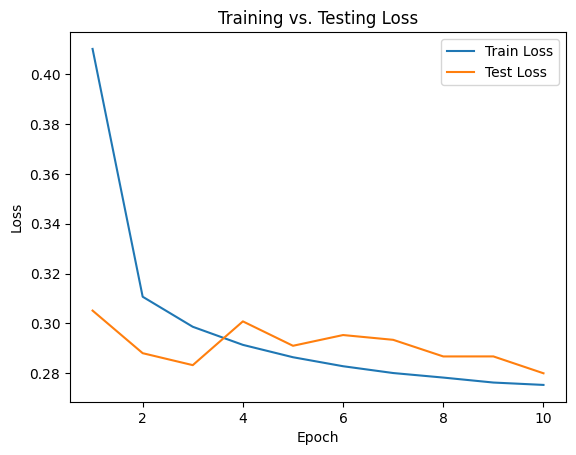

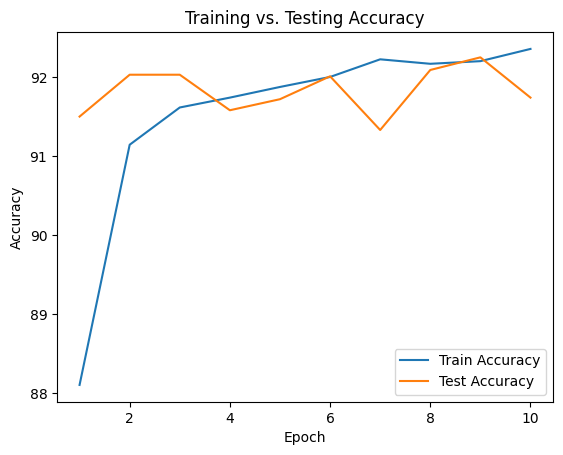

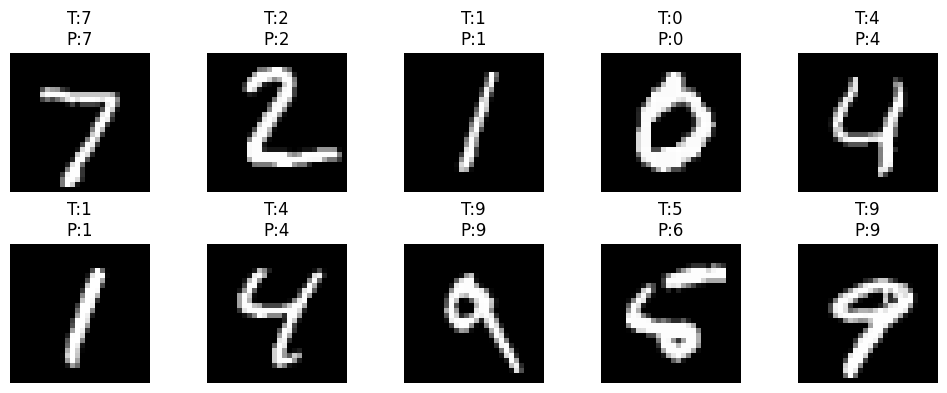

In [ ]:
from __future__ import print_function

%load_ext autoreload
%autoreload 2
from ConvNet import ConvNet
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import argparse
import numpy as np
import matplotlib.pyplot as plt


def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''

    # Set model to train mode before each epoch
    model.train()

    # Empty list to store losses
    losses = []
    correct = 0

    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample

        # Push data/label to correct device
        data, target = data.to(device), target.to(device)

        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()

        # Do forward pass for current set of data
        output = model(data)

        # ======================================================================
        # Compute loss based on criterion
        # ----------------- YOUR CODE HERE ----------------------
        loss = criterion(output, target)
        #
        # Remove NotImplementedError and assign correct loss function.
        #loss = NotImplementedError()

        # Computes gradient based on final loss
        loss.backward()

        # Store loss
        losses.append(loss.item())

        # Optimize model parameters based on learning rate and gradient
        optimizer.step()

        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # ======================================================================
        # Count correct predictions overall
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc

def test(model, device, test_loader):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''

    # Set model to eval mode to notify all layers.
    model.eval()

    losses = []
    correct = 0

    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)

            # Predict for data by doing forward pass
            output = model(data)

            # ======================================================================
            # Compute loss based on same criterion as training
            loss = F.cross_entropy(output, target, reduction='mean')

            # Append loss to overall test loss
            losses.append(loss.item())

            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # ======================================================================
            # Count correct predictions overall
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy

def run_main(FLAGS):
    # Check if cuda is available
    use_cuda = torch.cuda.is_available()

    # Set proper device based on cuda availability
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Torch device selected: ", device)

    # Initialize the model and send to device
    model = ConvNet(FLAGS.mode).to(device)

    # Initialize the criterion for loss computation
    # ======================================================================
    criterion = nn.CrossEntropyLoss()
    # Remove NotImplementedError and assign correct loss function.
    #criterion = NotImplementedError()

    # Initialize optimizer type
    optimizer = optim.SGD(model.parameters(), lr=FLAGS.learning_rate, weight_decay=1e-7)

    # Create transformations to apply to each data sample
    # Can specify variations such as image flip, color flip, random crop, ...
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    # Load datasets for training and testing
    # Inbuilt datasets available in torchvision (check documentation online)
    dataset1 = datasets.MNIST('./data/', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('./data/', train=False,
                       transform=transform)
    train_loader = DataLoader(dataset1, batch_size = FLAGS.batch_size,
                                shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset2, batch_size = FLAGS.batch_size,
                                shuffle=False, num_workers=4)

    best_accuracy = 0.0

    train_losses, test_losses = [], []
    train_accs,   test_accs   = [], []

    # Run training for n_epochs specified in config
    for epoch in range(1, FLAGS.num_epochs + 1):
        print("\nEpoch: ", epoch)
        train_loss, train_accuracy = train(model, device, train_loader,
                                            optimizer, criterion, epoch, FLAGS.batch_size)
        test_loss, test_accuracy = test(model, device, test_loader)

        train_losses.append(train_loss)
        train_accs.append(100*train_accuracy)
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

    print("accuracy is {:2.2f}".format(best_accuracy))

    print("Training and evaluation finished")

    print(f"Best test accuracy: {best_accuracy:.2f}%")




    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, FLAGS.num_epochs+1), test_losses,  label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs. Testing Loss')
    plt.legend()
    plt.show()

    # Plot accuracies
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, FLAGS.num_epochs+1), test_accs,  label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Testing Accuracy')
    plt.legend()
    plt.show()

    images, labels = next(iter(test_loader))

    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(images.to(device))
        preds   = outputs.argmax(dim=1).cpu()

    n = images.size(0)
    cols = 5
    rows = (n + cols - 1)//cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i, ax in enumerate(axes.flatten()):
        if i >= n:
            ax.axis('off')
            continue
        img = images[i].squeeze().cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(f"T:{labels[i].item()}\nP:{preds[i].item()}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # Set parameters for Sparse Autoencoder
    parser = argparse.ArgumentParser('CNN Exercise.')
    parser.add_argument('--mode',
                        type=int, default=1,
                        help='Select mode between 1-3.')
    parser.add_argument('--learning_rate',
                        type=float, default=0.01,
                        help='Initial learning rate.')
    parser.add_argument('--num_epochs',
                        type=int,
                        default=10,
                        help='Number of epochs to run trainer.')
    parser.add_argument('--batch_size',
                        type=int, default=10,
                        help='Batch size. Must divide evenly into the dataset sizes.')
    parser.add_argument('--log_dir',
                        type=str,
                        default='logs',
                        help='Directory to put logging.')

    FLAGS = None
    FLAGS, unparsed = parser.parse_known_args()

    print("Mode: ", FLAGS.mode)
    print("LR: ", FLAGS.learning_rate)
    print("Batch size: ", FLAGS.batch_size)

    run_main(FLAGS)

Here when we ran model 1, we plateau after epoch 4 so 10 is may even be too much for this simple model. This simple model should converge quickly and does. We did get good results though as 92% accuracy with this shallow model is pretty good. There isnt much evidence of over or underfitting, so I think we wont get much better than this for model 1 although we can see a good amount of variance in the testing loss and accuracy but that may be unavoidable with this simple model, and we can get quick and good results after just 5 epochs but lets see if a smaller lr can cause some improvements. This took about 5 minutes to run so pretty optimal for a simple model like this. Lets see if a lower lr would improve the model but i dont think it would.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mode:  1
LR:  0.005
Batch size:  10
Torch device selected:  cpu

Epoch:  1
Train set: Average loss: 0.4613, Accuracy: 52081/60000 (87%)
Test set: Average loss: 0.2999, Accuracy: 9161/10000 (92%)

Epoch:  2
Train set: Average loss: 0.3049, Accuracy: 54777/60000 (91%)
Test set: Average loss: 0.2876, Accuracy: 9177/10000 (92%)

Epoch:  3
Train set: Average loss: 0.2923, Accuracy: 55071/60000 (92%)
Test set: Average loss: 0.2846, Accuracy: 9204/10000 (92%)

Epoch:  4
Train set: Average loss: 0.2847, Accuracy: 55216/60000 (92%)
Test set: Average loss: 0.2830, Accuracy: 9192/10000 (92%)

Epoch:  5
Train set: Average loss: 0.2799, Accuracy: 55314/60000 (92%)
Test set: Average loss: 0.2842, Accuracy: 9183/10000 (92%)

Epoch:  6
Train set: Average loss: 0.2765, Accuracy: 55361/60000 (92%)
Test set: Average loss: 0.2853, Accuracy: 9181/10000 (92%)

Epoch:  7
Train set: Average loss: 0.2736, Accuracy: 55401/60

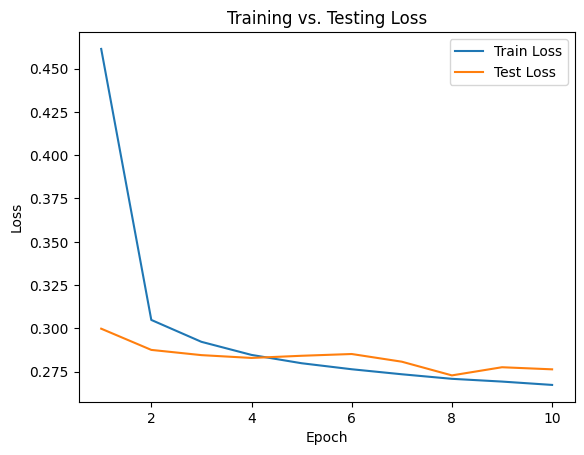

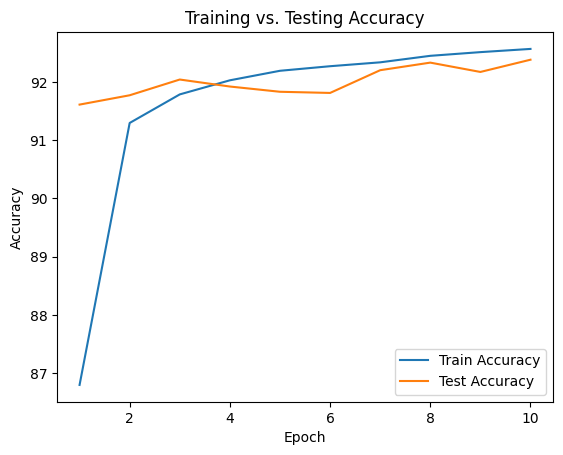

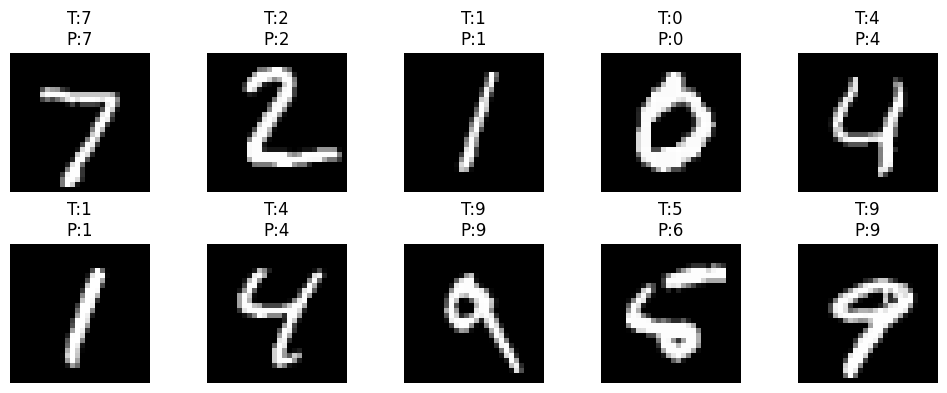

In [ ]:
from __future__ import print_function

%load_ext autoreload
%autoreload 2
from ConvNet import ConvNet
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import argparse
import numpy as np
import matplotlib.pyplot as plt


def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''

    # Set model to train mode before each epoch
    model.train()

    # Empty list to store losses
    losses = []
    correct = 0

    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample

        # Push data/label to correct device
        data, target = data.to(device), target.to(device)

        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()

        # Do forward pass for current set of data
        output = model(data)

        # ======================================================================
        # Compute loss based on criterion
        # ----------------- YOUR CODE HERE ----------------------
        loss = criterion(output, target)
        #
        # Remove NotImplementedError and assign correct loss function.
        #loss = NotImplementedError()

        # Computes gradient based on final loss
        loss.backward()

        # Store loss
        losses.append(loss.item())

        # Optimize model parameters based on learning rate and gradient
        optimizer.step()

        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # ======================================================================
        # Count correct predictions overall
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc

def test(model, device, test_loader):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''

    # Set model to eval mode to notify all layers.
    model.eval()

    losses = []
    correct = 0

    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)

            # Predict for data by doing forward pass
            output = model(data)

            # ======================================================================
            # Compute loss based on same criterion as training
            loss = F.cross_entropy(output, target, reduction='mean')

            # Append loss to overall test loss
            losses.append(loss.item())

            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # ======================================================================
            # Count correct predictions overall
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy

def run_main(FLAGS):
    # Check if cuda is available
    use_cuda = torch.cuda.is_available()

    # Set proper device based on cuda availability
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Torch device selected: ", device)

    # Initialize the model and send to device
    model = ConvNet(FLAGS.mode).to(device)

    # Initialize the criterion for loss computation
    # ======================================================================
    criterion = nn.CrossEntropyLoss()
    # Remove NotImplementedError and assign correct loss function.
    #criterion = NotImplementedError()

    # Initialize optimizer type
    optimizer = optim.SGD(model.parameters(), lr=FLAGS.learning_rate, weight_decay=1e-7)

    # Create transformations to apply to each data sample
    # Can specify variations such as image flip, color flip, random crop, ...
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    # Load datasets for training and testing
    # Inbuilt datasets available in torchvision (check documentation online)
    dataset1 = datasets.MNIST('./data/', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('./data/', train=False,
                       transform=transform)
    train_loader = DataLoader(dataset1, batch_size = FLAGS.batch_size,
                                shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset2, batch_size = FLAGS.batch_size,
                                shuffle=False, num_workers=4)

    best_accuracy = 0.0

    train_losses, test_losses = [], []
    train_accs,   test_accs   = [], []

    # Run training for n_epochs specified in config
    for epoch in range(1, FLAGS.num_epochs + 1):
        print("\nEpoch: ", epoch)
        train_loss, train_accuracy = train(model, device, train_loader,
                                            optimizer, criterion, epoch, FLAGS.batch_size)
        test_loss, test_accuracy = test(model, device, test_loader)

        train_losses.append(train_loss)
        train_accs.append(100*train_accuracy)
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

    print("accuracy is {:2.2f}".format(best_accuracy))

    print("Training and evaluation finished")

    print(f"Best test accuracy: {best_accuracy:.2f}%")




    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, FLAGS.num_epochs+1), test_losses,  label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs. Testing Loss')
    plt.legend()
    plt.show()

    # Plot accuracies
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, FLAGS.num_epochs+1), test_accs,  label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Testing Accuracy')
    plt.legend()
    plt.show()

    images, labels = next(iter(test_loader))

    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(images.to(device))
        preds   = outputs.argmax(dim=1).cpu()

    # How many to plot?
    n = images.size(0)
    cols = 5
    rows = (n + cols - 1)//cols # =2 rows for 10 images

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i, ax in enumerate(axes.flatten()):
        if i >= n:
            ax.axis('off')      # hide any extra subplots
            continue
        img = images[i].squeeze().cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(f"T:{labels[i].item()}\nP:{preds[i].item()}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # Set parameters for Sparse Autoencoder
    parser = argparse.ArgumentParser('CNN Exercise.')
    parser.add_argument('--mode',
                        type=int, default=1,
                        help='Select mode between 1-3.')
    parser.add_argument('--learning_rate',
                        type=float, default=0.005,
                        help='Initial learning rate.')
    parser.add_argument('--num_epochs',
                        type=int,
                        default=10,
                        help='Number of epochs to run trainer.')
    parser.add_argument('--batch_size',
                        type=int, default=10,
                        help='Batch size. Must divide evenly into the dataset sizes.')
    parser.add_argument('--log_dir',
                        type=str,
                        default='logs',
                        help='Directory to put logging.')

    FLAGS = None
    FLAGS, unparsed = parser.parse_known_args()

    print("Mode: ", FLAGS.mode)
    print("LR: ", FLAGS.learning_rate)
    print("Batch size: ", FLAGS.batch_size)

    run_main(FLAGS)

Similar to the last run but a little better. 0.01 LR led to more variance in test loss after epoch 4 so this is more stable and smoother. A slightly higher test accuracy. Not much better but it does generalize better. We can increase epochs but for something like a model this simple it would not improve enough to where it would be worth the extra computation for the results. We can test it but my expectations are it will not improve much if at all. Same time (5 min) as last one but epochs 5-10 were useful while in lr=0.01 it was negligible and could be left out.
Since we did get best accuracy on epoch 10 lets see if running more epochs would improve it, although it likely would be negligible and not worth the computation and time it takes, but lets test.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mode:  1
LR:  0.005
Batch size:  10
Torch device selected:  cpu

Epoch:  1
Train set: Average loss: 0.4877, Accuracy: 51362/60000 (86%)
Test set: Average loss: 0.3029, Accuracy: 9127/10000 (91%)

Epoch:  2
Train set: Average loss: 0.3061, Accuracy: 54740/60000 (91%)
Test set: Average loss: 0.2851, Accuracy: 9188/10000 (92%)

Epoch:  3
Train set: Average loss: 0.2921, Accuracy: 55008/60000 (92%)
Test set: Average loss: 0.2848, Accuracy: 9198/10000 (92%)

Epoch:  4
Train set: Average loss: 0.2848, Accuracy: 55177/60000 (92%)
Test set: Average loss: 0.2860, Accuracy: 9188/10000 (92%)

Epoch:  5
Train set: Average loss: 0.2813, Accuracy: 55279/60000 (92%)
Test set: Average loss: 0.2790, Accuracy: 9208/10000 (92%)

Epoch:  6
Train set: Average loss: 0.2760, Accuracy: 55333/60000 (92%)
Test set: Average loss: 0.2751, Accuracy: 9230/10000 (92%)

Epoch:  7
Train set: Average loss: 0.2730, Accuracy: 55422/60

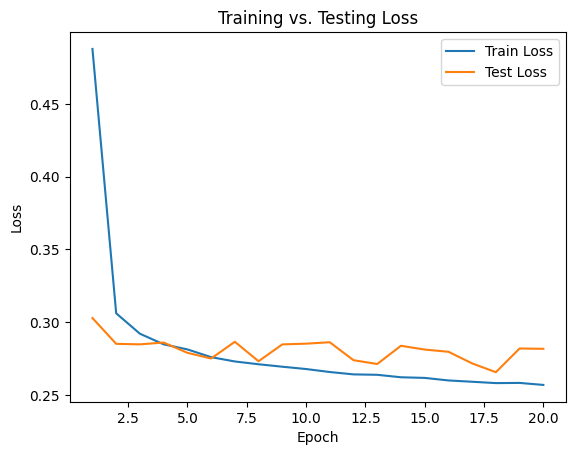

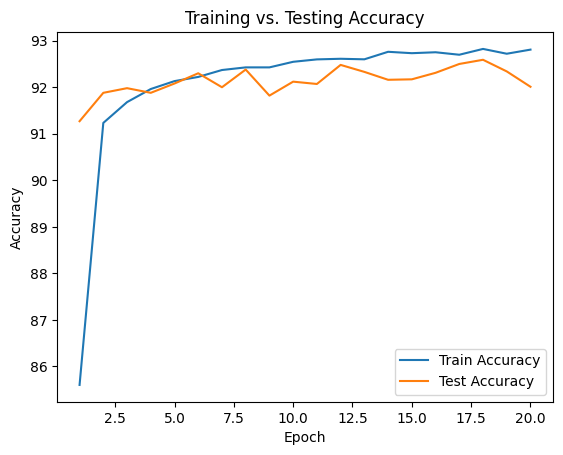

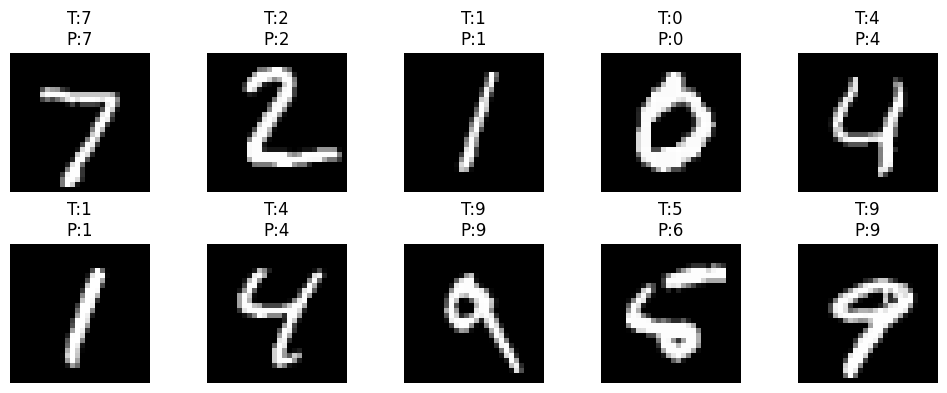

In [ ]:
from __future__ import print_function

%load_ext autoreload
%autoreload 2
from ConvNet import ConvNet
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import argparse
import numpy as np
import matplotlib.pyplot as plt


def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''

    # Set model to train mode before each epoch
    model.train()

    # Empty list to store losses
    losses = []
    correct = 0

    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample

        # Push data/label to correct device
        data, target = data.to(device), target.to(device)

        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()

        # Do forward pass for current set of data
        output = model(data)

        # ======================================================================
        # Compute loss based on criterion
        # ----------------- YOUR CODE HERE ----------------------
        loss = criterion(output, target)
        #
        # Remove NotImplementedError and assign correct loss function.
        #loss = NotImplementedError()

        # Computes gradient based on final loss
        loss.backward()

        # Store loss
        losses.append(loss.item())

        # Optimize model parameters based on learning rate and gradient
        optimizer.step()

        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # ======================================================================
        # Count correct predictions overall
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc

def test(model, device, test_loader):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''

    # Set model to eval mode to notify all layers.
    model.eval()

    losses = []
    correct = 0

    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)

            # Predict for data by doing forward pass
            output = model(data)

            # ======================================================================
            # Compute loss based on same criterion as training
            loss = F.cross_entropy(output, target, reduction='mean')

            # Append loss to overall test loss
            losses.append(loss.item())

            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # ======================================================================
            # Count correct predictions overall
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy

def run_main(FLAGS):
    # Check if cuda is available
    use_cuda = torch.cuda.is_available()

    # Set proper device based on cuda availability
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Torch device selected: ", device)

    # Initialize the model and send to device
    model = ConvNet(FLAGS.mode).to(device)

    # Initialize the criterion for loss computation
    # ======================================================================
    criterion = nn.CrossEntropyLoss()
    # Remove NotImplementedError and assign correct loss function.
    #criterion = NotImplementedError()

    # Initialize optimizer type
    optimizer = optim.SGD(model.parameters(), lr=FLAGS.learning_rate, weight_decay=1e-7)

    # Create transformations to apply to each data sample
    # Can specify variations such as image flip, color flip, random crop, ...
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    # Load datasets for training and testing
    # Inbuilt datasets available in torchvision (check documentation online)
    dataset1 = datasets.MNIST('./data/', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('./data/', train=False,
                       transform=transform)
    train_loader = DataLoader(dataset1, batch_size = FLAGS.batch_size,
                                shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset2, batch_size = FLAGS.batch_size,
                                shuffle=False, num_workers=4)

    best_accuracy = 0.0

    train_losses, test_losses = [], []
    train_accs,   test_accs   = [], []

    # Run training for n_epochs specified in config
    for epoch in range(1, FLAGS.num_epochs + 1):
        print("\nEpoch: ", epoch)
        train_loss, train_accuracy = train(model, device, train_loader,
                                            optimizer, criterion, epoch, FLAGS.batch_size)
        test_loss, test_accuracy = test(model, device, test_loader)

        train_losses.append(train_loss)
        train_accs.append(100*train_accuracy)
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

    print("accuracy is {:2.2f}".format(best_accuracy))

    print("Training and evaluation finished")

    print(f"Best test accuracy: {best_accuracy:.2f}%")




    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, FLAGS.num_epochs+1), test_losses,  label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs. Testing Loss')
    plt.legend()
    plt.show()

    # Plot accuracies
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, FLAGS.num_epochs+1), test_accs,  label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Testing Accuracy')
    plt.legend()
    plt.show()

    images, labels = next(iter(test_loader))

    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(images.to(device))
        preds   = outputs.argmax(dim=1).cpu()

    # How many to plot?
    n = images.size(0)
    cols = 5
    rows = (n + cols - 1)//cols # =2 rows for 10 images

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i, ax in enumerate(axes.flatten()):
        if i >= n:
            ax.axis('off')      # hide any extra subplots
            continue
        img = images[i].squeeze().cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(f"T:{labels[i].item()}\nP:{preds[i].item()}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # Set parameters for Sparse Autoencoder
    parser = argparse.ArgumentParser('CNN Exercise.')
    parser.add_argument('--mode',
                        type=int, default=1,
                        help='Select mode between 1-3.')
    parser.add_argument('--learning_rate',
                        type=float, default=0.005,
                        help='Initial learning rate.')
    parser.add_argument('--num_epochs',
                        type=int,
                        default=20,
                        help='Number of epochs to run trainer.')
    parser.add_argument('--batch_size',
                        type=int, default=10,
                        help='Batch size. Must divide evenly into the dataset sizes.')
    parser.add_argument('--log_dir',
                        type=str,
                        default='logs',
                        help='Directory to put logging.')

    FLAGS = None
    FLAGS, unparsed = parser.parse_known_args()

    print("Mode: ", FLAGS.mode)
    print("LR: ", FLAGS.learning_rate)
    print("Batch size: ", FLAGS.batch_size)

    run_main(FLAGS)

So as expected it improved very slightly with the extra epochs. Pretty much the same but actually with more variance in the testing loss.Prety much plateaus after 8 but there is slight improvement, but nothing that is worth the extra time and computation. I think 0.005 lr with 10 epochs is optimal for this model. It took 12 minutes so almost double time. It got a better best score but not better results than 10 epochs.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mode:  2
LR:  0.005
Batch size:  10
Torch device selected:  cpu

Epoch:  1
Train set: Average loss: 0.5624, Accuracy: 49921/60000 (83%)
Test set: Average loss: 0.2874, Accuracy: 9170/10000 (92%)

Epoch:  2
Train set: Average loss: 0.2709, Accuracy: 55256/60000 (92%)
Test set: Average loss: 0.2284, Accuracy: 9307/10000 (93%)

Epoch:  3
Train set: Average loss: 0.2235, Accuracy: 56069/60000 (93%)
Test set: Average loss: 0.2173, Accuracy: 9376/10000 (94%)

Epoch:  4
Train set: Average loss: 0.1973, Accuracy: 56531/60000 (94%)
Test set: Average loss: 0.1902, Accuracy: 9419/10000 (94%)

Epoch:  5
Train set: Average loss: 0.1777, Accuracy: 56857/60000 (95%)
Test set: Average loss: 0.1703, Accuracy: 9471/10000 (95%)

Epoch:  6
Train set: Average loss: 0.1652, Accuracy: 57035/60000 (95%)
Test set: Average loss: 0.1708, Accuracy: 9504/10000 (95%)

Epoch:  7
Train set: Average loss: 0.1561, Accuracy: 57199/60

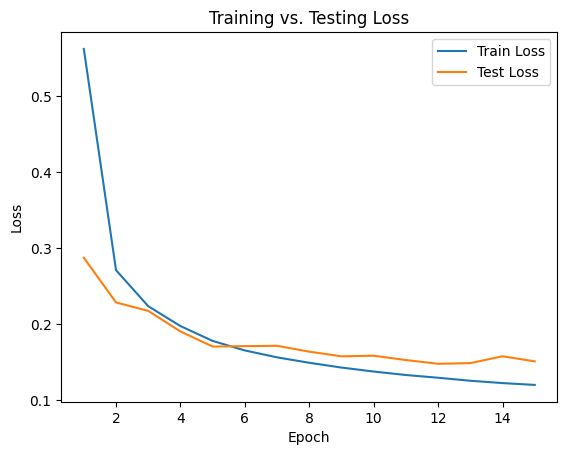

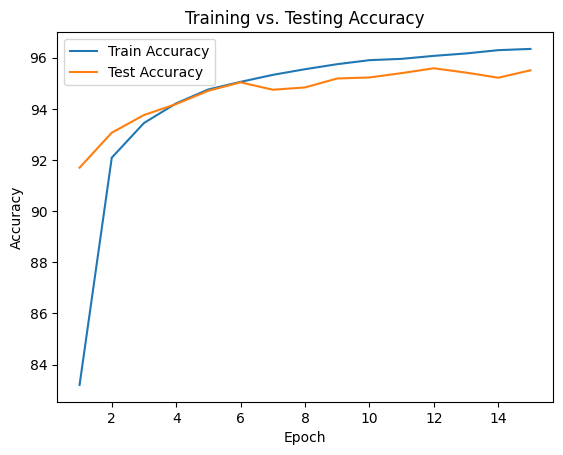

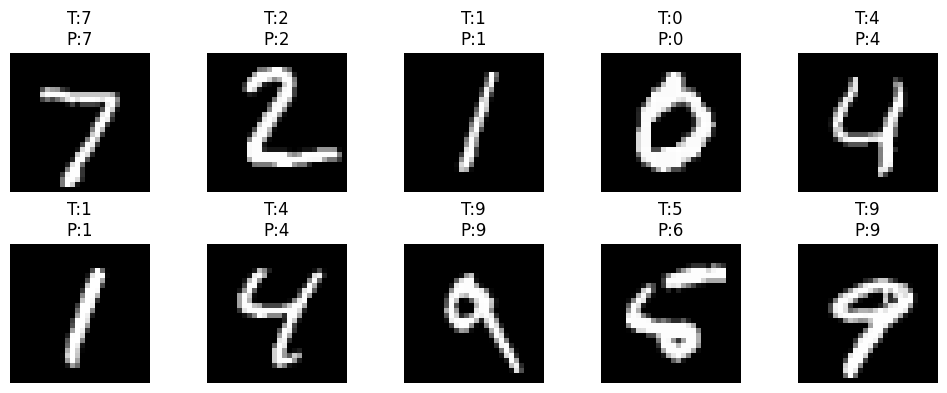

In [ ]:
from __future__ import print_function

%load_ext autoreload
%autoreload 2
from ConvNet import ConvNet
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import argparse
import numpy as np
import matplotlib.pyplot as plt


def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''

    # Set model to train mode before each epoch
    model.train()

    # Empty list to store losses
    losses = []
    correct = 0

    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample

        # Push data/label to correct device
        data, target = data.to(device), target.to(device)

        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()

        # Do forward pass for current set of data
        output = model(data)

        # ======================================================================
        # Compute loss based on criterion
        # ----------------- YOUR CODE HERE ----------------------
        loss = criterion(output, target)
        #
        # Remove NotImplementedError and assign correct loss function.
        #loss = NotImplementedError()

        # Computes gradient based on final loss
        loss.backward()

        # Store loss
        losses.append(loss.item())

        # Optimize model parameters based on learning rate and gradient
        optimizer.step()

        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # ======================================================================
        # Count correct predictions overall
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc

def test(model, device, test_loader):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''

    # Set model to eval mode to notify all layers.
    model.eval()

    losses = []
    correct = 0

    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)

            # Predict for data by doing forward pass
            output = model(data)

            # ======================================================================
            # Compute loss based on same criterion as training
            loss = F.cross_entropy(output, target, reduction='mean')

            # Append loss to overall test loss
            losses.append(loss.item())

            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # ======================================================================
            # Count correct predictions overall
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy

def run_main(FLAGS):
    # Check if cuda is available
    use_cuda = torch.cuda.is_available()

    # Set proper device based on cuda availability
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Torch device selected: ", device)

    # Initialize the model and send to device
    model = ConvNet(FLAGS.mode).to(device)

    # Initialize the criterion for loss computation
    # ======================================================================
    criterion = nn.CrossEntropyLoss()
    # Remove NotImplementedError and assign correct loss function.
    #criterion = NotImplementedError()

    # Initialize optimizer type
    optimizer = optim.SGD(model.parameters(), lr=FLAGS.learning_rate, weight_decay=1e-7)

    # Create transformations to apply to each data sample
    # Can specify variations such as image flip, color flip, random crop, ...
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    # Load datasets for training and testing
    # Inbuilt datasets available in torchvision (check documentation online)
    dataset1 = datasets.MNIST('./data/', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('./data/', train=False,
                       transform=transform)
    train_loader = DataLoader(dataset1, batch_size = FLAGS.batch_size,
                                shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset2, batch_size = FLAGS.batch_size,
                                shuffle=False, num_workers=4)

    best_accuracy = 0.0

    train_losses, test_losses = [], []
    train_accs,   test_accs   = [], []

    # Run training for n_epochs specified in config
    for epoch in range(1, FLAGS.num_epochs + 1):
        print("\nEpoch: ", epoch)
        train_loss, train_accuracy = train(model, device, train_loader,
                                            optimizer, criterion, epoch, FLAGS.batch_size)
        test_loss, test_accuracy = test(model, device, test_loader)

        train_losses.append(train_loss)
        train_accs.append(100*train_accuracy)
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

    print("accuracy is {:2.2f}".format(best_accuracy))

    print("Training and evaluation finished")

    print(f"Best test accuracy: {best_accuracy:.2f}%")




    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, FLAGS.num_epochs+1), test_losses,  label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs. Testing Loss')
    plt.legend()
    plt.show()

    # Plot accuracies
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, FLAGS.num_epochs+1), test_accs,  label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Testing Accuracy')
    plt.legend()
    plt.show()

    images, labels = next(iter(test_loader))

    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(images.to(device))
        preds   = outputs.argmax(dim=1).cpu()

    # How many to plot?
    n = images.size(0)
    cols = 5
    rows = (n + cols - 1)//cols # =2 rows for 10 images

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i, ax in enumerate(axes.flatten()):
        if i >= n:
            ax.axis('off')      # hide any extra subplots
            continue
        img = images[i].squeeze().cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(f"T:{labels[i].item()}\nP:{preds[i].item()}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # Set parameters for Sparse Autoencoder
    parser = argparse.ArgumentParser('CNN Exercise.')
    parser.add_argument('--mode',
                        type=int, default=2,
                        help='Select mode between 1-3.')
    parser.add_argument('--learning_rate',
                        type=float, default=0.005,
                        help='Initial learning rate.')
    parser.add_argument('--num_epochs',
                        type=int,
                        default=15,
                        help='Number of epochs to run trainer.')
    parser.add_argument('--batch_size',
                        type=int, default=10,
                        help='Batch size. Must divide evenly into the dataset sizes.')
    parser.add_argument('--log_dir',
                        type=str,
                        default='logs',
                        help='Directory to put logging.')

    FLAGS = None
    FLAGS, unparsed = parser.parse_known_args()

    print("Mode: ", FLAGS.mode)
    print("LR: ", FLAGS.learning_rate)
    print("Batch size: ", FLAGS.batch_size)

    run_main(FLAGS)

So adding ReLU definetely improved the results. We stablize around 95-96% which is better. It did converge after about 10 epochs and also does seem to have less variance than model 1. Not much overfitting and generalizes well for a model of this architecture. Lets see what a slightly higher lr will do with the same epochs so we can analyze and see if improvements are possible from a higher lr.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mode:  2
LR:  0.008
Batch size:  10
Torch device selected:  cpu

Epoch:  1
Train set: Average loss: 0.4696, Accuracy: 51564/60000 (86%)
Test set: Average loss: 0.2557, Accuracy: 9265/10000 (93%)

Epoch:  2
Train set: Average loss: 0.2355, Accuracy: 55785/60000 (93%)
Test set: Average loss: 0.2230, Accuracy: 9343/10000 (93%)

Epoch:  3
Train set: Average loss: 0.1928, Accuracy: 56580/60000 (94%)
Test set: Average loss: 0.1817, Accuracy: 9455/10000 (95%)

Epoch:  4
Train set: Average loss: 0.1702, Accuracy: 56950/60000 (95%)
Test set: Average loss: 0.1639, Accuracy: 9500/10000 (95%)

Epoch:  5
Train set: Average loss: 0.1563, Accuracy: 57163/60000 (95%)
Test set: Average loss: 0.1698, Accuracy: 9476/10000 (95%)

Epoch:  6
Train set: Average loss: 0.1463, Accuracy: 57319/60000 (96%)
Test set: Average loss: 0.1752, Accuracy: 9458/10000 (95%)

Epoch:  7
Train set: Average loss: 0.1379, Accuracy: 57538/60

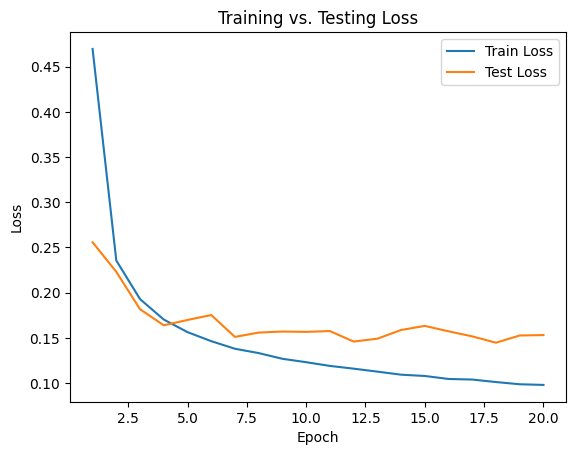

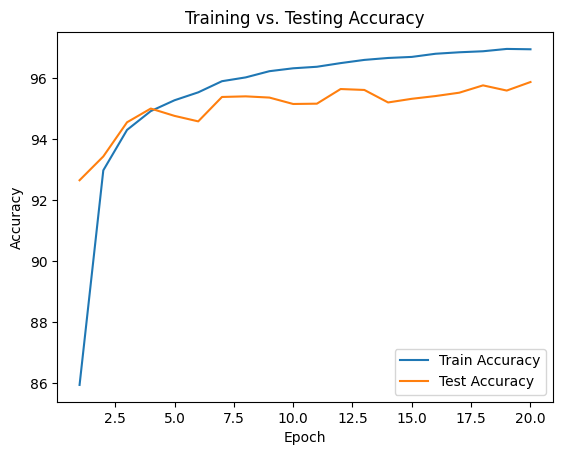

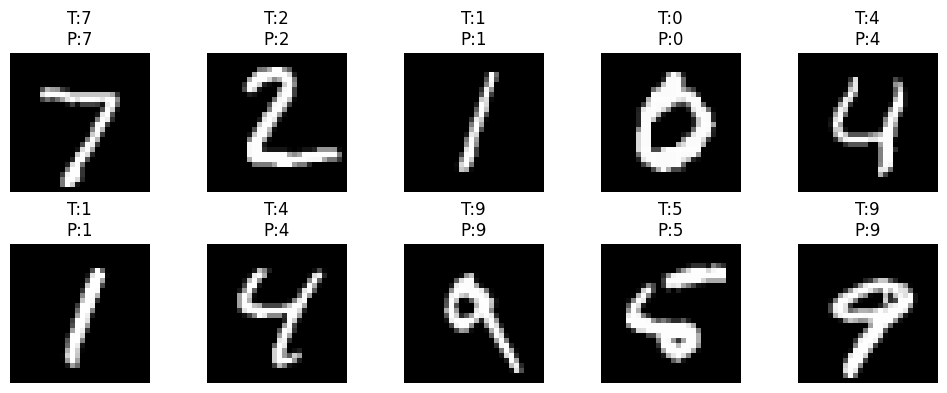

In [ ]:
from __future__ import print_function

%load_ext autoreload
%autoreload 2
from ConvNet import ConvNet
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import argparse
import numpy as np
import matplotlib.pyplot as plt


def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''

    # Set model to train mode before each epoch
    model.train()

    # Empty list to store losses
    losses = []
    correct = 0

    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample

        # Push data/label to correct device
        data, target = data.to(device), target.to(device)

        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()

        # Do forward pass for current set of data
        output = model(data)

        # ======================================================================
        # Compute loss based on criterion
        # ----------------- YOUR CODE HERE ----------------------
        loss = criterion(output, target)
        #
        # Remove NotImplementedError and assign correct loss function.
        #loss = NotImplementedError()

        # Computes gradient based on final loss
        loss.backward()

        # Store loss
        losses.append(loss.item())

        # Optimize model parameters based on learning rate and gradient
        optimizer.step()

        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # ======================================================================
        # Count correct predictions overall
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc

def test(model, device, test_loader):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''

    # Set model to eval mode to notify all layers.
    model.eval()

    losses = []
    correct = 0

    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)

            # Predict for data by doing forward pass
            output = model(data)

            # ======================================================================
            # Compute loss based on same criterion as training
            loss = F.cross_entropy(output, target, reduction='mean')

            # Append loss to overall test loss
            losses.append(loss.item())

            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # ======================================================================
            # Count correct predictions overall
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy

def run_main(FLAGS):
    # Check if cuda is available
    use_cuda = torch.cuda.is_available()

    # Set proper device based on cuda availability
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Torch device selected: ", device)

    # Initialize the model and send to device
    model = ConvNet(FLAGS.mode).to(device)

    # Initialize the criterion for loss computation
    # ======================================================================
    criterion = nn.CrossEntropyLoss()
    # Remove NotImplementedError and assign correct loss function.
    #criterion = NotImplementedError()

    # Initialize optimizer type
    optimizer = optim.SGD(model.parameters(), lr=FLAGS.learning_rate, weight_decay=1e-7)

    # Create transformations to apply to each data sample
    # Can specify variations such as image flip, color flip, random crop, ...
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    # Load datasets for training and testing
    # Inbuilt datasets available in torchvision (check documentation online)
    dataset1 = datasets.MNIST('./data/', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('./data/', train=False,
                       transform=transform)
    train_loader = DataLoader(dataset1, batch_size = FLAGS.batch_size,
                                shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset2, batch_size = FLAGS.batch_size,
                                shuffle=False, num_workers=4)

    best_accuracy = 0.0

    train_losses, test_losses = [], []
    train_accs,   test_accs   = [], []

    # Run training for n_epochs specified in config
    for epoch in range(1, FLAGS.num_epochs + 1):
        print("\nEpoch: ", epoch)
        train_loss, train_accuracy = train(model, device, train_loader,
                                            optimizer, criterion, epoch, FLAGS.batch_size)
        test_loss, test_accuracy = test(model, device, test_loader)

        train_losses.append(train_loss)
        train_accs.append(100*train_accuracy)
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

    print("accuracy is {:2.2f}".format(best_accuracy))

    print("Training and evaluation finished")

    print(f"Best test accuracy: {best_accuracy:.2f}%")




    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, FLAGS.num_epochs+1), test_losses,  label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs. Testing Loss')
    plt.legend()
    plt.show()

    # Plot accuracies
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, FLAGS.num_epochs+1), test_accs,  label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Testing Accuracy')
    plt.legend()
    plt.show()

    images, labels = next(iter(test_loader))

    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(images.to(device))
        preds   = outputs.argmax(dim=1).cpu()

    # How many to plot?
    n = images.size(0)
    cols = 5
    rows = (n + cols - 1)//cols # =2 rows for 10 images

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i, ax in enumerate(axes.flatten()):
        if i >= n:
            ax.axis('off')      # hide any extra subplots
            continue
        img = images[i].squeeze().cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(f"T:{labels[i].item()}\nP:{preds[i].item()}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # Set parameters for Sparse Autoencoder
    parser = argparse.ArgumentParser('CNN Exercise.')
    parser.add_argument('--mode',
                        type=int, default=2,
                        help='Select mode between 1-3.')
    parser.add_argument('--learning_rate',
                        type=float, default=0.008,
                        help='Initial learning rate.')
    parser.add_argument('--num_epochs',
                        type=int,
                        default=20,
                        help='Number of epochs to run trainer.')
    parser.add_argument('--batch_size',
                        type=int, default=10,
                        help='Batch size. Must divide evenly into the dataset sizes.')
    parser.add_argument('--log_dir',
                        type=str,
                        default='logs',
                        help='Directory to put logging.')

    FLAGS = None
    FLAGS, unparsed = parser.parse_known_args()

    print("Mode: ", FLAGS.mode)
    print("LR: ", FLAGS.learning_rate)
    print("Batch size: ", FLAGS.batch_size)

    run_main(FLAGS)

It didnt improve much, we plateau around epoch 5 and very slightly improve after. There is also some variance for these parameters although not too much. I think we need a lr inbetween what we did and since it was still slightly improving well give it some more epochs. This is very good results for a model like this, still relatively simple. Lets see if we can improve. This took about 12 minutes to run.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mode:  2
LR:  0.0063
Batch size:  10
Torch device selected:  cpu

Epoch:  1
Train set: Average loss: 0.5165, Accuracy: 50702/60000 (85%)
Test set: Average loss: 0.2722, Accuracy: 9199/10000 (92%)

Epoch:  2
Train set: Average loss: 0.2345, Accuracy: 55868/60000 (93%)
Test set: Average loss: 0.1973, Accuracy: 9411/10000 (94%)

Epoch:  3
Train set: Average loss: 0.1880, Accuracy: 56635/60000 (94%)
Test set: Average loss: 0.1712, Accuracy: 9488/10000 (95%)

Epoch:  4
Train set: Average loss: 0.1669, Accuracy: 57025/60000 (95%)
Test set: Average loss: 0.1574, Accuracy: 9554/10000 (96%)

Epoch:  5
Train set: Average loss: 0.1565, Accuracy: 57159/60000 (95%)
Test set: Average loss: 0.1508, Accuracy: 9567/10000 (96%)

Epoch:  6
Train set: Average loss: 0.1460, Accuracy: 57322/60000 (96%)
Test set: Average loss: 0.1528, Accuracy: 9546/10000 (95%)

Epoch:  7
Train set: Average loss: 0.1406, Accuracy: 57428/6

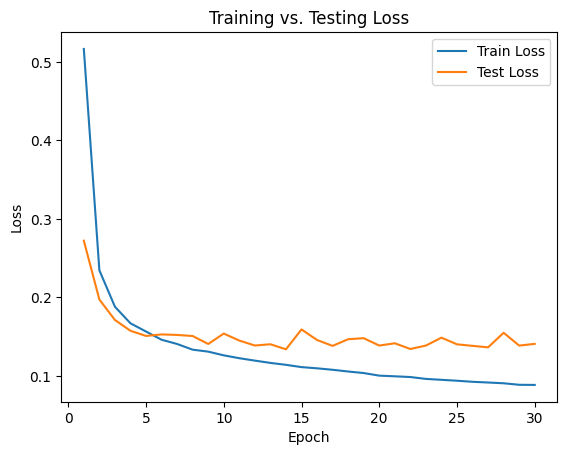

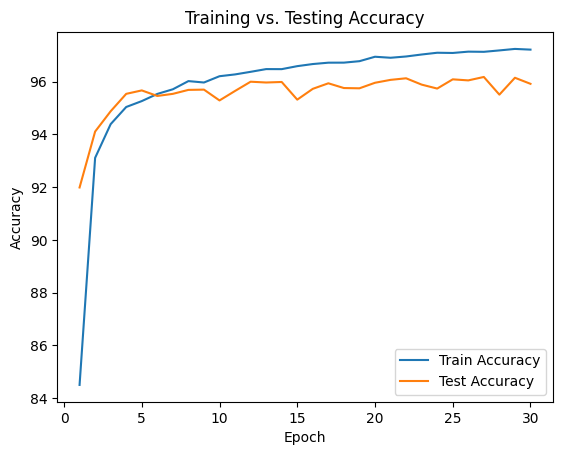

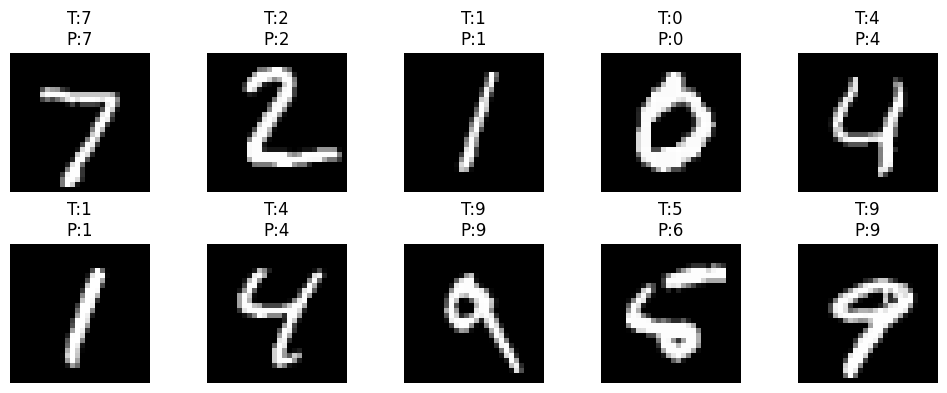

In [ ]:
from __future__ import print_function

%load_ext autoreload
%autoreload 2
from ConvNet import ConvNet
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import argparse
import numpy as np
import matplotlib.pyplot as plt


def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''

    # Set model to train mode before each epoch
    model.train()

    # Empty list to store losses
    losses = []
    correct = 0

    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample

        # Push data/label to correct device
        data, target = data.to(device), target.to(device)

        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()

        # Do forward pass for current set of data
        output = model(data)

        # ======================================================================
        # Compute loss based on criterion
        # ----------------- YOUR CODE HERE ----------------------
        loss = criterion(output, target)
        #
        # Remove NotImplementedError and assign correct loss function.
        #loss = NotImplementedError()

        # Computes gradient based on final loss
        loss.backward()

        # Store loss
        losses.append(loss.item())

        # Optimize model parameters based on learning rate and gradient
        optimizer.step()

        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # ======================================================================
        # Count correct predictions overall
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc

def test(model, device, test_loader):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''

    # Set model to eval mode to notify all layers.
    model.eval()

    losses = []
    correct = 0

    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)

            # Predict for data by doing forward pass
            output = model(data)

            # ======================================================================
            # Compute loss based on same criterion as training
            loss = F.cross_entropy(output, target, reduction='mean')

            # Append loss to overall test loss
            losses.append(loss.item())

            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # ======================================================================
            # Count correct predictions overall
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy

def run_main(FLAGS):
    # Check if cuda is available
    use_cuda = torch.cuda.is_available()

    # Set proper device based on cuda availability
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Torch device selected: ", device)

    # Initialize the model and send to device
    model = ConvNet(FLAGS.mode).to(device)

    # Initialize the criterion for loss computation
    # ======================================================================
    criterion = nn.CrossEntropyLoss()
    # Remove NotImplementedError and assign correct loss function.
    #criterion = NotImplementedError()

    # Initialize optimizer type
    optimizer = optim.SGD(model.parameters(), lr=FLAGS.learning_rate, weight_decay=1e-7)

    # Create transformations to apply to each data sample
    # Can specify variations such as image flip, color flip, random crop, ...
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    # Load datasets for training and testing
    # Inbuilt datasets available in torchvision (check documentation online)
    dataset1 = datasets.MNIST('./data/', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('./data/', train=False,
                       transform=transform)
    train_loader = DataLoader(dataset1, batch_size = FLAGS.batch_size,
                                shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset2, batch_size = FLAGS.batch_size,
                                shuffle=False, num_workers=4)

    best_accuracy = 0.0

    train_losses, test_losses = [], []
    train_accs,   test_accs   = [], []

    # Run training for n_epochs specified in config
    for epoch in range(1, FLAGS.num_epochs + 1):
        print("\nEpoch: ", epoch)
        train_loss, train_accuracy = train(model, device, train_loader,
                                            optimizer, criterion, epoch, FLAGS.batch_size)
        test_loss, test_accuracy = test(model, device, test_loader)

        train_losses.append(train_loss)
        train_accs.append(100*train_accuracy)
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

    print("accuracy is {:2.2f}".format(best_accuracy))

    print("Training and evaluation finished")

    print(f"Best test accuracy: {best_accuracy:.2f}%")




    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, FLAGS.num_epochs+1), test_losses,  label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs. Testing Loss')
    plt.legend()
    plt.show()

    # Plot accuracies
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, FLAGS.num_epochs+1), test_accs,  label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Testing Accuracy')
    plt.legend()
    plt.show()

    images, labels = next(iter(test_loader))

    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(images.to(device))
        preds   = outputs.argmax(dim=1).cpu()


    n = images.size(0)
    cols = 5
    rows = (n + cols - 1)//cols # =2 rows for 10 images

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i, ax in enumerate(axes.flatten()):
        if i >= n:
            ax.axis('off')      # hide any extra subplots
            continue
        img = images[i].squeeze().cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(f"T:{labels[i].item()}\nP:{preds[i].item()}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # Set parameters for Sparse Autoencoder
    parser = argparse.ArgumentParser('CNN Exercise.')
    parser.add_argument('--mode',
                        type=int, default=2,
                        help='Select mode between 1-3.')
    parser.add_argument('--learning_rate',
                        type=float, default=0.0063,
                        help='Initial learning rate.')
    parser.add_argument('--num_epochs',
                        type=int,
                        default=30,
                        help='Number of epochs to run trainer.')
    parser.add_argument('--batch_size',
                        type=int, default=10,
                        help='Batch size. Must divide evenly into the dataset sizes.')
    parser.add_argument('--log_dir',
                        type=str,
                        default='logs',
                        help='Directory to put logging.')

    FLAGS = None
    FLAGS, unparsed = parser.parse_known_args()

    print("Mode: ", FLAGS.mode)
    print("LR: ", FLAGS.learning_rate)
    print("Batch size: ", FLAGS.batch_size)

    run_main(FLAGS)

So we improved a little here. Better accuracy and pretty much the same test loss and accuracy variancy. Pretty steadily climb and plateau around epoch 20. It does peak test accuracy at 27, 96.18% but does fluctuate after. No signs of overfitting and generalizes well. This took about 17 minutes and did improve from the last so good sign. May be hard to get much better than this for this architecture.

Note: These next cells below until model 3 I ran with neurons more than allowed from the assignment, but it is good results and good information that helped me test and understand these networks better so ill keep them in here. But they are not necessarily part of the project.

In [ ]:
%%writefile ConvNet.py


import time
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self, mode):
        super(ConvNet, self).__init__()

        # Define various layers here
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 10)

        # This will select the forward pass function based on mode for the ConvNet.
        # During creation of each ConvNet model, you will assign one of the valid mode.
        # This will fix the forward function (and the network graph) for the entire training/testing

        if mode == 1:
            self.forward = self.model_1
        elif mode == 2:
            self.forward = self.model_2
        elif mode == 3:
            self.forward = self.model_3
        else:
            print("Invalid mode ", mode, "selected. Select between 1-3")
            exit(0)

    # Baseline sample model
    def model_0(self, X):
        # ======================================================================
        # Three fully connected layers with activation

        X = torch.flatten(X, start_dim=1)
        X = self.fc1(X)#first layer + ReLU
        X = F.relu(X) #negs to 0, gets non-linearity
        X = self.fc2(X) #second layer + ReLU
        X = F.relu(X)
        X = self.fc3(X) #final lin layer
        X = torch.sigmoid(X) #sigmoid act

        return X

    # Baseline model. task 1
    def model_1(self, X):
        # ======================================================================
        # Three fully connected layers without activation

        X = torch.flatten(X, start_dim=1)
        X = self.fc1(X)
        X = self.fc2(X)
        X = self.fc3(X)
        return X
        # NotImplementedError

        return X


    # task 2
    def model_2(self, X):
        # ======================================================================
        # Train with activation (use model 1 from task 1)

        X = torch.flatten(X, start_dim=1)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        # NotImplementedError

        return X


    # task 3
    def model_3(self, X):
        # ======================================================================
        # Change number of fully connected layers and number of neurons from model 2 in task 2

        X = torch.flatten(X, start_dim=1)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = F.relu(self.fc4(X))
        X = self.fc5(X)
        # NotImplementedError

        return X







Overwriting ConvNet.py


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mode:  1
LR:  0.1
Batch size:  10
Torch device selected:  cpu

Epoch:  1
Train set: Average loss: 1.0058, Accuracy: 44898/60000 (75%)
Test set: Average loss: 0.8639, Accuracy: 7703/10000 (77%)

Epoch:  2
Train set: Average loss: nan, Accuracy: 12979/60000 (22%)
Test set: Average loss: nan, Accuracy: 980/10000 (10%)

Epoch:  3
Train set: Average loss: nan, Accuracy: 5923/60000 (10%)
Test set: Average loss: nan, Accuracy: 980/10000 (10%)

Epoch:  4
Train set: Average loss: nan, Accuracy: 5923/60000 (10%)
Test set: Average loss: nan, Accuracy: 980/10000 (10%)

Epoch:  5
Train set: Average loss: nan, Accuracy: 5923/60000 (10%)
Test set: Average loss: nan, Accuracy: 980/10000 (10%)

Epoch:  6
Train set: Average loss: nan, Accuracy: 5923/60000 (10%)
Test set: Average loss: nan, Accuracy: 980/10000 (10%)

Epoch:  7
Train set: Average loss: nan, Accuracy: 5923/60000 (10%)
Test set: Average loss: nan, Accura

ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

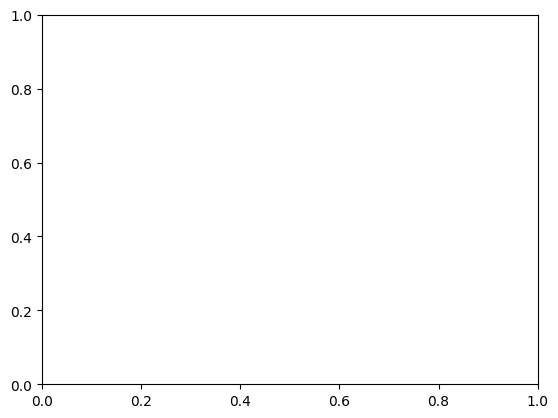

In [ ]:
from __future__ import print_function

%load_ext autoreload
%autoreload 2
from ConvNet import ConvNet
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import argparse
import numpy as np
import matplotlib.pyplot as plt


def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''

    # Set model to train mode before each epoch
    model.train()

    # Empty list to store losses
    losses = []
    correct = 0

    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample

        # Push data/label to correct device
        data, target = data.to(device), target.to(device)

        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()

        # Do forward pass for current set of data
        output = model(data)

        # ======================================================================
        # Compute loss based on criterion
        # ----------------- YOUR CODE HERE ----------------------
        loss = criterion(output, target)
        #
        # Remove NotImplementedError and assign correct loss function.
        #loss = NotImplementedError()

        # Computes gradient based on final loss
        loss.backward()

        # Store loss
        losses.append(loss.item())

        # Optimize model parameters based on learning rate and gradient
        optimizer.step()

        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # ======================================================================
        # Count correct predictions overall
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc

def test(model, device, test_loader):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''

    # Set model to eval mode to notify all layers.
    model.eval()

    losses = []
    correct = 0

    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)

            # Predict for data by doing forward pass
            output = model(data)

            # ======================================================================
            # Compute loss based on same criterion as training
            loss = F.cross_entropy(output, target, reduction='mean')

            # Append loss to overall test loss
            losses.append(loss.item())

            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # ======================================================================
            # Count correct predictions overall
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy

def run_main(FLAGS):
    # Check if cuda is available
    use_cuda = torch.cuda.is_available()

    # Set proper device based on cuda availability
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Torch device selected: ", device)

    # Initialize the model and send to device
    model = ConvNet(FLAGS.mode).to(device)

    # Initialize the criterion for loss computation
    # ======================================================================
    criterion = nn.CrossEntropyLoss()
    # Remove NotImplementedError and assign correct loss function.
    #criterion = NotImplementedError()

    # Initialize optimizer type
    optimizer = optim.SGD(model.parameters(), lr=FLAGS.learning_rate, weight_decay=1e-7)

    # Create transformations to apply to each data sample
    # Can specify variations such as image flip, color flip, random crop, ...
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    # Load datasets for training and testing
    # Inbuilt datasets available in torchvision (check documentation online)
    dataset1 = datasets.MNIST('./data/', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('./data/', train=False,
                       transform=transform)
    train_loader = DataLoader(dataset1, batch_size = FLAGS.batch_size,
                                shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset2, batch_size = FLAGS.batch_size,
                                shuffle=False, num_workers=4)

    best_accuracy = 0.0

    train_losses, test_losses = [], []
    train_accs,   test_accs   = [], []

    # Run training for n_epochs specified in config
    for epoch in range(1, FLAGS.num_epochs + 1):
        print("\nEpoch: ", epoch)
        train_loss, train_accuracy = train(model, device, train_loader,
                                            optimizer, criterion, epoch, FLAGS.batch_size)
        test_loss, test_accuracy = test(model, device, test_loader)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

    print("accuracy is {:2.2f}".format(best_accuracy))

    print("Training and evaluation finished")

    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, FLAGS.num_epochs+1), test_losses,  label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs. Testing Loss')
    plt.legend()
    plt.show()

    # Plot accuracies
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, FLAGS.num_epochs+1), test_accs,  label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Testing Accuracy')
    plt.legend()
    plt.show()

if __name__ == '__main__':
    # Set parameters for Sparse Autoencoder
    parser = argparse.ArgumentParser('CNN Exercise.')
    parser.add_argument('--mode',
                        type=int, default=1,
                        help='Select mode between 1-3.')
    parser.add_argument('--learning_rate',
                        type=float, default=0.1,
                        help='Initial learning rate.')
    parser.add_argument('--num_epochs',
                        type=int,
                        default=20,
                        help='Number of epochs to run trainer.')
    parser.add_argument('--batch_size',
                        type=int, default=10,
                        help='Batch size. Must divide evenly into the dataset sizes.')
    parser.add_argument('--log_dir',
                        type=str,
                        default='logs',
                        help='Directory to put logging.')

    FLAGS = None
    FLAGS, unparsed = parser.parse_known_args()

    print("Mode: ", FLAGS.mode)
    print("LR: ", FLAGS.learning_rate)
    print("Batch size: ", FLAGS.batch_size)

    run_main(FLAGS)

learning rate is way too high for just 3 linear layers. Results immediately diverge and can see is getting accuracy of 10% which is the same as random. This took about 20 minutes but same results of just random from beginning to end


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mode:  1
LR:  0.001
Batch size:  10
Torch device selected:  cpu

Epoch:  1
Train set: Average loss: 0.7411, Accuracy: 48706/60000 (81%)
Test set: Average loss: 0.3796, Accuracy: 8938/10000 (89%)

Epoch:  2
Train set: Average loss: 0.3616, Accuracy: 53833/60000 (90%)
Test set: Average loss: 0.3217, Accuracy: 9081/10000 (91%)

Epoch:  3
Train set: Average loss: 0.3251, Accuracy: 54364/60000 (91%)
Test set: Average loss: 0.3019, Accuracy: 9151/10000 (92%)

Epoch:  4
Train set: Average loss: 0.3086, Accuracy: 54636/60000 (91%)
Test set: Average loss: 0.2928, Accuracy: 9149/10000 (91%)

Epoch:  5
Train set: Average loss: 0.2991, Accuracy: 54845/60000 (91%)
Test set: Average loss: 0.2884, Accuracy: 9177/10000 (92%)

Epoch:  6
Train set: Average loss: 0.2922, Accuracy: 54983/60000 (92%)
Test set: Average loss: 0.2860, Accuracy: 9200/10000 (92%)

Epoch:  7
Train set: Average loss: 0.2870, Accuracy: 55095/60

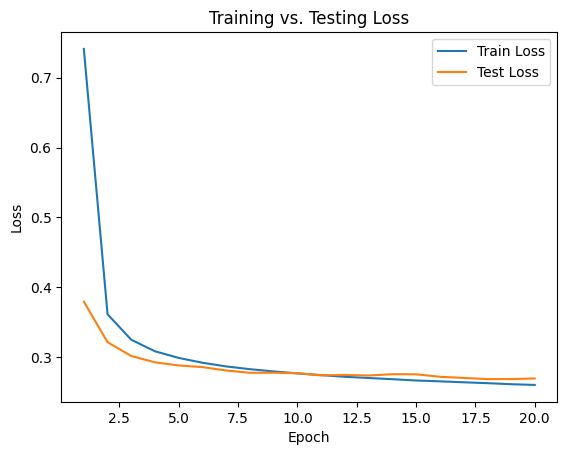

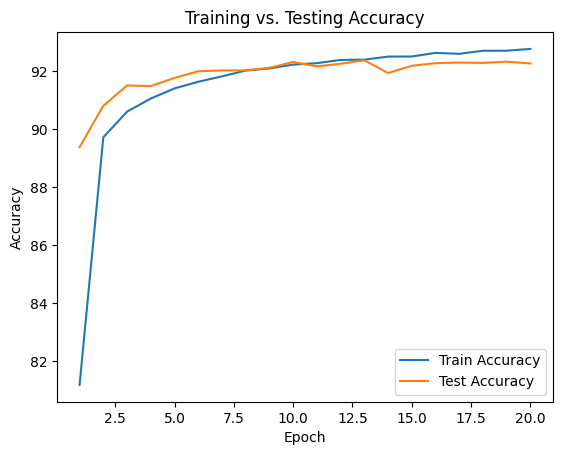

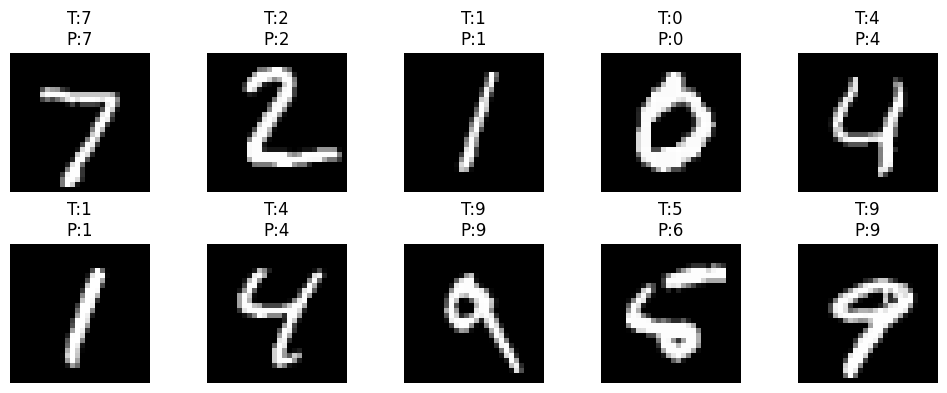

In [ ]:
from __future__ import print_function

%load_ext autoreload
%autoreload 2
from ConvNet import ConvNet
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import argparse
import numpy as np
import matplotlib.pyplot as plt


def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''

    # Set model to train mode before each epoch
    model.train()

    # Empty list to store losses
    losses = []
    correct = 0

    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample

        # Push data/label to correct device
        data, target = data.to(device), target.to(device)

        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()

        # Do forward pass for current set of data
        output = model(data)

        # ======================================================================
        # Compute loss based on criterion
        # ----------------- YOUR CODE HERE ----------------------
        loss = criterion(output, target)
        #
        # Remove NotImplementedError and assign correct loss function.
        #loss = NotImplementedError()

        # Computes gradient based on final loss
        loss.backward()

        # Store loss
        losses.append(loss.item())

        # Optimize model parameters based on learning rate and gradient
        optimizer.step()

        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # ======================================================================
        # Count correct predictions overall
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc

def test(model, device, test_loader):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''

    # Set model to eval mode to notify all layers.
    model.eval()

    losses = []
    correct = 0

    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)

            # Predict for data by doing forward pass
            output = model(data)

            # ======================================================================
            # Compute loss based on same criterion as training
            loss = F.cross_entropy(output, target, reduction='mean')

            # Append loss to overall test loss
            losses.append(loss.item())

            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # ======================================================================
            # Count correct predictions overall
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy

def run_main(FLAGS):
    # Check if cuda is available
    use_cuda = torch.cuda.is_available()

    # Set proper device based on cuda availability
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Torch device selected: ", device)

    # Initialize the model and send to device
    model = ConvNet(FLAGS.mode).to(device)

    # Initialize the criterion for loss computation
    # ======================================================================
    criterion = nn.CrossEntropyLoss()
    # Remove NotImplementedError and assign correct loss function.
    #criterion = NotImplementedError()

    # Initialize optimizer type
    optimizer = optim.SGD(model.parameters(), lr=FLAGS.learning_rate, weight_decay=1e-7)

    # Create transformations to apply to each data sample
    # Can specify variations such as image flip, color flip, random crop, ...
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    # Load datasets for training and testing
    # Inbuilt datasets available in torchvision (check documentation online)
    dataset1 = datasets.MNIST('./data/', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('./data/', train=False,
                       transform=transform)
    train_loader = DataLoader(dataset1, batch_size = FLAGS.batch_size,
                                shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset2, batch_size = FLAGS.batch_size,
                                shuffle=False, num_workers=4)

    best_accuracy = 0.0

    train_losses, test_losses = [], []
    train_accs,   test_accs   = [], []

    # Run training for n_epochs specified in config
    for epoch in range(1, FLAGS.num_epochs + 1):
        print("\nEpoch: ", epoch)
        train_loss, train_accuracy = train(model, device, train_loader,
                                            optimizer, criterion, epoch, FLAGS.batch_size)
        test_loss, test_accuracy = test(model, device, test_loader)

        train_losses.append(train_loss)
        train_accs.append(100*train_accuracy)
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

    print("accuracy is {:2.2f}".format(best_accuracy))

    print("Training and evaluation finished")

    print(f"Best test accuracy: {best_accuracy:.2f}%")




    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, FLAGS.num_epochs+1), test_losses,  label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs. Testing Loss')
    plt.legend()
    plt.show()


    # Plot accuracies
    # Plot accuracies
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, FLAGS.num_epochs+1), test_accs,  label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Testing Accuracy')
    plt.legend()
    plt.show()

    images, labels = next(iter(test_loader))

    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(images.to(device))
        preds   = outputs.argmax(dim=1).cpu()


    n = images.size(0)
    cols = 5
    rows = (n + cols - 1)//cols # =2 rows for 10 images

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i, ax in enumerate(axes.flatten()):
        if i >= n:
            ax.axis('off')      # hide any extra subplots
            continue
        img = images[i].squeeze().cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(f"T:{labels[i].item()}\nP:{preds[i].item()}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # Set parameters for Sparse Autoencoder
    parser = argparse.ArgumentParser('CNN Exercise.')
    parser.add_argument('--mode',
                        type=int, default=1,
                        help='Select mode between 1-3.')
    parser.add_argument('--learning_rate',
                        type=float, default=0.001,
                        help='Initial learning rate.')
    parser.add_argument('--num_epochs',
                        type=int,
                        default=20,
                        help='Number of epochs to run trainer.')
    parser.add_argument('--batch_size',
                        type=int, default=10,
                        help='Batch size. Must divide evenly into the dataset sizes.')
    parser.add_argument('--log_dir',
                        type=str,
                        default='logs',
                        help='Directory to put logging.')

    FLAGS = None
    FLAGS, unparsed = parser.parse_known_args()

    print("Mode: ", FLAGS.mode)
    print("LR: ", FLAGS.learning_rate)
    print("Batch size: ", FLAGS.batch_size)

    run_main(FLAGS)

So we updated our learning rate to 0.001 and it greatly increased results plateuing at an accuracy around 92% after building from bout 82%. Train loss going from 0.73 to 0.26 is a good sign, steadily reducing its average error. Same for test loss going from 0.38 to 0.27 meaning it is getting better at unseen data. Our training and testign accuracy being 92 and 93 % is also good, as this small gap means it is not overfitting, and is generalizing well. Ill try to further improve accuracy by decreasing the lr some more and increasing epochs to give the smaller lr more time to improve. This took about 15 minutes and is pretty good results for a simple model like this.

In [ ]:
from __future__ import print_function

%load_ext autoreload
%autoreload 2
from ConvNet import ConvNet
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import argparse
import numpy as np

def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''

    # Set model to train mode before each epoch
    model.train()

    # Empty list to store losses
    losses = []
    correct = 0

    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample

        # Push data/label to correct device
        data, target = data.to(device), target.to(device)

        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()

        # Do forward pass for current set of data
        output = model(data)

        # ======================================================================
        # Compute loss based on criterion
        # ----------------- YOUR CODE HERE ----------------------
        loss = criterion(output, target)
        #
        # Remove NotImplementedError and assign correct loss function.
        #loss = NotImplementedError()

        # Computes gradient based on final loss
        loss.backward()

        # Store loss
        losses.append(loss.item())

        # Optimize model parameters based on learning rate and gradient
        optimizer.step()

        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # ======================================================================
        # Count correct predictions overall
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc

def test(model, device, test_loader):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''

    # Set model to eval mode to notify all layers.
    model.eval()

    losses = []
    correct = 0

    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)

            # Predict for data by doing forward pass
            output = model(data)

            # ======================================================================
            # Compute loss based on same criterion as training
            loss = F.cross_entropy(output, target, reduction='mean')

            # Append loss to overall test loss
            losses.append(loss.item())

            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # ======================================================================
            # Count correct predictions overall
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy

def run_main(FLAGS):
    # Check if cuda is available
    use_cuda = torch.cuda.is_available()

    # Set proper device based on cuda availability
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Torch device selected: ", device)

    # Initialize the model and send to device
    model = ConvNet(FLAGS.mode).to(device)

    # Initialize the criterion for loss computation
    # ======================================================================
    criterion = nn.CrossEntropyLoss()
    # Remove NotImplementedError and assign correct loss function.
    #criterion = NotImplementedError()

    # Initialize optimizer type
    optimizer = optim.SGD(model.parameters(), lr=FLAGS.learning_rate, weight_decay=1e-7)

    # Create transformations to apply to each data sample
    # Can specify variations such as image flip, color flip, random crop, ...
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    # Load datasets for training and testing
    # Inbuilt datasets available in torchvision (check documentation online)
    dataset1 = datasets.MNIST('./data/', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('./data/', train=False,
                       transform=transform)
    train_loader = DataLoader(dataset1, batch_size = FLAGS.batch_size,
                                shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset2, batch_size = FLAGS.batch_size,
                                shuffle=False, num_workers=4)

    best_accuracy = 0.0

    # Run training for n_epochs specified in config
    for epoch in range(1, FLAGS.num_epochs + 1):
        print("\nEpoch: ", epoch)
        train_loss, train_accuracy = train(model, device, train_loader,
                                            optimizer, criterion, epoch, FLAGS.batch_size)
        test_loss, test_accuracy = test(model, device, test_loader)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

    print("accuracy is {:2.2f}".format(best_accuracy))

    print("Training and evaluation finished")

if __name__ == '__main__':
    # Set parameters for Sparse Autoencoder
    parser = argparse.ArgumentParser('CNN Exercise.')
    parser.add_argument('--mode',
                        type=int, default=1,
                        help='Select mode between 1-3.')
    parser.add_argument('--learning_rate',
                        type=float, default=0.0001,
                        help='Initial learning rate.')
    parser.add_argument('--num_epochs',
                        type=int,
                        default=50,
                        help='Number of epochs to run trainer.')
    parser.add_argument('--batch_size',
                        type=int, default=10,
                        help='Batch size. Must divide evenly into the dataset sizes.')
    parser.add_argument('--log_dir',
                        type=str,
                        default='logs',
                        help='Directory to put logging.')

    FLAGS = None
    FLAGS, unparsed = parser.parse_known_args()

    print("Mode: ", FLAGS.mode)
    print("LR: ", FLAGS.learning_rate)
    print("Batch size: ", FLAGS.batch_size)

    run_main(FLAGS)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mode:  1
LR:  0.0001
Batch size:  10
Torch device selected:  cpu

Epoch:  1
Train set: Average loss: 1.8820, Accuracy: 31521/60000 (53%)
Test set: Average loss: 1.4369, Accuracy: 7458/10000 (75%)

Epoch:  2
Train set: Average loss: 1.1476, Accuracy: 46460/60000 (77%)
Test set: Average loss: 0.8950, Accuracy: 8131/10000 (81%)

Epoch:  3
Train set: Average loss: 0.7868, Accuracy: 49395/60000 (82%)
Test set: Average loss: 0.6675, Accuracy: 8458/10000 (85%)

Epoch:  4
Train set: Average loss: 0.6265, Accuracy: 50842/60000 (85%)
Test set: Average loss: 0.5566, Accuracy: 8646/10000 (86%)

Epoch:  5
Train set: Average loss: 0.5413, Accuracy: 51685/60000 (86%)
Test set: Average loss: 0.4925, Accuracy: 8753/10000 (88%)

Epoch:  6
Train set: Average loss: 0.4891, Accuracy: 52187/60000 (87%)
Test set: Average loss: 0.4512, Accuracy: 8816/10000 (88%)

Epoch:  7
Train set: Average loss: 0.4542, Accuracy: 52578/6

So we did 0.0001 and 50 epochs. Very similar to 0.001 and 20 epochs, end results just took longer to get. We can see rapid gains early on and then diminishing returns until we plateau. If this model were to run the 0.001 lr and 20 epochs would be much more optimal, getting very similar results and much less time. This took about 33 minutes to run.

Task 2: Lets start with our best lr and epochs from task 1 and see how it goes.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mode:  2
LR:  0.001
Batch size:  10
Torch device selected:  cpu

Epoch:  1


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train set: Average loss: 0.9972, Accuracy: 45298/60000 (75%)
Test set: Average loss: 0.4106, Accuracy: 8850/10000 (88%)

Epoch:  2
Train set: Average loss: 0.3598, Accuracy: 53815/60000 (90%)
Test set: Average loss: 0.3009, Accuracy: 9122/10000 (91%)

Epoch:  3
Train set: Average loss: 0.2960, Accuracy: 54805/60000 (91%)
Test set: Average loss: 0.2648, Accuracy: 9227/10000 (92%)

Epoch:  4
Train set: Average loss: 0.2610, Accuracy: 55421/60000 (92%)
Test set: Average loss: 0.2367, Accuracy: 9292/10000 (93%)

Epoch:  5
Train set: Average loss: 0.2352, Accuracy: 55860/60000 (93%)
Test set: Average loss: 0.2181, Accuracy: 9350/10000 (94%)

Epoch:  6
Train set: Average loss: 0.2140, Accuracy: 56259/60000 (94%)
Test set: Average loss: 0.2007, Accuracy: 9405/10000 (94%)

Epoch:  7
Train set: Average loss: 0.1966, Accuracy: 56564/60000 (94%)
Test set: Average loss: 0.1851, Accuracy: 9445/10000 (94%)

Epoch:  8
Train set: Average loss: 0.1812, Accuracy: 56833/60000 (95%)
Test set: Average loss

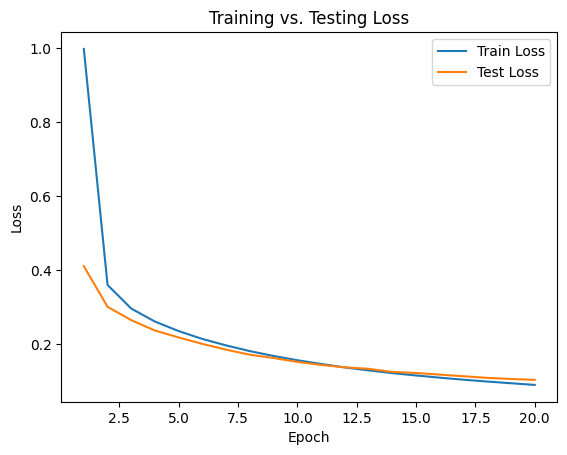

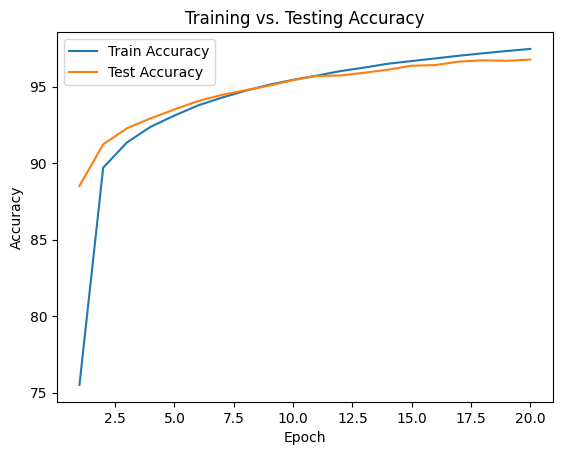

In [ ]:
from __future__ import print_function

%load_ext autoreload
%autoreload 2
from ConvNet import ConvNet
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import argparse
import numpy as np
import matplotlib.pyplot as plt


def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''

    # Set model to train mode before each epoch
    model.train()

    # Empty list to store losses
    losses = []
    correct = 0

    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample

        # Push data/label to correct device
        data, target = data.to(device), target.to(device)

        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()

        # Do forward pass for current set of data
        output = model(data)

        # ======================================================================
        # Compute loss based on criterion
        # ----------------- YOUR CODE HERE ----------------------
        loss = criterion(output, target)
        #
        # Remove NotImplementedError and assign correct loss function.
        #loss = NotImplementedError()

        # Computes gradient based on final loss
        loss.backward()

        # Store loss
        losses.append(loss.item())

        # Optimize model parameters based on learning rate and gradient
        optimizer.step()

        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # ======================================================================
        # Count correct predictions overall
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc

def test(model, device, test_loader):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''

    # Set model to eval mode to notify all layers.
    model.eval()

    losses = []
    correct = 0

    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)

            # Predict for data by doing forward pass
            output = model(data)

            # ======================================================================
            # Compute loss based on same criterion as training
            loss = F.cross_entropy(output, target, reduction='mean')

            # Append loss to overall test loss
            losses.append(loss.item())

            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # ======================================================================
            # Count correct predictions overall
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy

def run_main(FLAGS):
    # Check if cuda is available
    use_cuda = torch.cuda.is_available()

    # Set proper device based on cuda availability
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Torch device selected: ", device)

    # Initialize the model and send to device
    model = ConvNet(FLAGS.mode).to(device)

    # Initialize the criterion for loss computation
    # ======================================================================
    criterion = nn.CrossEntropyLoss()
    # Remove NotImplementedError and assign correct loss function.
    #criterion = NotImplementedError()

    # Initialize optimizer type
    optimizer = optim.SGD(model.parameters(), lr=FLAGS.learning_rate, weight_decay=1e-7)

    # Create transformations to apply to each data sample
    # Can specify variations such as image flip, color flip, random crop, ...
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    # Load datasets for training and testing
    # Inbuilt datasets available in torchvision (check documentation online)
    dataset1 = datasets.MNIST('./data/', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('./data/', train=False,
                       transform=transform)
    train_loader = DataLoader(dataset1, batch_size = FLAGS.batch_size,
                                shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset2, batch_size = FLAGS.batch_size,
                                shuffle=False, num_workers=4)

    best_accuracy = 0.0

    train_losses, test_losses = [], []
    train_accs,   test_accs   = [], []

    # Run training for n_epochs specified in config
    for epoch in range(1, FLAGS.num_epochs + 1):
        print("\nEpoch: ", epoch)
        train_loss, train_accuracy = train(model, device, train_loader,
                                            optimizer, criterion, epoch, FLAGS.batch_size)
        test_loss, test_accuracy = test(model, device, test_loader)

        train_losses.append(train_loss)
        train_accs.append(100*train_accuracy)
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

    print("accuracy is {:2.2f}".format(best_accuracy))

    print("Training and evaluation finished")

    print(f"Best test accuracy: {best_accuracy:.2f}%")




    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, FLAGS.num_epochs+1), test_losses,  label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs. Testing Loss')
    plt.legend()
    plt.show()

    # Plot accuracies
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, FLAGS.num_epochs+1), test_accs,  label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Testing Accuracy')
    plt.legend()
    plt.show()

if __name__ == '__main__':
    # Set parameters for Sparse Autoencoder
    parser = argparse.ArgumentParser('CNN Exercise.')
    parser.add_argument('--mode',
                        type=int, default=2,
                        help='Select mode between 1-3.')
    parser.add_argument('--learning_rate',
                        type=float, default=0.001,
                        help='Initial learning rate.')
    parser.add_argument('--num_epochs',
                        type=int,
                        default=20,
                        help='Number of epochs to run trainer.')
    parser.add_argument('--batch_size',
                        type=int, default=10,
                        help='Batch size. Must divide evenly into the dataset sizes.')
    parser.add_argument('--log_dir',
                        type=str,
                        default='logs',
                        help='Directory to put logging.')

    FLAGS = None
    FLAGS, unparsed = parser.parse_known_args()

    print("Mode: ", FLAGS.mode)
    print("LR: ", FLAGS.learning_rate)
    print("Batch size: ", FLAGS.batch_size)

    run_main(FLAGS)

With ReLU we have gotten much faster convergence and much better accuracy as we should. With introducing non-linaerity we have gotten about 97% accuracy about 4% better than before and a much sharper fall in loss. Still minimal overfitting and is very good results but we will try and improve. I see we are still improving through epochs 20 so lets increase that and lets lower the lr a little. This took about 15 minutes to run

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mode:  2
LR:  0.0007
Batch size:  10
Torch device selected:  cpu

Epoch:  1
Train set: Average loss: 1.2756, Accuracy: 41891/60000 (70%)
Test set: Average loss: 0.5209, Accuracy: 8641/10000 (86%)

Epoch:  2
Train set: Average loss: 0.4281, Accuracy: 52921/60000 (88%)
Test set: Average loss: 0.3516, Accuracy: 8982/10000 (90%)

Epoch:  3
Train set: Average loss: 0.3360, Accuracy: 54259/60000 (90%)
Test set: Average loss: 0.3024, Accuracy: 9133/10000 (91%)

Epoch:  4
Train set: Average loss: 0.2969, Accuracy: 54846/60000 (91%)
Test set: Average loss: 0.2740, Accuracy: 9230/10000 (92%)

Epoch:  5
Train set: Average loss: 0.2706, Accuracy: 55290/60000 (92%)
Test set: Average loss: 0.2518, Accuracy: 9280/10000 (93%)

Epoch:  6
Train set: Average loss: 0.2500, Accuracy: 55648/60000 (93%)
Test set: Average loss: 0.2360, Accuracy: 9289/10000 (93%)

Epoch:  7
Train set: Average loss: 0.2324, Accuracy: 55973/6

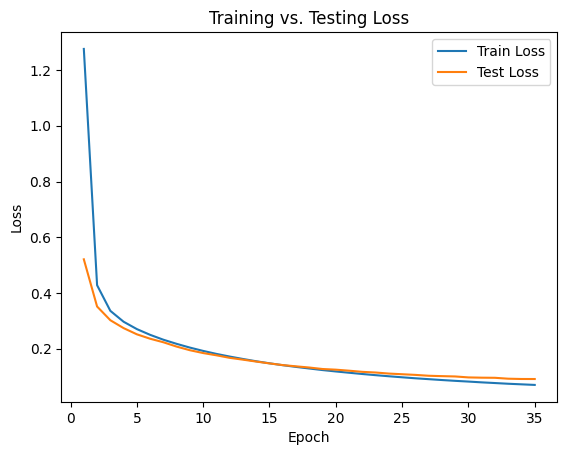

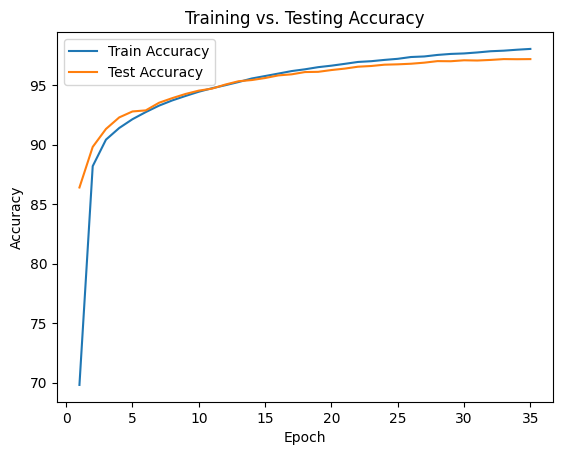

IndexError: index 10 is out of bounds for dimension 0 with size 10

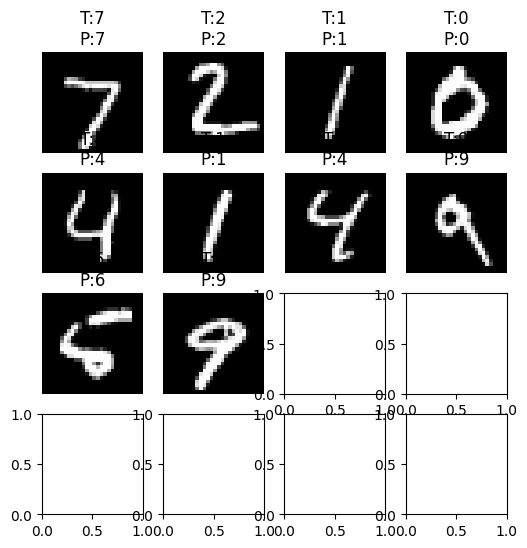

In [ ]:
from __future__ import print_function

%load_ext autoreload
%autoreload 2
from ConvNet import ConvNet
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import argparse
import numpy as np
import matplotlib.pyplot as plt


def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''

    # Set model to train mode before each epoch
    model.train()

    # Empty list to store losses
    losses = []
    correct = 0

    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample

        # Push data/label to correct device
        data, target = data.to(device), target.to(device)

        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()

        # Do forward pass for current set of data
        output = model(data)

        # ======================================================================
        # Compute loss based on criterion
        # ----------------- YOUR CODE HERE ----------------------
        loss = criterion(output, target)
        #
        # Remove NotImplementedError and assign correct loss function.
        #loss = NotImplementedError()

        # Computes gradient based on final loss
        loss.backward()

        # Store loss
        losses.append(loss.item())

        # Optimize model parameters based on learning rate and gradient
        optimizer.step()

        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # ======================================================================
        # Count correct predictions overall
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc

def test(model, device, test_loader):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''

    # Set model to eval mode to notify all layers.
    model.eval()

    losses = []
    correct = 0

    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)

            # Predict for data by doing forward pass
            output = model(data)

            # ======================================================================
            # Compute loss based on same criterion as training
            loss = F.cross_entropy(output, target, reduction='mean')

            # Append loss to overall test loss
            losses.append(loss.item())

            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # ======================================================================
            # Count correct predictions overall
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy

def run_main(FLAGS):
    # Check if cuda is available
    use_cuda = torch.cuda.is_available()

    # Set proper device based on cuda availability
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Torch device selected: ", device)

    # Initialize the model and send to device
    model = ConvNet(FLAGS.mode).to(device)

    # Initialize the criterion for loss computation
    # ======================================================================
    criterion = nn.CrossEntropyLoss()
    # Remove NotImplementedError and assign correct loss function.
    #criterion = NotImplementedError()

    # Initialize optimizer type
    optimizer = optim.SGD(model.parameters(), lr=FLAGS.learning_rate, weight_decay=1e-7)

    # Create transformations to apply to each data sample
    # Can specify variations such as image flip, color flip, random crop, ...
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    # Load datasets for training and testing
    # Inbuilt datasets available in torchvision (check documentation online)
    dataset1 = datasets.MNIST('./data/', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('./data/', train=False,
                       transform=transform)
    train_loader = DataLoader(dataset1, batch_size = FLAGS.batch_size,
                                shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset2, batch_size = FLAGS.batch_size,
                                shuffle=False, num_workers=4)

    best_accuracy = 0.0

    train_losses, test_losses = [], []
    train_accs,   test_accs   = [], []

    # Run training for n_epochs specified in config
    for epoch in range(1, FLAGS.num_epochs + 1):
        print("\nEpoch: ", epoch)
        train_loss, train_accuracy = train(model, device, train_loader,
                                            optimizer, criterion, epoch, FLAGS.batch_size)
        test_loss, test_accuracy = test(model, device, test_loader)

        train_losses.append(train_loss)
        train_accs.append(100*train_accuracy)
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

    print("accuracy is {:2.2f}".format(best_accuracy))

    print("Training and evaluation finished")

    print(f"Best test accuracy: {best_accuracy:.2f}%")




    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, FLAGS.num_epochs+1), test_losses,  label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs. Testing Loss')
    plt.legend()
    plt.show()

    # Plot accuracies
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, FLAGS.num_epochs+1), test_accs,  label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Testing Accuracy')
    plt.legend()
    plt.show()

    images, labels = next(iter(test_loader))

    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(images.to(device))
        preds   = outputs.argmax(dim=1).cpu()

    # How many to plot?
    n = images.size(0)          # 10 in your case
    cols = 5
    rows = (n + cols - 1)//cols # =2 rows for 10 images

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i, ax in enumerate(axes.flatten()):
        if i >= n:
            ax.axis('off')      # hide any extra subplots
            continue
        img = images[i].squeeze().cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(f"T:{labels[i].item()}\nP:{preds[i].item()}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # Set parameters for Sparse Autoencoder
    parser = argparse.ArgumentParser('CNN Exercise.')
    parser.add_argument('--mode',
                        type=int, default=2,
                        help='Select mode between 1-3.')
    parser.add_argument('--learning_rate',
                        type=float, default=0.0007,
                        help='Initial learning rate.')
    parser.add_argument('--num_epochs',
                        type=int,
                        default=35,
                        help='Number of epochs to run trainer.')
    parser.add_argument('--batch_size',
                        type=int, default=10,
                        help='Batch size. Must divide evenly into the dataset sizes.')
    parser.add_argument('--log_dir',
                        type=str,
                        default='logs',
                        help='Directory to put logging.')

    FLAGS = None
    FLAGS, unparsed = parser.parse_known_args()

    print("Mode: ", FLAGS.mode)
    print("LR: ", FLAGS.learning_rate)
    print("Batch size: ", FLAGS.batch_size)

    run_main(FLAGS)

So we did improve a little. Up to 97.2% accuracy which is good for a shallow 3 layer model. It did take longer with this lower learning rate converging slower but improved more in its end performance. We do plateau after 25 so 35 is not as necessary. Lets try one more time to see if a little lower learnign rate and the same epochs can improve, but these results are very promising. It took about 25 min for it run.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mode:  2
LR:  0.00035
Batch size:  10
Torch device selected:  cpu

Epoch:  1
Train set: Average loss: 1.8183, Accuracy: 31622/60000 (53%)
Test set: Average loss: 1.0596, Accuracy: 7716/10000 (77%)

Epoch:  2
Train set: Average loss: 0.7214, Accuracy: 49824/60000 (83%)
Test set: Average loss: 0.5120, Accuracy: 8706/10000 (87%)

Epoch:  3
Train set: Average loss: 0.4601, Accuracy: 52698/60000 (88%)
Test set: Average loss: 0.3932, Accuracy: 8925/10000 (89%)

Epoch:  4
Train set: Average loss: 0.3823, Accuracy: 53615/60000 (89%)
Test set: Average loss: 0.3447, Accuracy: 9021/10000 (90%)

Epoch:  5
Train set: Average loss: 0.3448, Accuracy: 54096/60000 (90%)
Test set: Average loss: 0.3180, Accuracy: 9077/10000 (91%)

Epoch:  6
Train set: Average loss: 0.3207, Accuracy: 54471/60000 (91%)
Test set: Average loss: 0.2983, Accuracy: 9140/10000 (91%)

Epoch:  7
Train set: Average loss: 0.3030, Accuracy: 54707/

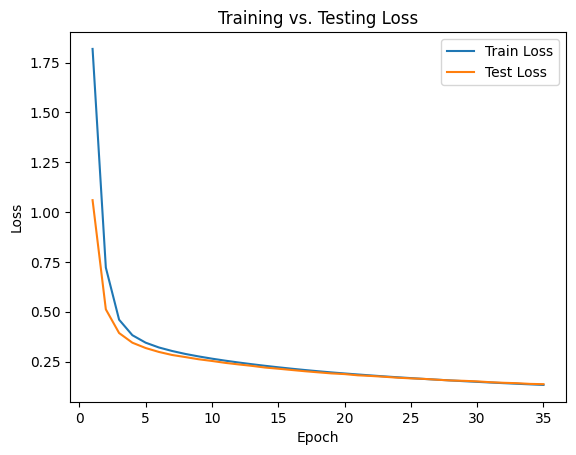

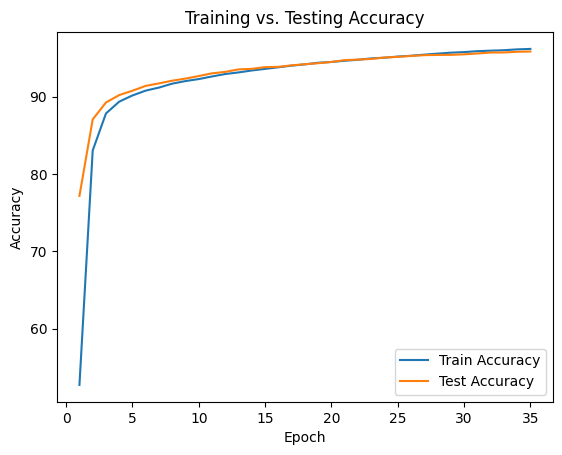

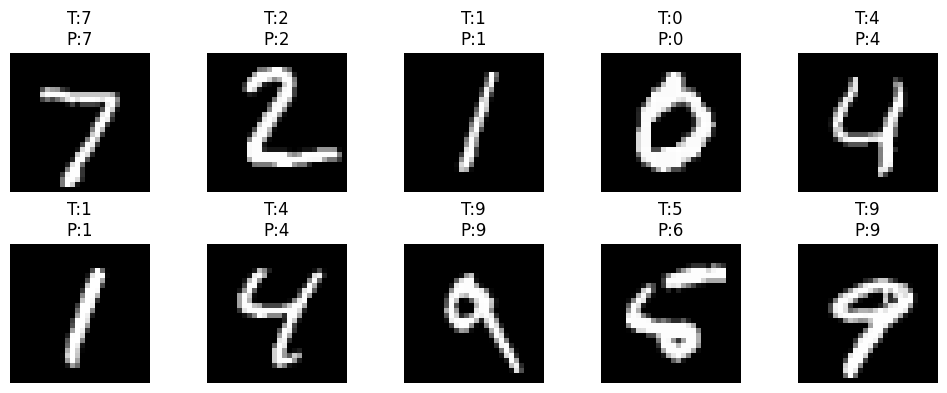

In [ ]:
from __future__ import print_function

%load_ext autoreload
%autoreload 2
from ConvNet import ConvNet
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import argparse
import numpy as np
import matplotlib.pyplot as plt


def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''

    # Set model to train mode before each epoch
    model.train()

    # Empty list to store losses
    losses = []
    correct = 0

    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample

        # Push data/label to correct device
        data, target = data.to(device), target.to(device)

        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()

        # Do forward pass for current set of data
        output = model(data)

        # ======================================================================
        # Compute loss based on criterion
        # ----------------- YOUR CODE HERE ----------------------
        loss = criterion(output, target)
        #
        # Remove NotImplementedError and assign correct loss function.
        #loss = NotImplementedError()

        # Computes gradient based on final loss
        loss.backward()

        # Store loss
        losses.append(loss.item())

        # Optimize model parameters based on learning rate and gradient
        optimizer.step()

        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # ======================================================================
        # Count correct predictions overall
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc

def test(model, device, test_loader):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''

    # Set model to eval mode to notify all layers.
    model.eval()

    losses = []
    correct = 0

    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)

            # Predict for data by doing forward pass
            output = model(data)

            # ======================================================================
            # Compute loss based on same criterion as training
            loss = F.cross_entropy(output, target, reduction='mean')

            # Append loss to overall test loss
            losses.append(loss.item())

            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # ======================================================================
            # Count correct predictions overall
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy

def run_main(FLAGS):
    # Check if cuda is available
    use_cuda = torch.cuda.is_available()

    # Set proper device based on cuda availability
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Torch device selected: ", device)

    # Initialize the model and send to device
    model = ConvNet(FLAGS.mode).to(device)

    # Initialize the criterion for loss computation
    # ======================================================================
    criterion = nn.CrossEntropyLoss()
    # Remove NotImplementedError and assign correct loss function.
    #criterion = NotImplementedError()

    # Initialize optimizer type
    optimizer = optim.SGD(model.parameters(), lr=FLAGS.learning_rate, weight_decay=1e-7)

    # Create transformations to apply to each data sample
    # Can specify variations such as image flip, color flip, random crop, ...
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    # Load datasets for training and testing
    # Inbuilt datasets available in torchvision (check documentation online)
    dataset1 = datasets.MNIST('./data/', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('./data/', train=False,
                       transform=transform)
    train_loader = DataLoader(dataset1, batch_size = FLAGS.batch_size,
                                shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset2, batch_size = FLAGS.batch_size,
                                shuffle=False, num_workers=4)

    best_accuracy = 0.0

    train_losses, test_losses = [], []
    train_accs,   test_accs   = [], []

    # Run training for n_epochs specified in config
    for epoch in range(1, FLAGS.num_epochs + 1):
        print("\nEpoch: ", epoch)
        train_loss, train_accuracy = train(model, device, train_loader,
                                            optimizer, criterion, epoch, FLAGS.batch_size)
        test_loss, test_accuracy = test(model, device, test_loader)

        train_losses.append(train_loss)
        train_accs.append(100*train_accuracy)
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

    print("accuracy is {:2.2f}".format(best_accuracy))

    print("Training and evaluation finished")

    print(f"Best test accuracy: {best_accuracy:.2f}%")




    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, FLAGS.num_epochs+1), test_losses,  label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs. Testing Loss')
    plt.legend()
    plt.show()

    # Plot accuracies
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, FLAGS.num_epochs+1), test_accs,  label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Testing Accuracy')
    plt.legend()
    plt.show()

    images, labels = next(iter(test_loader))

    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(images.to(device))
        preds   = outputs.argmax(dim=1).cpu()

    # How many to plot?
    n = images.size(0)          # 10 in your case
    cols = 5
    rows = (n + cols - 1)//cols # =2 rows for 10 images

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i, ax in enumerate(axes.flatten()):
        if i >= n:
            ax.axis('off')      # hide any extra subplots
            continue
        img = images[i].squeeze().cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(f"T:{labels[i].item()}\nP:{preds[i].item()}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # Set parameters for Sparse Autoencoder
    parser = argparse.ArgumentParser('CNN Exercise.')
    parser.add_argument('--mode',
                        type=int, default=2,
                        help='Select mode between 1-3.')
    parser.add_argument('--learning_rate',
                        type=float, default=0.00035,
                        help='Initial learning rate.')
    parser.add_argument('--num_epochs',
                        type=int,
                        default=35,
                        help='Number of epochs to run trainer.')
    parser.add_argument('--batch_size',
                        type=int, default=10,
                        help='Batch size. Must divide evenly into the dataset sizes.')
    parser.add_argument('--log_dir',
                        type=str,
                        default='logs',
                        help='Directory to put logging.')

    FLAGS = None
    FLAGS, unparsed = parser.parse_known_args()

    print("Mode: ", FLAGS.mode)
    print("LR: ", FLAGS.learning_rate)
    print("Batch size: ", FLAGS.batch_size)

    run_main(FLAGS)

We can see that this lower lr is much more inefficient. At the same epoch its at best 95.8% vs 97.2% accuracy. It just hasnt converged yet. We can run it one more time with more epochs to get the same or slightly better results, but 97% for this model will be hard to beat. Id recommend 0.0007 and 25 epochs for the best results and efficiency. To get the same results it could take up to double the time if not more so to me the optimal lr and epoch is 0.0007 and 25-30 epochs. This took about 25 minutes, same as the previous run but we ran the previous run for extra epochs that were unnecessary, so we can likely get these same if not better results in about 15 minutes.

Task 3 starts here has correct neurons, again above few cells were run on neurons that were not specified in project.

Task 3: Lets increase size of network with more neurons in each layer and 5 layers.

In [ ]:
%%writefile ConvNet.py


import time
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self, mode):
        super(ConvNet, self).__init__()

        # Define various layers here
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 10)



        # This will select the forward pass function based on mode for the ConvNet.
        # During creation of each ConvNet model, you will assign one of the valid mode.
        # This will fix the forward function (and the network graph) for the entire training/testing

        if mode == 1:
            self.forward = self.model_1
        elif mode == 2:
            self.forward = self.model_2
        elif mode == 3:
            self.forward = self.model_3
        else:
            print("Invalid mode ", mode, "selected. Select between 1-3")
            exit(0)

    # Baseline sample model
    def model_0(self, X):
        # ======================================================================
        # Three fully connected layers with activation

        X = torch.flatten(X, start_dim=1)
        X = self.fc1(X)#first layer + ReLU
        X = F.relu(X) #negs to 0, gets non-linearity
        X = self.fc2(X) #second layer + ReLU
        X = F.relu(X)
        X = self.fc3(X) #final lin layer
        X = torch.sigmoid(X) #sigmoid act

        return X

    # Baseline model. task 1
    def model_1(self, X):
        # ======================================================================
        # Three fully connected layers without activation

        X = torch.flatten(X, start_dim=1)
        X = self.fc1(X)
        X = self.fc2(X)
        X = self.fc3(X)
        return X
        # NotImplementedError

        return X


    # task 2
    def model_2(self, X):
        # ======================================================================
        # Train with activation (use model 1 from task 1)

        X = torch.flatten(X, start_dim=1)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        # NotImplementedError

        return X


    # task 3
    def model_3(self, X):
        # ======================================================================
        # Change number of fully connected layers and number of neurons from model 2 in task 2

        X = torch.flatten(X, start_dim=1)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = F.relu(self.fc4(X))
        X = self.fc5(X)
        # NotImplementedError

        return X

Overwriting ConvNet.py


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mode:  3
LR:  0.001
Batch size:  10
Torch device selected:  cpu

Epoch:  1


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train set: Average loss: 2.1817, Accuracy: 19451/60000 (32%)
Test set: Average loss: 1.6405, Accuracy: 5715/10000 (57%)

Epoch:  2
Train set: Average loss: 0.7761, Accuracy: 46677/60000 (78%)
Test set: Average loss: 0.4378, Accuracy: 8754/10000 (88%)

Epoch:  3
Train set: Average loss: 0.3868, Accuracy: 53293/60000 (89%)
Test set: Average loss: 0.3267, Accuracy: 9047/10000 (90%)

Epoch:  4
Train set: Average loss: 0.3108, Accuracy: 54608/60000 (91%)
Test set: Average loss: 0.2827, Accuracy: 9171/10000 (92%)

Epoch:  5
Train set: Average loss: 0.2631, Accuracy: 55435/60000 (92%)
Test set: Average loss: 0.2400, Accuracy: 9289/10000 (93%)

Epoch:  6
Train set: Average loss: 0.2240, Accuracy: 56082/60000 (93%)
Test set: Average loss: 0.2061, Accuracy: 9393/10000 (94%)

Epoch:  7
Train set: Average loss: 0.1925, Accuracy: 56662/60000 (94%)
Test set: Average loss: 0.1773, Accuracy: 9461/10000 (95%)

Epoch:  8
Train set: Average loss: 0.1684, Accuracy: 57067/60000 (95%)
Test set: Average loss

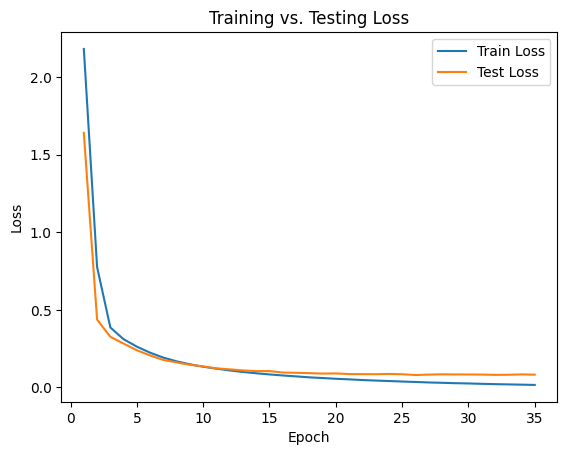

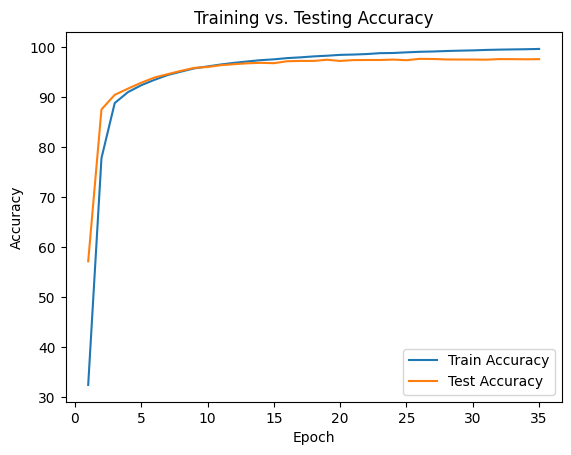

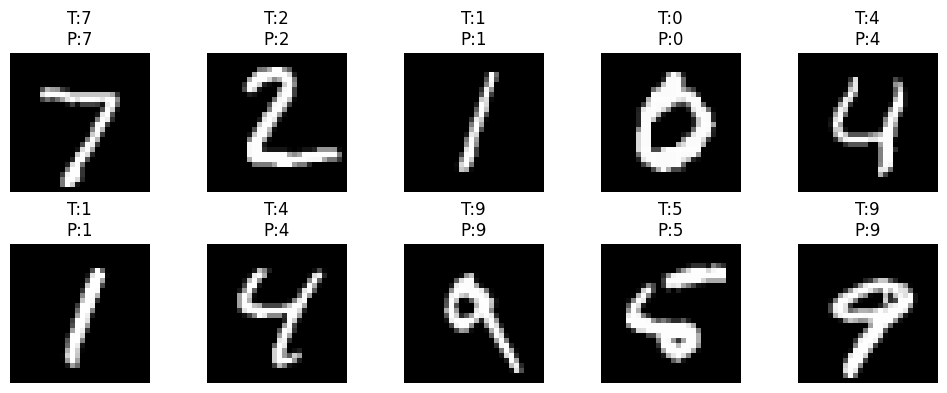

In [ ]:
from __future__ import print_function

%load_ext autoreload
%autoreload 2
from ConvNet import ConvNet
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import argparse
import numpy as np
import matplotlib.pyplot as plt


def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''

    # Set model to train mode before each epoch
    model.train()

    # Empty list to store losses
    losses = []
    correct = 0

    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample

        # Push data/label to correct device
        data, target = data.to(device), target.to(device)

        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()

        # Do forward pass for current set of data
        output = model(data)

        # ======================================================================
        # Compute loss based on criterion
        # ----------------- YOUR CODE HERE ----------------------
        loss = criterion(output, target)
        #
        # Remove NotImplementedError and assign correct loss function.
        #loss = NotImplementedError()

        # Computes gradient based on final loss
        loss.backward()

        # Store loss
        losses.append(loss.item())

        # Optimize model parameters based on learning rate and gradient
        optimizer.step()

        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # ======================================================================
        # Count correct predictions overall
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc

def test(model, device, test_loader):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''

    # Set model to eval mode to notify all layers.
    model.eval()

    losses = []
    correct = 0

    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)

            # Predict for data by doing forward pass
            output = model(data)

            # ======================================================================
            # Compute loss based on same criterion as training
            loss = F.cross_entropy(output, target, reduction='mean')

            # Append loss to overall test loss
            losses.append(loss.item())

            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # ======================================================================
            # Count correct predictions overall
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy

def run_main(FLAGS):
    # Check if cuda is available
    use_cuda = torch.cuda.is_available()

    # Set proper device based on cuda availability
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Torch device selected: ", device)

    # Initialize the model and send to device
    model = ConvNet(FLAGS.mode).to(device)

    # Initialize the criterion for loss computation
    # ======================================================================
    criterion = nn.CrossEntropyLoss()
    # Remove NotImplementedError and assign correct loss function.
    #criterion = NotImplementedError()

    # Initialize optimizer type
    optimizer = optim.SGD(model.parameters(), lr=FLAGS.learning_rate, weight_decay=1e-7)

    # Create transformations to apply to each data sample
    # Can specify variations such as image flip, color flip, random crop, ...
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    # Load datasets for training and testing
    # Inbuilt datasets available in torchvision (check documentation online)
    dataset1 = datasets.MNIST('./data/', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('./data/', train=False,
                       transform=transform)
    train_loader = DataLoader(dataset1, batch_size = FLAGS.batch_size,
                                shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset2, batch_size = FLAGS.batch_size,
                                shuffle=False, num_workers=4)

    best_accuracy = 0.0

    train_losses, test_losses = [], []
    train_accs,   test_accs   = [], []

    # Run training for n_epochs specified in config
    for epoch in range(1, FLAGS.num_epochs + 1):
        print("\nEpoch: ", epoch)
        train_loss, train_accuracy = train(model, device, train_loader,
                                            optimizer, criterion, epoch, FLAGS.batch_size)
        test_loss, test_accuracy = test(model, device, test_loader)

        train_losses.append(train_loss)
        train_accs.append(100*train_accuracy)
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

    print("accuracy is {:2.2f}".format(best_accuracy))

    print("Training and evaluation finished")

    print(f"Best test accuracy: {best_accuracy:.2f}%")




    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, FLAGS.num_epochs+1), test_losses,  label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs. Testing Loss')
    plt.legend()
    plt.show()

    # Plot accuracies
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, FLAGS.num_epochs+1), test_accs,  label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Testing Accuracy')
    plt.legend()
    plt.show()

    images, labels = next(iter(test_loader))

    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(images.to(device))
        preds   = outputs.argmax(dim=1).cpu()

    # How many to plot?
    n = images.size(0)          # 10 in your case
    cols = 5
    rows = (n + cols - 1)//cols # =2 rows for 10 images

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i, ax in enumerate(axes.flatten()):
        if i >= n:
            ax.axis('off')      # hide any extra subplots
            continue
        img = images[i].squeeze().cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(f"T:{labels[i].item()}\nP:{preds[i].item()}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # Set parameters for Sparse Autoencoder
    parser = argparse.ArgumentParser('CNN Exercise.')
    parser.add_argument('--mode',
                        type=int, default=3,
                        help='Select mode between 1-3.')
    parser.add_argument('--learning_rate',
                        type=float, default=0.001,
                        help='Initial learning rate.')
    parser.add_argument('--num_epochs',
                        type=int,
                        default=35,
                        help='Number of epochs to run trainer.')
    parser.add_argument('--batch_size',
                        type=int, default=10,
                        help='Batch size. Must divide evenly into the dataset sizes.')
    parser.add_argument('--log_dir',
                        type=str,
                        default='logs',
                        help='Directory to put logging.')

    FLAGS = None
    FLAGS, unparsed = parser.parse_known_args()

    print("Mode: ", FLAGS.mode)
    print("LR: ", FLAGS.learning_rate)
    print("Batch size: ", FLAGS.batch_size)

    run_main(FLAGS)

This network works like expected. learns slower at first but does get better end results. This lr and epoch are not optimal though as overfitting does start to happen around epoch 25-30. We can see test accuracy starts to be minimally better if at all at this point while training continues to climb to 100%. This took about 30 minutes. A smaller lr with more epochs should get better results so lets test this. We also see little to no variance in loss and accuracy whish is great.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mode:  3
LR:  0.0004
Batch size:  10
Torch device selected:  cpu

Epoch:  1
Train set: Average loss: 2.2893, Accuracy: 14697/60000 (24%)
Test set: Average loss: 2.2713, Accuracy: 3822/10000 (38%)

Epoch:  2
Train set: Average loss: 2.2188, Accuracy: 27192/60000 (45%)
Test set: Average loss: 2.0987, Accuracy: 5128/10000 (51%)

Epoch:  3
Train set: Average loss: 1.6078, Accuracy: 36295/60000 (60%)
Test set: Average loss: 1.0210, Accuracy: 7319/10000 (73%)

Epoch:  4
Train set: Average loss: 0.7571, Accuracy: 47182/60000 (79%)
Test set: Average loss: 0.5739, Accuracy: 8331/10000 (83%)

Epoch:  5
Train set: Average loss: 0.5080, Accuracy: 51247/60000 (85%)
Test set: Average loss: 0.4314, Accuracy: 8729/10000 (87%)

Epoch:  6
Train set: Average loss: 0.4135, Accuracy: 52874/60000 (88%)
Test set: Average loss: 0.3729, Accuracy: 8904/10000 (89%)

Epoch:  7
Train set: Average loss: 0.3655, Accuracy: 53670/6

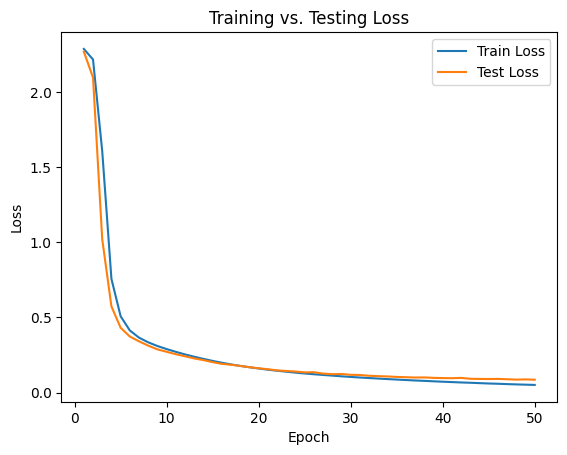

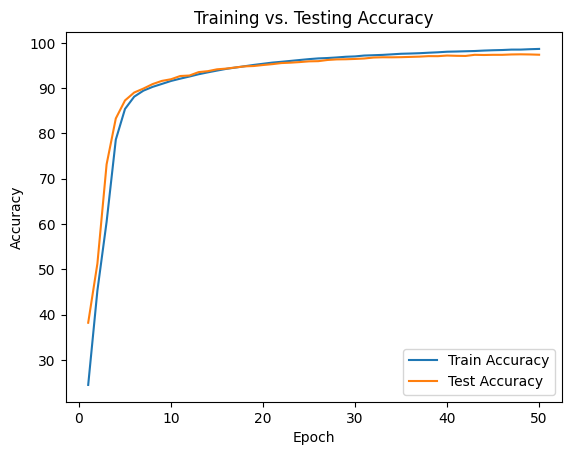

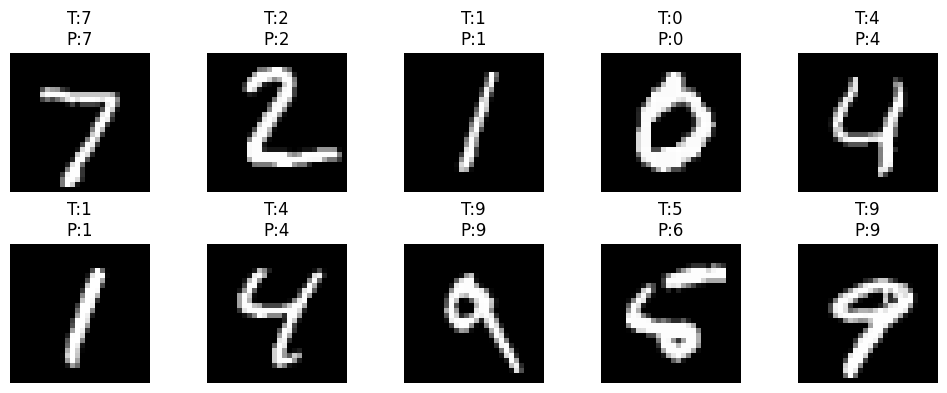

In [ ]:
from __future__ import print_function

%load_ext autoreload
%autoreload 2
from ConvNet import ConvNet
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import argparse
import numpy as np
import matplotlib.pyplot as plt


def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''

    # Set model to train mode before each epoch
    model.train()

    # Empty list to store losses
    losses = []
    correct = 0

    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample

        # Push data/label to correct device
        data, target = data.to(device), target.to(device)

        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()

        # Do forward pass for current set of data
        output = model(data)

        # ======================================================================
        # Compute loss based on criterion
        # ----------------- YOUR CODE HERE ----------------------
        loss = criterion(output, target)
        #
        # Remove NotImplementedError and assign correct loss function.
        #loss = NotImplementedError()

        # Computes gradient based on final loss
        loss.backward()

        # Store loss
        losses.append(loss.item())

        # Optimize model parameters based on learning rate and gradient
        optimizer.step()

        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # ======================================================================
        # Count correct predictions overall
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc

def test(model, device, test_loader):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''

    # Set model to eval mode to notify all layers.
    model.eval()

    losses = []
    correct = 0

    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)

            # Predict for data by doing forward pass
            output = model(data)

            # ======================================================================
            # Compute loss based on same criterion as training
            loss = F.cross_entropy(output, target, reduction='mean')

            # Append loss to overall test loss
            losses.append(loss.item())

            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # ======================================================================
            # Count correct predictions overall
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy

def run_main(FLAGS):
    # Check if cuda is available
    use_cuda = torch.cuda.is_available()

    # Set proper device based on cuda availability
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Torch device selected: ", device)

    # Initialize the model and send to device
    model = ConvNet(FLAGS.mode).to(device)

    # Initialize the criterion for loss computation
    # ======================================================================
    criterion = nn.CrossEntropyLoss()
    # Remove NotImplementedError and assign correct loss function.
    #criterion = NotImplementedError()

    # Initialize optimizer type
    optimizer = optim.SGD(model.parameters(), lr=FLAGS.learning_rate, weight_decay=1e-7)

    # Create transformations to apply to each data sample
    # Can specify variations such as image flip, color flip, random crop, ...
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    # Load datasets for training and testing
    # Inbuilt datasets available in torchvision (check documentation online)
    dataset1 = datasets.MNIST('./data/', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('./data/', train=False,
                       transform=transform)
    train_loader = DataLoader(dataset1, batch_size = FLAGS.batch_size,
                                shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset2, batch_size = FLAGS.batch_size,
                                shuffle=False, num_workers=4)

    best_accuracy = 0.0

    train_losses, test_losses = [], []
    train_accs,   test_accs   = [], []

    # Run training for n_epochs specified in config
    for epoch in range(1, FLAGS.num_epochs + 1):
        print("\nEpoch: ", epoch)
        train_loss, train_accuracy = train(model, device, train_loader,
                                            optimizer, criterion, epoch, FLAGS.batch_size)
        test_loss, test_accuracy = test(model, device, test_loader)

        train_losses.append(train_loss)
        train_accs.append(100*train_accuracy)
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

    print("accuracy is {:2.2f}".format(best_accuracy))

    print("Training and evaluation finished")

    print(f"Best test accuracy: {best_accuracy:.2f}%")




    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, FLAGS.num_epochs+1), test_losses,  label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs. Testing Loss')
    plt.legend()
    plt.show()

    # Plot accuracies
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, FLAGS.num_epochs+1), test_accs,  label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Testing Accuracy')
    plt.legend()
    plt.show()

    images, labels = next(iter(test_loader))

    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(images.to(device))
        preds   = outputs.argmax(dim=1).cpu()

    # How many to plot?
    n = images.size(0)          # 10 in your case
    cols = 5
    rows = (n + cols - 1)//cols # =2 rows for 10 images

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i, ax in enumerate(axes.flatten()):
        if i >= n:
            ax.axis('off')      # hide any extra subplots
            continue
        img = images[i].squeeze().cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(f"T:{labels[i].item()}\nP:{preds[i].item()}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # Set parameters for Sparse Autoencoder
    parser = argparse.ArgumentParser('CNN Exercise.')
    parser.add_argument('--mode',
                        type=int, default=3,
                        help='Select mode between 1-3.')
    parser.add_argument('--learning_rate',
                        type=float, default=0.0004,
                        help='Initial learning rate.')
    parser.add_argument('--num_epochs',
                        type=int,
                        default=50,
                        help='Number of epochs to run trainer.')
    parser.add_argument('--batch_size',
                        type=int, default=10,
                        help='Batch size. Must divide evenly into the dataset sizes.')
    parser.add_argument('--log_dir',
                        type=str,
                        default='logs',
                        help='Directory to put logging.')

    FLAGS = None
    FLAGS, unparsed = parser.parse_known_args()

    print("Mode: ", FLAGS.mode)
    print("LR: ", FLAGS.learning_rate)
    print("Batch size: ", FLAGS.batch_size)

    run_main(FLAGS)

Similar to last time with slow progress at first. We achieve the best test accuracy at epoch 48 and it plateaus while training continues to rise. This is indicating overfitting again. It improved the final loss a little and slightly better accuracy but taking more epochs and time so I wouldn't say this is better. It took about 45 minutes. Lets try a slightly slower rate while giving it more epochs to train and test.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mode:  3
LR:  0.00035
Batch size:  10
Torch device selected:  cpu

Epoch:  1
Train set: Average loss: 2.2937, Accuracy: 13761/60000 (23%)
Test set: Average loss: 2.2812, Accuracy: 3959/10000 (40%)

Epoch:  2
Train set: Average loss: 2.2584, Accuracy: 24899/60000 (41%)
Test set: Average loss: 2.2152, Accuracy: 4130/10000 (41%)

Epoch:  3
Train set: Average loss: 2.0526, Accuracy: 26536/60000 (44%)
Test set: Average loss: 1.7135, Accuracy: 5935/10000 (59%)

Epoch:  4
Train set: Average loss: 1.1629, Accuracy: 43068/60000 (72%)
Test set: Average loss: 0.7471, Accuracy: 7883/10000 (79%)

Epoch:  5
Train set: Average loss: 0.6317, Accuracy: 48964/60000 (82%)
Test set: Average loss: 0.5179, Accuracy: 8470/10000 (85%)

Epoch:  6
Train set: Average loss: 0.4864, Accuracy: 51526/60000 (86%)
Test set: Average loss: 0.4268, Accuracy: 8756/10000 (88%)

Epoch:  7
Train set: Average loss: 0.4159, Accuracy: 52789/

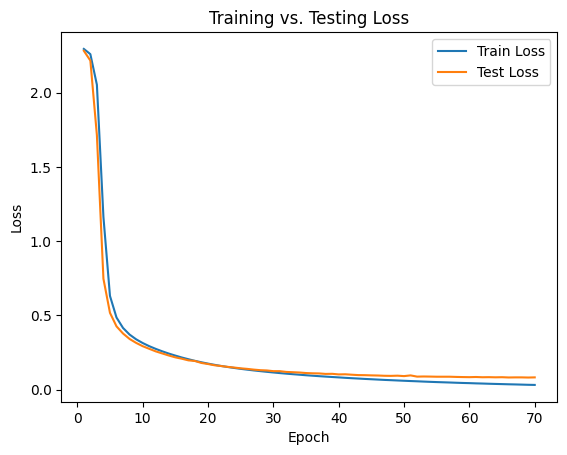

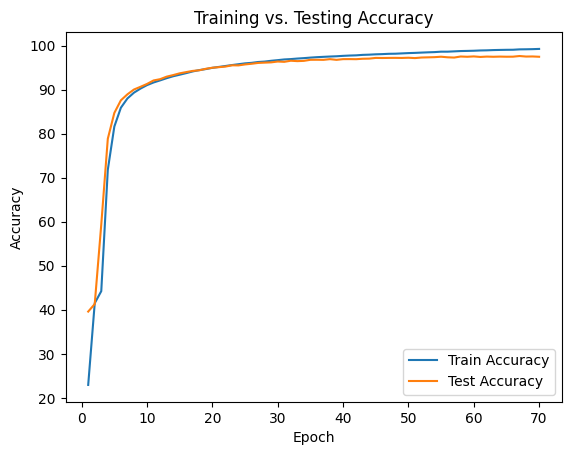

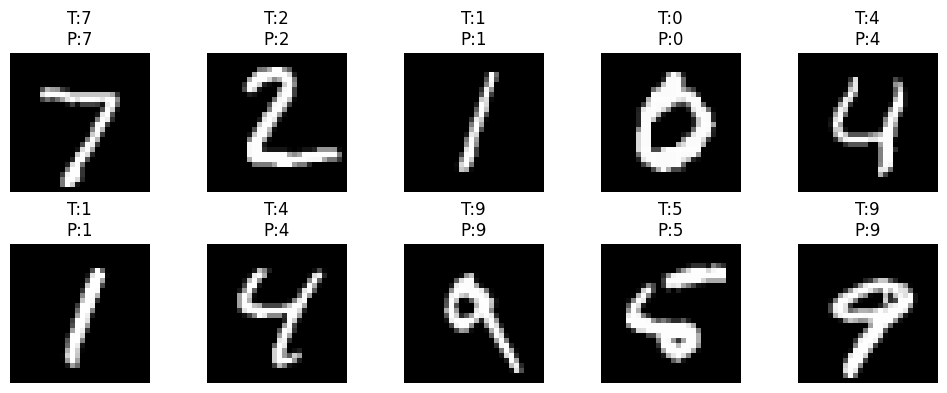

In [ ]:
from __future__ import print_function

%load_ext autoreload
%autoreload 2
from ConvNet import ConvNet
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import argparse
import numpy as np
import matplotlib.pyplot as plt


def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''

    # Set model to train mode before each epoch
    model.train()

    # Empty list to store losses
    losses = []
    correct = 0

    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample

        # Push data/label to correct device
        data, target = data.to(device), target.to(device)

        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()

        # Do forward pass for current set of data
        output = model(data)

        # ======================================================================
        # Compute loss based on criterion
        # ----------------- YOUR CODE HERE ----------------------
        loss = criterion(output, target)
        #
        # Remove NotImplementedError and assign correct loss function.
        #loss = NotImplementedError()

        # Computes gradient based on final loss
        loss.backward()

        # Store loss
        losses.append(loss.item())

        # Optimize model parameters based on learning rate and gradient
        optimizer.step()

        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # ======================================================================
        # Count correct predictions overall
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc

def test(model, device, test_loader):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''

    # Set model to eval mode to notify all layers.
    model.eval()

    losses = []
    correct = 0

    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)

            # Predict for data by doing forward pass
            output = model(data)

            # ======================================================================
            # Compute loss based on same criterion as training
            loss = F.cross_entropy(output, target, reduction='mean')

            # Append loss to overall test loss
            losses.append(loss.item())

            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # ======================================================================
            # Count correct predictions overall
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy

def run_main(FLAGS):
    # Check if cuda is available
    use_cuda = torch.cuda.is_available()

    # Set proper device based on cuda availability
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Torch device selected: ", device)

    # Initialize the model and send to device
    model = ConvNet(FLAGS.mode).to(device)

    # Initialize the criterion for loss computation
    # ======================================================================
    criterion = nn.CrossEntropyLoss()
    # Remove NotImplementedError and assign correct loss function.
    #criterion = NotImplementedError()

    # Initialize optimizer type
    optimizer = optim.SGD(model.parameters(), lr=FLAGS.learning_rate, weight_decay=1e-7)

    # Create transformations to apply to each data sample
    # Can specify variations such as image flip, color flip, random crop, ...
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    # Load datasets for training and testing
    # Inbuilt datasets available in torchvision (check documentation online)
    dataset1 = datasets.MNIST('./data/', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('./data/', train=False,
                       transform=transform)
    train_loader = DataLoader(dataset1, batch_size = FLAGS.batch_size,
                                shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset2, batch_size = FLAGS.batch_size,
                                shuffle=False, num_workers=4)

    best_accuracy = 0.0

    train_losses, test_losses = [], []
    train_accs,   test_accs   = [], []

    # Run training for n_epochs specified in config
    for epoch in range(1, FLAGS.num_epochs + 1):
        print("\nEpoch: ", epoch)
        train_loss, train_accuracy = train(model, device, train_loader,
                                            optimizer, criterion, epoch, FLAGS.batch_size)
        test_loss, test_accuracy = test(model, device, test_loader)

        train_losses.append(train_loss)
        train_accs.append(100*train_accuracy)
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

    print("accuracy is {:2.2f}".format(best_accuracy))

    print("Training and evaluation finished")

    print(f"Best test accuracy: {best_accuracy:.2f}%")




    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, FLAGS.num_epochs+1), test_losses,  label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs. Testing Loss')
    plt.legend()
    plt.show()

    # Plot accuracies
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, FLAGS.num_epochs+1), test_accs,  label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Testing Accuracy')
    plt.legend()
    plt.show()

    images, labels = next(iter(test_loader))

    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(images.to(device))
        preds   = outputs.argmax(dim=1).cpu()

    # How many to plot?
    n = images.size(0)          # 10 in your case
    cols = 5
    rows = (n + cols - 1)//cols # =2 rows for 10 images

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i, ax in enumerate(axes.flatten()):
        if i >= n:
            ax.axis('off')      # hide any extra subplots
            continue
        img = images[i].squeeze().cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(f"T:{labels[i].item()}\nP:{preds[i].item()}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # Set parameters for Sparse Autoencoder
    parser = argparse.ArgumentParser('CNN Exercise.')
    parser.add_argument('--mode',
                        type=int, default=3,
                        help='Select mode between 1-3.')
    parser.add_argument('--learning_rate',
                        type=float, default=0.00035,
                        help='Initial learning rate.')
    parser.add_argument('--num_epochs',
                        type=int,
                        default=70,
                        help='Number of epochs to run trainer.')
    parser.add_argument('--batch_size',
                        type=int, default=10,
                        help='Batch size. Must divide evenly into the dataset sizes.')
    parser.add_argument('--log_dir',
                        type=str,
                        default='logs',
                        help='Directory to put logging.')

    FLAGS = None
    FLAGS, unparsed = parser.parse_known_args()

    print("Mode: ", FLAGS.mode)
    print("LR: ", FLAGS.learning_rate)
    print("Batch size: ", FLAGS.batch_size)

    run_main(FLAGS)

This model did get the best results yet. It did take over an hour to run though. Our variance is very low and we are not overfitting. This is all very good signs for this model. The training is a little slower with this lower lr and higher epochs but did improve the overall model. Loss continued to decrease also a good sign of not overfitting. It is not an insane improvement over 0.0004 lr with 50 epochs so if time and computation is an issue, the previous may be better, but if the goal is strictly best performance I would say this did achieve the best results yet.

Part 2. Convolutional Neural Network

In [ ]:
%%writefile ConvNet.py
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self, mode):
        super(ConvNet, self).__init__()

        # Define various layers here, such as in the tutorial example
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        #self.conv2 = Make conv layer like above
        self.conv2 = nn.Conv2d(10, 10, kernel_size=3)
        #self.conv3 = Make conv layer like above

        self.fc1_model1 = nn.Linear(360, 100)  # This is first fully connected layer for step 1.
        self.fc1_model2 = nn.Linear(1440, 100) # This is first fully connected layer for step 2.
        self.fc1_model3 = nn.Linear(640, 100)  # This is first fully connected layer for step 3

        self.fc2 = nn.Linear(100, 10)       # This is 2nd fully connected layer for all models.

        #self.fc_model0 = nn.Linear(2250, 100)   # This is for example model.
        self.fc_model0 = nn.Linear(360, 100)


        # This will select the forward pass function based on mode for the ConvNet.
        # Based on the question, you have 3 modes available for step 1 to 3.
        # During creation of each ConvNet model, you will assign one of the valid mode.
        # This will fix the forward function (and the network graph) for the entire training/testing
        if mode == 1:
            self.forward = self.model_1
        elif mode == 2:
            self.forward = self.model_2
        elif mode == 3:
            self.forward = self.model_3
        elif mode == 0:
            self.forward = self.model_0
        else:
            print("Invalid mode ", mode, "selected. Select between 1-3")
            exit(0)


    # Example model. Modify this for step 1-3
    def model_0(self, X):
        # ======================================================================
        #2 conv2d layers with ReLU, followed by maxpool2d
        X = F.relu(self.conv1(X)) #conv layer 1
        #print(X.shape)
        X = F.max_pool2d(X, kernel_size=2) #pool 1
        #print(X.shape)

        #self.conv2 = nn.Conv2d(10, 10, kernel_size=3) #layer 2 is in init
        X = F.relu(self.conv2(X))
        #print(X.shape)
        X = F.max_pool2d(X, kernel_size=2) # pool 2
        #print(X.shape

        X = torch.flatten(X, start_dim=1) #flatten
        #print(X.shape)

        X = F.relu(self.fc_model0(X)) #fully connected layers
        X = self.fc2(X)

        return X


    # Simple CNN. step 1
    def model_1(self, X):
        # ======================================================================

        # Complete this part as model_0, add one more conv2d layer
        # with relu activation followed by maxpool layer.

        X = torch.flatten(X, start_dim=1)

        X = F.relu(self.fc1_model1(X))
        X = self.fc2(X)

        return X


    # Increase filters. step 2
    def model_2(self, X):
        # ======================================================================

        # Complete this part as model_1. Modify in/out channels for conv2d layers.

        X = torch.flatten(X, start_dim=1)

        X = F.relu(self.fc1_model2(X))
        X = self.fc2(X)

        return X


    # Large CNN. step 3
    def model_3(self, X):
        # ======================================================================

        # Complete this part as model_2, add one more conv2d layer
        # with relu activation. Do not add maxpool after this new conv2d layer.

        X = torch.flatten(X, start_dim=1)

        X = F.relu(self.fc1_model3(X))
        X = self.fc2(X)

        return X






Overwriting ConvNet.py


I implemented the CNN for task 4 in part 2 on model 0 like requested. Lets run each requested learning rate.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mode:  0
LR:  0.5
Batch size:  32
Torch device selected:  cpu

Epoch:  1
Train set: Average loss: 1.9545, Accuracy: 13696/50016 (27%)
Test set: Average loss: 1.7505, Accuracy: 3562/10000 (36%)

Epoch:  2
Train set: Average loss: 1.7401, Accuracy: 18234/50016 (36%)
Test set: Average loss: 1.6765, Accuracy: 3917/10000 (39%)

Epoch:  3
Train set: Average loss: 1.6925, Accuracy: 19432/50016 (39%)
Test set: Average loss: 1.7189, Accuracy: 3756/10000 (38%)

Epoch:  4
Train set: Average loss: 1.6786, Accuracy: 19747/50016 (39%)
Test set: Average loss: 1.7420, Accuracy: 3694/10000 (37%)

Epoch:  5
Train set: Average loss: 1.6687, Accuracy: 20026/50016 (40%)
Test set: Average loss: 1.8250, Accuracy: 3841/10000 (38%)

Epoch:  6
Train set: Average loss: 1.6529, Accuracy: 20527/50016 (41%)
Test set: Average loss: 1.7430, Accuracy: 3856/10000 (39%)

Epoch:  7
Train set: Average loss: 1.6566, Accuracy: 20503/5001

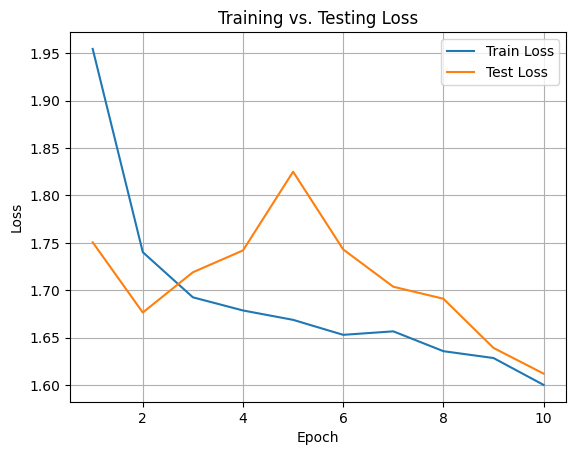

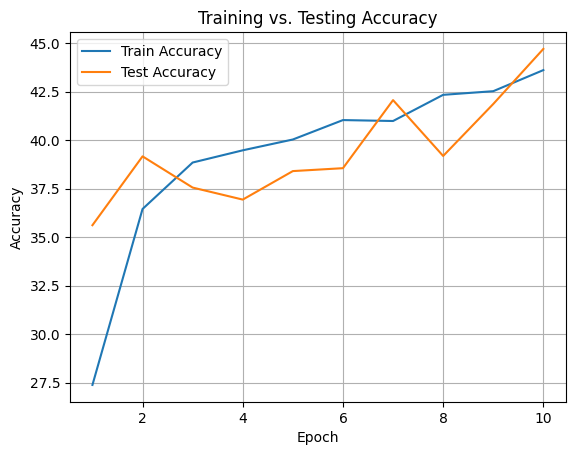

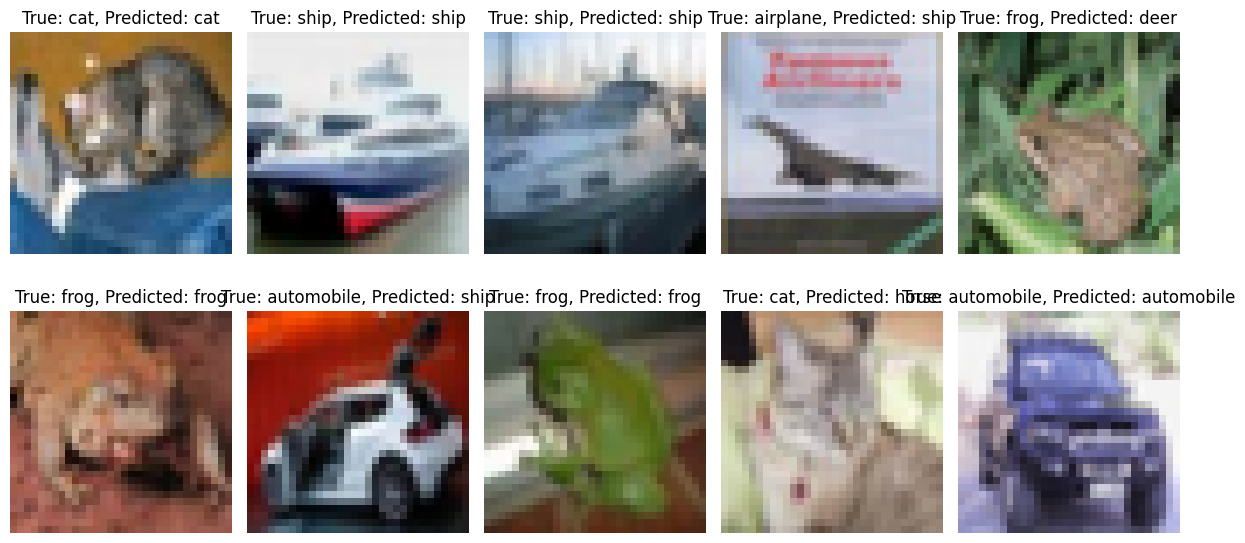

In [ ]:
from __future__ import print_function
%load_ext autoreload
%autoreload 2
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from ConvNet import ConvNet
import argparse
import numpy as np

def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''

    # Set model to train mode before each epoch
    model.train()

    # Empty list to store losses
    losses = []
    correct = 0

    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample

        # Push data/label to correct device
        data, target = data.to(device), target.to(device)
        # print(data.shape)
        # print(target.shape)
        # exit()

        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()

        # Do forward pass for current set of data
        output = model(data)

        # ======================================================================
        # Compute loss based on criterion
        #loss = NotImplementedError()
        loss = criterion(output, target)

        # Computes gradient based on final loss
        loss.backward()

        # Store loss
        losses.append(loss.item())

        # Optimize model parameters based on learning rate and gradient
        optimizer.step()

        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # ======================================================================
        # Count correct predictions overall
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc



def test(model, device, test_loader):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''

    # Set model to eval mode to notify all layers.
    model.eval()

    losses = []
    correct = 0

    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)


            # Predict for data by doing forward pass
            output = model(data)

            # ======================================================================
            # Compute loss based on same criterion as training
            loss = F.cross_entropy(output, target, reduction='mean')

            # Append loss to overall test loss
            losses.append(loss.item())

            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # ======================================================================
            # Count correct predictions overall
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy


def run_main(FLAGS):
    # Check if cuda is available
    use_cuda = torch.cuda.is_available()

    # Set proper device based on cuda availability
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Torch device selected: ", device)

    # Initialize the model and send to device
    model = ConvNet(FLAGS.mode).to(device)
    # print(model)
    # exit()

    # Initialize the criterion for loss computation
    criterion = nn.CrossEntropyLoss(reduction='mean')

    # Initialize optimizer type
    optimizer = optim.SGD(model.parameters(), lr=FLAGS.learning_rate, weight_decay=1e-7)

    # Create transformations to apply to each data sample
    # Can specify variations such as image flip, color flip, random crop, ...
    #transform=transforms.Compose([
    #    transforms.ToTensor(),
    #    transforms.Normalize((0.1307,), (0.3081,))
    #    ])

    transform = transforms.Compose(
                    [transforms.ToTensor(),
                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # Load datasets for training and testing
    # Inbuilt datasets available in torchvision (check documentation online)
    dataset1 = datasets.CIFAR10('./data/', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.CIFAR10('./data/', train=False,
                       transform=transform)
    train_loader = DataLoader(dataset1, batch_size = FLAGS.batch_size,
                                shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset2, batch_size = FLAGS.batch_size,
                                shuffle=False, num_workers=4)

    best_accuracy = 0.0

    train_losses, test_losses = [], []
    train_accs,   test_accs   = [], []
    # Run training for n_epochs specified in config
    for epoch in range(1, FLAGS.num_epochs + 1):
        print("\nEpoch: ", epoch)
        train_loss, train_accuracy = train(model, device, train_loader,
                                            optimizer, criterion, epoch, FLAGS.batch_size)
        test_loss, test_accuracy = test(model, device, test_loader)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

        train_losses.append(train_loss)
        train_accs.append(100*train_accuracy)
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)

    print("accuracy is {:2.2f}".format(best_accuracy))

    print("Training and evaluation finished")
#plot loss
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, FLAGS.num_epochs+1), test_losses,  label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs. Testing Loss')
    plt.legend()
    plt.grid()
    plt.show()

    #plot accuracies
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, FLAGS.num_epochs+1), test_accs,  label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Testing Accuracy')
    plt.legend()
    plt.grid()
    plt.show()


    #visualize some test samples
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    classes = dataset1.classes
    with torch.no_grad():
      outputs = model(images)
      predicted = outputs.argmax(dim=1)

    plt.figure(figsize=(12, 6))
    for i in range(10):
      img = images[i].cpu().permute(1, 2, 0) *0.5 + 0.5
      plt.subplot(2, 5, i+1)
      plt.imshow(img)
      plt.title(f'True: {classes[labels[i]]}, Predicted: {classes[predicted[i]]}')
      plt.axis('off')
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    # Set parameters for Sparse Autoencoder
    parser = argparse.ArgumentParser('CNN Exercise.')
    parser.add_argument('--mode',
                        type=int, default=0,
                        help='Select mode between 0-3.')
    parser.add_argument('--learning_rate',
                        type=float, default=0.5,
                        help='Initial learning rate.')
    parser.add_argument('--num_epochs',
                        type=int,
                        default=10,
                        help='Number of epochs to run trainer.')
    parser.add_argument('--batch_size',
                        type=int, default=32,
                        help='Batch size. Must divide evenly into the dataset sizes.')
    parser.add_argument('--log_dir',
                        type=str,
                        default='logs',
                        help='Directory to put logging.')

    FLAGS = None
    FLAGS, unparsed = parser.parse_known_args()

    print("Mode: ", FLAGS.mode)
    print("LR: ", FLAGS.learning_rate)
    print("Batch size: ", FLAGS.batch_size)

    run_main(FLAGS)







So our initial run. We do see the model is learning after a high loss at the start. Training loss did decrease and accuracy did improve throughout so it is learning.With such a high learning rate our testing loss varies a lot spiking at epoch 5-6, so its not generalizng great but that is expected with this learning rate. its noisy and possibly overfitting. We do see it increasing in training and test accuracy as expected but with only 10 epochs it is expected to not be that great yet. Im going to increase the epochs to test even though part 2 doesnt ask to adjust that parameter to see where it does start to plateau. This took only about 6 minutes, so lets try 30 epochs, so we should easily beable to see what epoch it starts to plateau and at what accuracy.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mode:  0
LR:  0.5
Batch size:  32
Torch device selected:  cpu

Epoch:  1
Train set: Average loss: 1.8629, Accuracy: 15905/50016 (32%)
Test set: Average loss: 1.8330, Accuracy: 3511/10000 (35%)

Epoch:  2
Train set: Average loss: 1.7176, Accuracy: 18906/50016 (38%)
Test set: Average loss: 1.7862, Accuracy: 3415/10000 (34%)

Epoch:  3
Train set: Average loss: 1.6878, Accuracy: 19693/50016 (39%)
Test set: Average loss: 2.2808, Accuracy: 3263/10000 (33%)

Epoch:  4
Train set: Average loss: 1.6736, Accuracy: 20064/50016 (40%)
Test set: Average loss: 1.6416, Accuracy: 4106/10000 (41%)

Epoch:  5
Train set: Average loss: 1.6564, Accuracy: 20517/50016 (41%)
Test set: Average loss: 1.9818, Accuracy: 3470/10000 (35%)

Epoch:  6
Train set: Average loss: 1.6640, Accuracy: 20533/50016 (41%)
Test set: Average loss: 1.6774, Accuracy: 3940/10000 (39%)

Epoch:  7
Train set: Average loss: 1.6453, Accuracy: 20858/5001

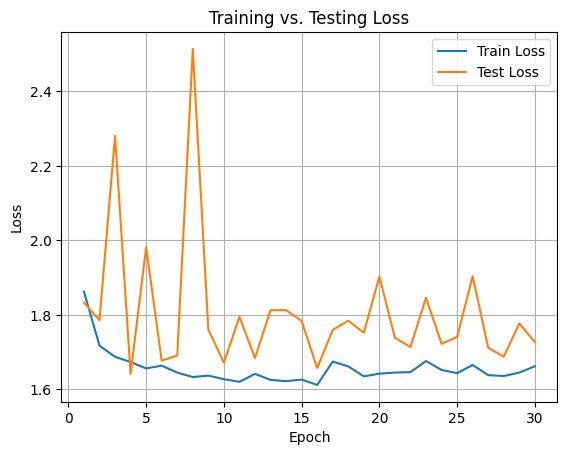

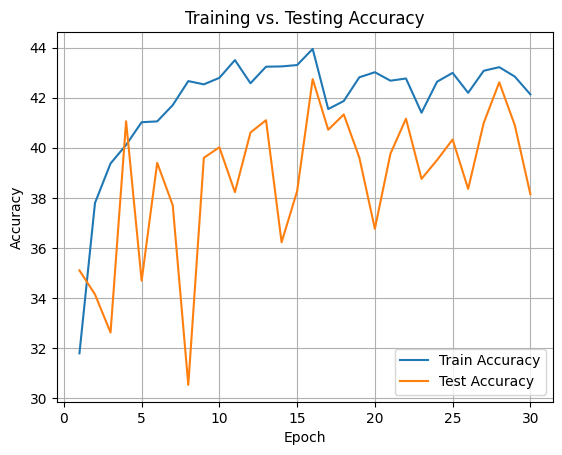

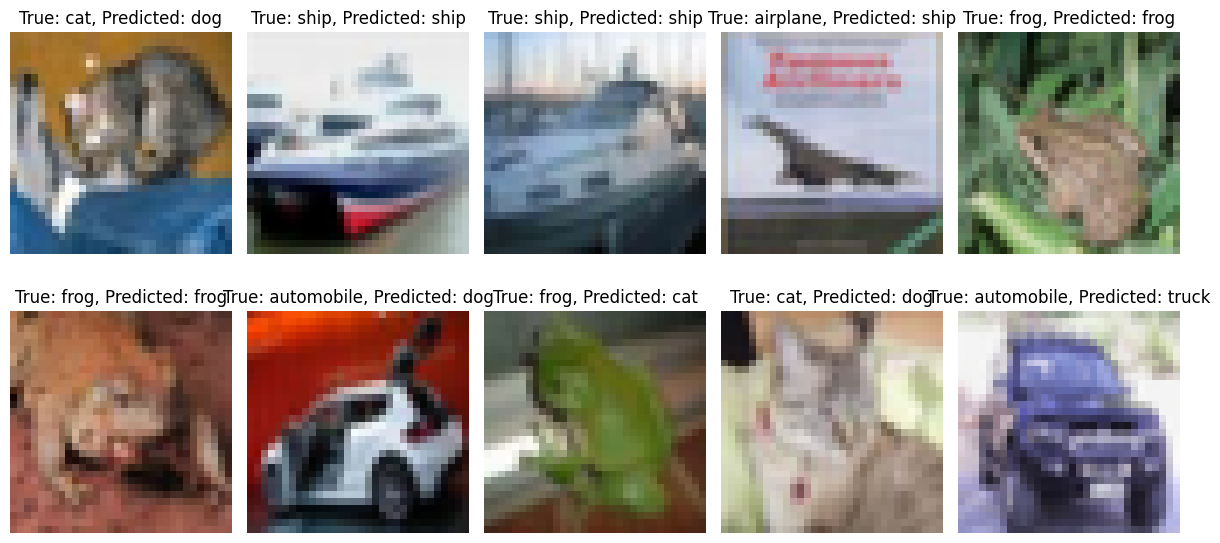

In [ ]:
from __future__ import print_function
%load_ext autoreload
%autoreload 2
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from ConvNet import ConvNet
import argparse
import numpy as np

def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''

    # Set model to train mode before each epoch
    model.train()

    # Empty list to store losses
    losses = []
    correct = 0

    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample

        # Push data/label to correct device
        data, target = data.to(device), target.to(device)
        # print(data.shape)
        # print(target.shape)
        # exit()

        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()

        # Do forward pass for current set of data
        output = model(data)

        # ======================================================================
        # Compute loss based on criterion
        #loss = NotImplementedError()
        loss = criterion(output, target)

        # Computes gradient based on final loss
        loss.backward()

        # Store loss
        losses.append(loss.item())

        # Optimize model parameters based on learning rate and gradient
        optimizer.step()

        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # ======================================================================
        # Count correct predictions overall
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc



def test(model, device, test_loader):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''

    # Set model to eval mode to notify all layers.
    model.eval()

    losses = []
    correct = 0

    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)


            # Predict for data by doing forward pass
            output = model(data)

            # ======================================================================
            # Compute loss based on same criterion as training
            loss = F.cross_entropy(output, target, reduction='mean')

            # Append loss to overall test loss
            losses.append(loss.item())

            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # ======================================================================
            # Count correct predictions overall
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy


def run_main(FLAGS):
    # Check if cuda is available
    use_cuda = torch.cuda.is_available()

    # Set proper device based on cuda availability
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Torch device selected: ", device)

    # Initialize the model and send to device
    model = ConvNet(FLAGS.mode).to(device)
    # print(model)
    # exit()

    # Initialize the criterion for loss computation
    criterion = nn.CrossEntropyLoss(reduction='mean')

    # Initialize optimizer type
    optimizer = optim.SGD(model.parameters(), lr=FLAGS.learning_rate, weight_decay=1e-7)

    # Create transformations to apply to each data sample
    # Can specify variations such as image flip, color flip, random crop, ...
    #transform=transforms.Compose([
    #    transforms.ToTensor(),
    #    transforms.Normalize((0.1307,), (0.3081,))
    #    ])

    transform = transforms.Compose(
                    [transforms.ToTensor(),
                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # Load datasets for training and testing
    # Inbuilt datasets available in torchvision (check documentation online)
    dataset1 = datasets.CIFAR10('./data/', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.CIFAR10('./data/', train=False,
                       transform=transform)
    train_loader = DataLoader(dataset1, batch_size = FLAGS.batch_size,
                                shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset2, batch_size = FLAGS.batch_size,
                                shuffle=False, num_workers=4)

    best_accuracy = 0.0

    train_losses, test_losses = [], []
    train_accs,   test_accs   = [], []
    # Run training for n_epochs specified in config
    for epoch in range(1, FLAGS.num_epochs + 1):
        print("\nEpoch: ", epoch)
        train_loss, train_accuracy = train(model, device, train_loader,
                                            optimizer, criterion, epoch, FLAGS.batch_size)
        test_loss, test_accuracy = test(model, device, test_loader)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

        train_losses.append(train_loss)
        train_accs.append(100*train_accuracy)
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)

    print("accuracy is {:2.2f}".format(best_accuracy))

    print("Training and evaluation finished")
#plot loss
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, FLAGS.num_epochs+1), test_losses,  label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs. Testing Loss')
    plt.legend()
    plt.grid()
    plt.show()

    #plot accuracies
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, FLAGS.num_epochs+1), test_accs,  label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Testing Accuracy')
    plt.legend()
    plt.grid()
    plt.show()


    #visualize some test samples
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    classes = dataset1.classes
    with torch.no_grad():
      outputs = model(images)
      predicted = outputs.argmax(dim=1)

    plt.figure(figsize=(12, 6))
    for i in range(10):
      img = images[i].cpu().permute(1, 2, 0) *0.5 + 0.5
      plt.subplot(2, 5, i+1)
      plt.imshow(img)
      plt.title(f'True: {classes[labels[i]]}, Predicted: {classes[predicted[i]]}')
      plt.axis('off')
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    # Set parameters for Sparse Autoencoder
    parser = argparse.ArgumentParser('CNN Exercise.')
    parser.add_argument('--mode',
                        type=int, default=0,
                        help='Select mode between 0-3.')
    parser.add_argument('--learning_rate',
                        type=float, default=0.5,
                        help='Initial learning rate.')
    parser.add_argument('--num_epochs',
                        type=int,
                        default=30,
                        help='Number of epochs to run trainer.')
    parser.add_argument('--batch_size',
                        type=int, default=32,
                        help='Batch size. Must divide evenly into the dataset sizes.')
    parser.add_argument('--log_dir',
                        type=str,
                        default='logs',
                        help='Directory to put logging.')

    FLAGS = None
    FLAGS, unparsed = parser.parse_known_args()

    print("Mode: ", FLAGS.mode)
    print("LR: ", FLAGS.learning_rate)
    print("Batch size: ", FLAGS.batch_size)

    run_main(FLAGS)







So we pretty steadily increase training accuracy until about 43% around epoch 15-30. Testing definetely varies a lot more, peaking around 43% as well but has a lot of variability sometimes going to low 30s. Our training loss decreases and flattens while testing loss also has a lot of variability and almost seems random after epoch 10. I would not run this model past epoch 10-15 as it becomes too unstable and has clear overfitting, with training continuing to improve but testing loss and accuracy become very variable and doesnt improve much at all. We can see from the test loss spikes it more just starts to memorize instead of generalize. 43% is our best at epoch 16 and 28, so I would say 16 would be the max and for optimization no need to go past 15-16 epochs. The high lr of 0.5 is not consistent or stable. This took about 18 minutes and we can optimize around 9 minutes. lets try lr 0.1 and see our results. Im going to keep 30m epochs and analyze how it is at 10, 20, and 30.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mode:  0
LR:  0.1
Batch size:  32
Torch device selected:  cpu

Epoch:  1
Train set: Average loss: 1.6620, Accuracy: 19771/50016 (40%)
Test set: Average loss: 1.4359, Accuracy: 4869/10000 (49%)

Epoch:  2
Train set: Average loss: 1.3251, Accuracy: 26357/50016 (53%)
Test set: Average loss: 1.2886, Accuracy: 5380/10000 (54%)

Epoch:  3
Train set: Average loss: 1.1960, Accuracy: 28971/50016 (58%)
Test set: Average loss: 1.1806, Accuracy: 5830/10000 (58%)

Epoch:  4
Train set: Average loss: 1.1153, Accuracy: 30480/50016 (61%)
Test set: Average loss: 1.1256, Accuracy: 6015/10000 (60%)

Epoch:  5
Train set: Average loss: 1.0515, Accuracy: 31584/50016 (63%)
Test set: Average loss: 1.2365, Accuracy: 5691/10000 (57%)

Epoch:  6
Train set: Average loss: 1.0088, Accuracy: 32288/50016 (65%)
Test set: Average loss: 1.1967, Accuracy: 5882/10000 (59%)

Epoch:  7
Train set: Average loss: 0.9684, Accuracy: 33068/5001

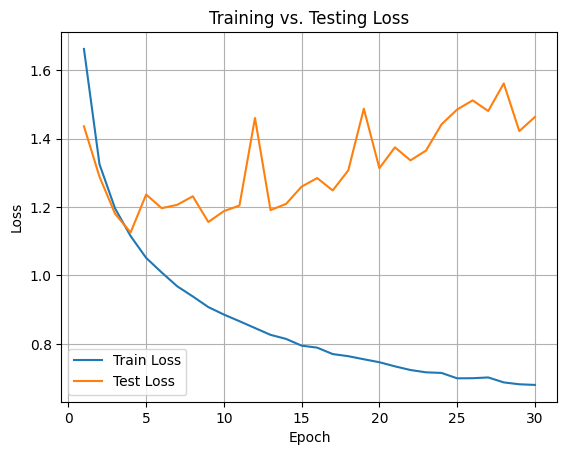

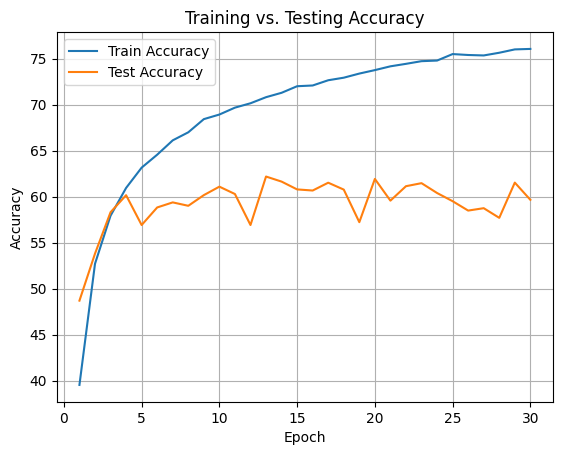

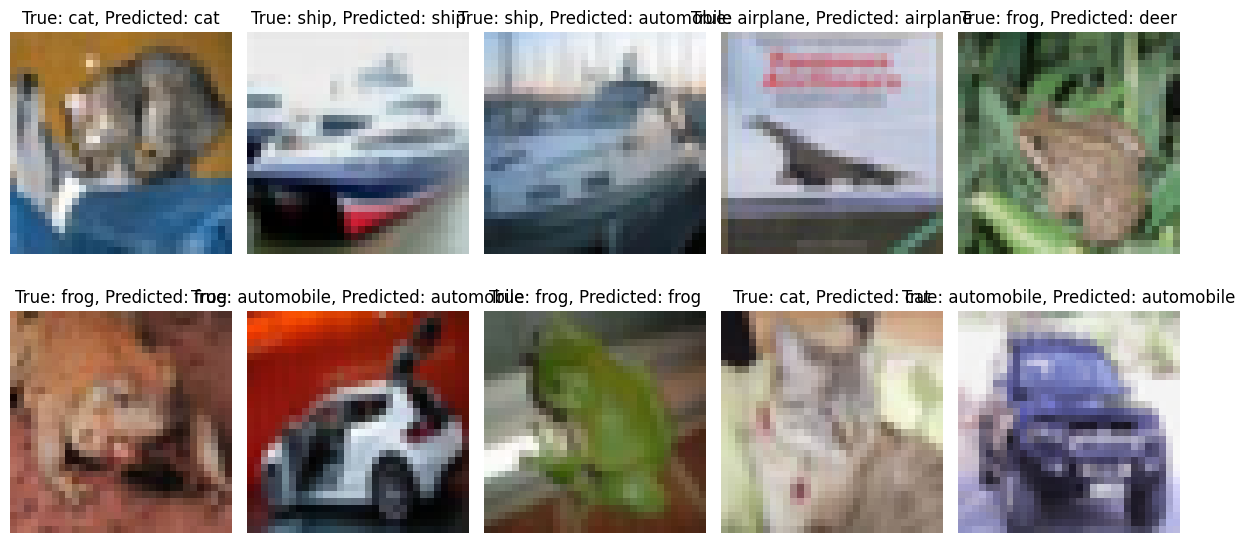

In [ ]:
from __future__ import print_function
%load_ext autoreload
%autoreload 2
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from ConvNet import ConvNet
import argparse
import numpy as np

def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''

    # Set model to train mode before each epoch
    model.train()

    # Empty list to store losses
    losses = []
    correct = 0

    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample

        # Push data/label to correct device
        data, target = data.to(device), target.to(device)
        # print(data.shape)
        # print(target.shape)
        # exit()

        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()

        # Do forward pass for current set of data
        output = model(data)

        # ======================================================================
        # Compute loss based on criterion
        #loss = NotImplementedError()
        loss = criterion(output, target)

        # Computes gradient based on final loss
        loss.backward()

        # Store loss
        losses.append(loss.item())

        # Optimize model parameters based on learning rate and gradient
        optimizer.step()

        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # ======================================================================
        # Count correct predictions overall
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc



def test(model, device, test_loader):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''

    # Set model to eval mode to notify all layers.
    model.eval()

    losses = []
    correct = 0

    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)


            # Predict for data by doing forward pass
            output = model(data)

            # ======================================================================
            # Compute loss based on same criterion as training
            loss = F.cross_entropy(output, target, reduction='mean')

            # Append loss to overall test loss
            losses.append(loss.item())

            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # ======================================================================
            # Count correct predictions overall
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy


def run_main(FLAGS):
    # Check if cuda is available
    use_cuda = torch.cuda.is_available()

    # Set proper device based on cuda availability
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Torch device selected: ", device)

    # Initialize the model and send to device
    model = ConvNet(FLAGS.mode).to(device)
    # print(model)
    # exit()

    # Initialize the criterion for loss computation
    criterion = nn.CrossEntropyLoss(reduction='mean')

    # Initialize optimizer type
    optimizer = optim.SGD(model.parameters(), lr=FLAGS.learning_rate, weight_decay=1e-7)

    # Create transformations to apply to each data sample
    # Can specify variations such as image flip, color flip, random crop, ...
    #transform=transforms.Compose([
    #    transforms.ToTensor(),
    #    transforms.Normalize((0.1307,), (0.3081,))
    #    ])

    transform = transforms.Compose(
                    [transforms.ToTensor(),
                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # Load datasets for training and testing
    # Inbuilt datasets available in torchvision (check documentation online)
    dataset1 = datasets.CIFAR10('./data/', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.CIFAR10('./data/', train=False,
                       transform=transform)
    train_loader = DataLoader(dataset1, batch_size = FLAGS.batch_size,
                                shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset2, batch_size = FLAGS.batch_size,
                                shuffle=False, num_workers=4)

    best_accuracy = 0.0

    train_losses, test_losses = [], []
    train_accs,   test_accs   = [], []
    # Run training for n_epochs specified in config
    for epoch in range(1, FLAGS.num_epochs + 1):
        print("\nEpoch: ", epoch)
        train_loss, train_accuracy = train(model, device, train_loader,
                                            optimizer, criterion, epoch, FLAGS.batch_size)
        test_loss, test_accuracy = test(model, device, test_loader)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

        train_losses.append(train_loss)
        train_accs.append(100*train_accuracy)
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)

    print("accuracy is {:2.2f}".format(best_accuracy))

    print("Training and evaluation finished")
#plot loss
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, FLAGS.num_epochs+1), test_losses,  label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs. Testing Loss')
    plt.legend()
    plt.grid()
    plt.show()

    #plot accuracies
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, FLAGS.num_epochs+1), test_accs,  label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Testing Accuracy')
    plt.legend()
    plt.grid()
    plt.show()


    #visualize some test samples
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    classes = dataset1.classes
    with torch.no_grad():
      outputs = model(images)
      predicted = outputs.argmax(dim=1)

    plt.figure(figsize=(12, 6))
    for i in range(10):
      img = images[i].cpu().permute(1, 2, 0) *0.5 + 0.5
      plt.subplot(2, 5, i+1)
      plt.imshow(img)
      plt.title(f'True: {classes[labels[i]]}, Predicted: {classes[predicted[i]]}')
      plt.axis('off')
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    # Set parameters for Sparse Autoencoder
    parser = argparse.ArgumentParser('CNN Exercise.')
    parser.add_argument('--mode',
                        type=int, default=0,
                        help='Select mode between 0-3.')
    parser.add_argument('--learning_rate',
                        type=float, default=0.1,
                        help='Initial learning rate.')
    parser.add_argument('--num_epochs',
                        type=int,
                        default=30,
                        help='Number of epochs to run trainer.')
    parser.add_argument('--batch_size',
                        type=int, default=32,
                        help='Batch size. Must divide evenly into the dataset sizes.')
    parser.add_argument('--log_dir',
                        type=str,
                        default='logs',
                        help='Directory to put logging.')

    FLAGS = None
    FLAGS, unparsed = parser.parse_known_args()

    print("Mode: ", FLAGS.mode)
    print("LR: ", FLAGS.learning_rate)
    print("Batch size: ", FLAGS.batch_size)

    run_main(FLAGS)







So the learning rate change definetely improved my results. Best accuracy and loss around epoch 13 so 30 is definetelty overkill for this. Training does improve after but test accuracy drops and becomes unstable. So it clearly starts to overfit.training loss improves until about epoch 6, then starts to become much more variable, and then increases after 15 another sign of overfitting. No need to go past epoch 13 for time and perfomrance. This again took about 18 minutes and can optimize not even halfway through at 9 minutes so lets run it to epoch 13 so we can see these results more closely

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mode:  0
LR:  0.1
Batch size:  32
Torch device selected:  cpu

Epoch:  1
Train set: Average loss: 1.6694, Accuracy: 19482/50016 (39%)
Test set: Average loss: 1.3998, Accuracy: 4806/10000 (48%)

Epoch:  2
Train set: Average loss: 1.3533, Accuracy: 25692/50016 (51%)
Test set: Average loss: 1.5501, Accuracy: 4698/10000 (47%)

Epoch:  3
Train set: Average loss: 1.2303, Accuracy: 28033/50016 (56%)
Test set: Average loss: 1.2734, Accuracy: 5499/10000 (55%)

Epoch:  4
Train set: Average loss: 1.1540, Accuracy: 29552/50016 (59%)
Test set: Average loss: 1.2318, Accuracy: 5707/10000 (57%)

Epoch:  5
Train set: Average loss: 1.0944, Accuracy: 30632/50016 (61%)
Test set: Average loss: 1.2407, Accuracy: 5782/10000 (58%)

Epoch:  6
Train set: Average loss: 1.0499, Accuracy: 31444/50016 (63%)
Test set: Average loss: 1.1911, Accuracy: 5854/10000 (59%)

Epoch:  7
Train set: Average loss: 1.0096, Accuracy: 32289/5001

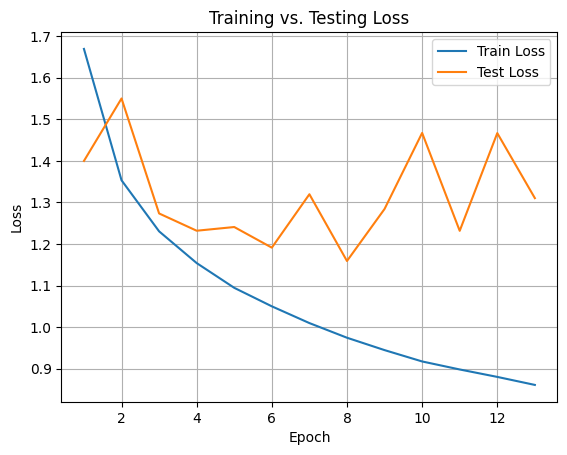

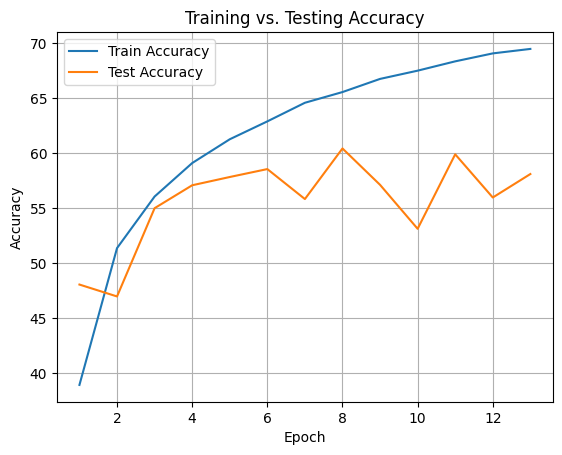

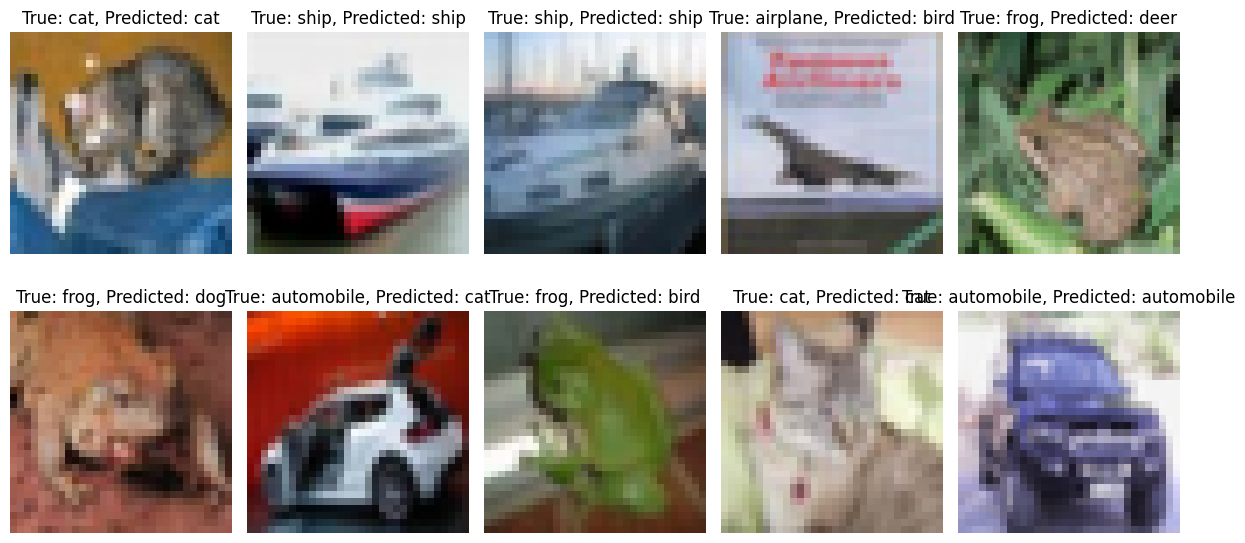

In [ ]:
from __future__ import print_function
%load_ext autoreload
%autoreload 2
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from ConvNet import ConvNet
import argparse
import numpy as np

def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''

    # Set model to train mode before each epoch
    model.train()

    # Empty list to store losses
    losses = []
    correct = 0

    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample

        # Push data/label to correct device
        data, target = data.to(device), target.to(device)
        # print(data.shape)
        # print(target.shape)
        # exit()

        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()

        # Do forward pass for current set of data
        output = model(data)

        # ======================================================================
        # Compute loss based on criterion
        #loss = NotImplementedError()
        loss = criterion(output, target)

        # Computes gradient based on final loss
        loss.backward()

        # Store loss
        losses.append(loss.item())

        # Optimize model parameters based on learning rate and gradient
        optimizer.step()

        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # ======================================================================
        # Count correct predictions overall
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc



def test(model, device, test_loader):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''

    # Set model to eval mode to notify all layers.
    model.eval()

    losses = []
    correct = 0

    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)


            # Predict for data by doing forward pass
            output = model(data)

            # ======================================================================
            # Compute loss based on same criterion as training
            loss = F.cross_entropy(output, target, reduction='mean')

            # Append loss to overall test loss
            losses.append(loss.item())

            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # ======================================================================
            # Count correct predictions overall
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy


def run_main(FLAGS):
    # Check if cuda is available
    use_cuda = torch.cuda.is_available()

    # Set proper device based on cuda availability
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Torch device selected: ", device)

    # Initialize the model and send to device
    model = ConvNet(FLAGS.mode).to(device)
    # print(model)
    # exit()

    # Initialize the criterion for loss computation
    criterion = nn.CrossEntropyLoss(reduction='mean')

    # Initialize optimizer type
    optimizer = optim.SGD(model.parameters(), lr=FLAGS.learning_rate, weight_decay=1e-7)

    # Create transformations to apply to each data sample
    # Can specify variations such as image flip, color flip, random crop, ...
    #transform=transforms.Compose([
    #    transforms.ToTensor(),
    #    transforms.Normalize((0.1307,), (0.3081,))
    #    ])

    transform = transforms.Compose(
                    [transforms.ToTensor(),
                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # Load datasets for training and testing
    # Inbuilt datasets available in torchvision (check documentation online)
    dataset1 = datasets.CIFAR10('./data/', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.CIFAR10('./data/', train=False,
                       transform=transform)
    train_loader = DataLoader(dataset1, batch_size = FLAGS.batch_size,
                                shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset2, batch_size = FLAGS.batch_size,
                                shuffle=False, num_workers=4)

    best_accuracy = 0.0

    train_losses, test_losses = [], []
    train_accs,   test_accs   = [], []
    # Run training for n_epochs specified in config
    for epoch in range(1, FLAGS.num_epochs + 1):
        print("\nEpoch: ", epoch)
        train_loss, train_accuracy = train(model, device, train_loader,
                                            optimizer, criterion, epoch, FLAGS.batch_size)
        test_loss, test_accuracy = test(model, device, test_loader)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

        train_losses.append(train_loss)
        train_accs.append(100*train_accuracy)
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)

    print("accuracy is {:2.2f}".format(best_accuracy))

    print("Training and evaluation finished")
#plot loss
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, FLAGS.num_epochs+1), test_losses,  label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs. Testing Loss')
    plt.legend()
    plt.grid()
    plt.show()

    #plot accuracies
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, FLAGS.num_epochs+1), test_accs,  label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Testing Accuracy')
    plt.legend()
    plt.grid()
    plt.show()


    #visualize some test samples
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    classes = dataset1.classes
    with torch.no_grad():
      outputs = model(images)
      predicted = outputs.argmax(dim=1)

    plt.figure(figsize=(12, 6))
    for i in range(10):
      img = images[i].cpu().permute(1, 2, 0) *0.5 + 0.5
      plt.subplot(2, 5, i+1)
      plt.imshow(img)
      plt.title(f'True: {classes[labels[i]]}, Predicted: {classes[predicted[i]]}')
      plt.axis('off')
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    # Set parameters for Sparse Autoencoder
    parser = argparse.ArgumentParser('CNN Exercise.')
    parser.add_argument('--mode',
                        type=int, default=0,
                        help='Select mode between 0-3.')
    parser.add_argument('--learning_rate',
                        type=float, default=0.1,
                        help='Initial learning rate.')
    parser.add_argument('--num_epochs',
                        type=int,
                        default=13,
                        help='Number of epochs to run trainer.')
    parser.add_argument('--batch_size',
                        type=int, default=32,
                        help='Batch size. Must divide evenly into the dataset sizes.')
    parser.add_argument('--log_dir',
                        type=str,
                        default='logs',
                        help='Directory to put logging.')

    FLAGS = None
    FLAGS, unparsed = parser.parse_known_args()

    print("Mode: ", FLAGS.mode)
    print("LR: ", FLAGS.learning_rate)
    print("Batch size: ", FLAGS.batch_size)

    run_main(FLAGS)







13 epochs is far better than 30 for 0.1 lr. we do still overfit though and that starts around epoch 8. It learns but doesn't generalize too well. We do climb from 39 to 69% training accuracy and test accurracy is best around epoch than starts to be variable. We can honestly run just 10 epochs for optimization of this lr. It took about 8 minutes and can even be shorter for optimization doing just 8-10 epochs. Lets move to our lr of 0.01 and see how this improves results. again well do 30 epochs and see where we should optimize at

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mode:  0
LR:  0.01
Batch size:  32
Torch device selected:  cpu

Epoch:  1
Train set: Average loss: 2.0870, Accuracy: 12240/50016 (24%)
Test set: Average loss: 1.8586, Accuracy: 3432/10000 (34%)

Epoch:  2
Train set: Average loss: 1.7290, Accuracy: 18925/50016 (38%)
Test set: Average loss: 1.5821, Accuracy: 4286/10000 (43%)

Epoch:  3
Train set: Average loss: 1.5107, Accuracy: 22789/50016 (46%)
Test set: Average loss: 1.4442, Accuracy: 4794/10000 (48%)

Epoch:  4
Train set: Average loss: 1.4129, Accuracy: 24464/50016 (49%)
Test set: Average loss: 1.4023, Accuracy: 4999/10000 (50%)

Epoch:  5
Train set: Average loss: 1.3478, Accuracy: 25787/50016 (52%)
Test set: Average loss: 1.3242, Accuracy: 5192/10000 (52%)

Epoch:  6
Train set: Average loss: 1.2910, Accuracy: 27029/50016 (54%)
Test set: Average loss: 1.3173, Accuracy: 5281/10000 (53%)

Epoch:  7
Train set: Average loss: 1.2446, Accuracy: 27831/500

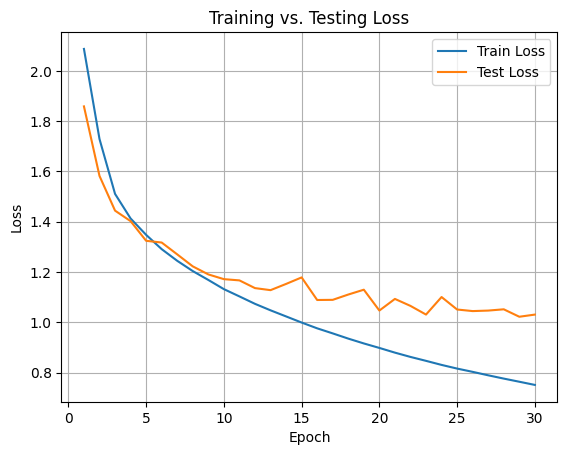

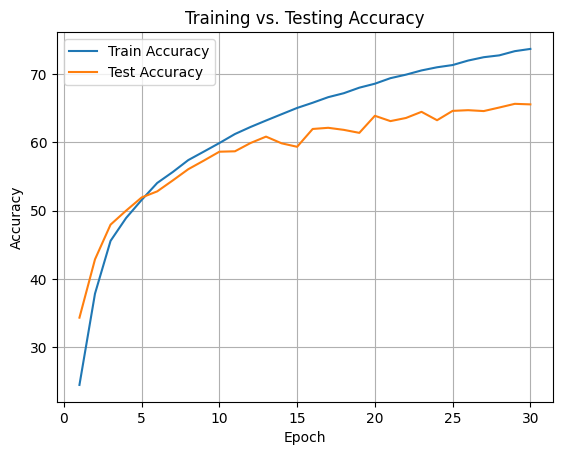

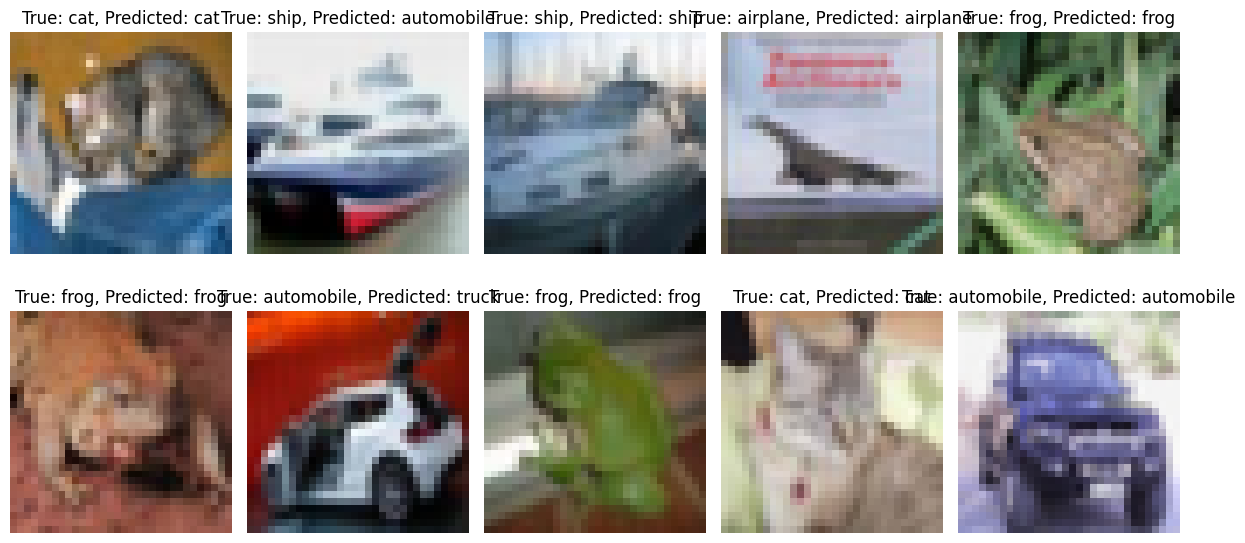

In [ ]:
from __future__ import print_function
%load_ext autoreload
%autoreload 2
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from ConvNet import ConvNet
import argparse
import numpy as np

def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''

    # Set model to train mode before each epoch
    model.train()

    # Empty list to store losses
    losses = []
    correct = 0

    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample

        # Push data/label to correct device
        data, target = data.to(device), target.to(device)
        # print(data.shape)
        # print(target.shape)
        # exit()

        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()

        # Do forward pass for current set of data
        output = model(data)

        # ======================================================================
        # Compute loss based on criterion
        #loss = NotImplementedError()
        loss = criterion(output, target)

        # Computes gradient based on final loss
        loss.backward()

        # Store loss
        losses.append(loss.item())

        # Optimize model parameters based on learning rate and gradient
        optimizer.step()

        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # ======================================================================
        # Count correct predictions overall
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc



def test(model, device, test_loader):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''

    # Set model to eval mode to notify all layers.
    model.eval()

    losses = []
    correct = 0

    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)


            # Predict for data by doing forward pass
            output = model(data)

            # ======================================================================
            # Compute loss based on same criterion as training
            loss = F.cross_entropy(output, target, reduction='mean')

            # Append loss to overall test loss
            losses.append(loss.item())

            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # ======================================================================
            # Count correct predictions overall
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy


def run_main(FLAGS):
    # Check if cuda is available
    use_cuda = torch.cuda.is_available()

    # Set proper device based on cuda availability
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Torch device selected: ", device)

    # Initialize the model and send to device
    model = ConvNet(FLAGS.mode).to(device)
    # print(model)
    # exit()

    # Initialize the criterion for loss computation
    criterion = nn.CrossEntropyLoss(reduction='mean')

    # Initialize optimizer type
    optimizer = optim.SGD(model.parameters(), lr=FLAGS.learning_rate, weight_decay=1e-7)

    # Create transformations to apply to each data sample
    # Can specify variations such as image flip, color flip, random crop, ...
    #transform=transforms.Compose([
    #    transforms.ToTensor(),
    #    transforms.Normalize((0.1307,), (0.3081,))
    #    ])

    transform = transforms.Compose(
                    [transforms.ToTensor(),
                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # Load datasets for training and testing
    # Inbuilt datasets available in torchvision (check documentation online)
    dataset1 = datasets.CIFAR10('./data/', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.CIFAR10('./data/', train=False,
                       transform=transform)
    train_loader = DataLoader(dataset1, batch_size = FLAGS.batch_size,
                                shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset2, batch_size = FLAGS.batch_size,
                                shuffle=False, num_workers=4)

    best_accuracy = 0.0

    train_losses, test_losses = [], []
    train_accs,   test_accs   = [], []
    # Run training for n_epochs specified in config
    for epoch in range(1, FLAGS.num_epochs + 1):
        print("\nEpoch: ", epoch)
        train_loss, train_accuracy = train(model, device, train_loader,
                                            optimizer, criterion, epoch, FLAGS.batch_size)
        test_loss, test_accuracy = test(model, device, test_loader)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

        train_losses.append(train_loss)
        train_accs.append(100*train_accuracy)
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)

    print("accuracy is {:2.2f}".format(best_accuracy))

    print("Training and evaluation finished")
#plot loss
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, FLAGS.num_epochs+1), test_losses,  label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs. Testing Loss')
    plt.legend()
    plt.grid()
    plt.show()

    #plot accuracies
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, FLAGS.num_epochs+1), test_accs,  label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Testing Accuracy')
    plt.legend()
    plt.grid()
    plt.show()


    #visualize some test samples
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    classes = dataset1.classes
    with torch.no_grad():
      outputs = model(images)
      predicted = outputs.argmax(dim=1)

    plt.figure(figsize=(12, 6))
    for i in range(10):
      img = images[i].cpu().permute(1, 2, 0) *0.5 + 0.5
      plt.subplot(2, 5, i+1)
      plt.imshow(img)
      plt.title(f'True: {classes[labels[i]]}, Predicted: {classes[predicted[i]]}')
      plt.axis('off')
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    # Set parameters for Sparse Autoencoder
    parser = argparse.ArgumentParser('CNN Exercise.')
    parser.add_argument('--mode',
                        type=int, default=0,
                        help='Select mode between 0-3.')
    parser.add_argument('--learning_rate',
                        type=float, default=0.01,
                        help='Initial learning rate.')
    parser.add_argument('--num_epochs',
                        type=int,
                        default=30,
                        help='Number of epochs to run trainer.')
    parser.add_argument('--batch_size',
                        type=int, default=32,
                        help='Batch size. Must divide evenly into the dataset sizes.')
    parser.add_argument('--log_dir',
                        type=str,
                        default='logs',
                        help='Directory to put logging.')

    FLAGS = None
    FLAGS, unparsed = parser.parse_known_args()

    print("Mode: ", FLAGS.mode)
    print("LR: ", FLAGS.learning_rate)
    print("Batch size: ", FLAGS.batch_size)

    run_main(FLAGS)







So this is our best results yet with this network. training and testing loss steadily decreases throughout, and doesnt vary from each other or much independently. So this does not have much overfitting and is generalizng pretty well. training accuracy smoothly increase from 24 to 74% and test accuracy smoothly increases from 34 to 66% another good sign of not overfitting and well generalization. It took about 20 minutes to run and for speed, epoch 10-15 is plenty with solid results and would take only about 10 minutes, but for performance going to 30 is a good idea. The other learning rates were much more unstable and had much more overfitting, this one is by far the best generalizer. These are good results lets move to task 5 and improve this architecture and network.

In [ ]:
%%writefile ConvNet.py
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self, mode):
        super(ConvNet, self).__init__()

        # Define various layers here, such as in the tutorial example
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        #self.conv2 = Make conv layer like above
        self.conv2 = nn.Conv2d(10, 10, kernel_size=3)
        #self.conv3 = Make conv layer like above

        self.conv1_m2 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=3)
        self.conv2_m2 = nn.Conv2d(in_channels=20, out_channels=40, kernel_size=3)


        self.fc1_model1 = nn.Linear(360, 100)  # This is first fully connected layer for step 1.
        self.fc1_model2 = nn.Linear(1440, 100) # This is first fully connected layer for step 2.
        self.fc1_model3 = nn.Linear(640, 100)  # This is first fully connected layer for step 3

        self.fc2 = nn.Linear(100, 10)       # This is 2nd fully connected layer for all models.

        #self.fc_model0 = nn.Linear(2250, 100)   # This is for example model.
        self.fc_model0 = nn.Linear(360, 100)


        # This will select the forward pass function based on mode for the ConvNet.
        # Based on the question, you have 3 modes available for step 1 to 3.
        # During creation of each ConvNet model, you will assign one of the valid mode.
        # This will fix the forward function (and the network graph) for the entire training/testing
        if mode == 1:
            self.forward = self.model_1
        elif mode == 2:
            self.forward = self.model_2
        elif mode == 3:
            self.forward = self.model_3
        elif mode == 0:
            self.forward = self.model_0
        else:
            print("Invalid mode ", mode, "selected. Select between 1-3")
            exit(0)


    # Example model. Modify this for step 1-3
    def model_0(self, X):
        # ======================================================================
        #2 conv2d layers with ReLU, followed by maxpool2d
        X = F.relu(self.conv1(X)) #conv layer 1
        #print(X.shape)
        X = F.max_pool2d(X, kernel_size=2) #pool 1
        #print(X.shape)

        #self.conv2 = nn.Conv2d(10, 10, kernel_size=3) #layer 2 is in init
        X = F.relu(self.conv2(X))
        #print(X.shape)
        X = F.max_pool2d(X, kernel_size=2) # pool 2
        #print(X.shape

        X = torch.flatten(X, start_dim=1) #flatten
        #print(X.shape)

        X = F.relu(self.fc_model0(X)) #fully connected layers
        X = self.fc2(X)

        return X


    # Simple CNN. step 1
    def model_1(self, X):
        # ======================================================================

        # Complete this part as model_0, add one more conv2d layer
        # with relu activation followed by maxpool layer.

        X = torch.flatten(X, start_dim=1)

        X = F.relu(self.fc1_model1(X))
        X = self.fc2(X)

        return X


    # Increase filters. step 2
    def model_2(self, X):
        # ======================================================================

        # Complete this part as model_1. Modify in/out channels for conv2d layers.
        X = F.relu(self.conv1_m2(X))
        X = F.max_pool2d(X, kernel_size=2)
        X = F.relu(self.conv2_m2(X))
        X = F.max_pool2d(X, kernel_size=2)
        X = torch.flatten(X, start_dim=1)

        X = F.relu(self.fc1_model2(X))
        X = self.fc2(X)

        return X


    # Large CNN. step 3
    def model_3(self, X):
        # ======================================================================

        # Complete this part as model_2, add one more conv2d layer
        # with relu activation. Do not add maxpool after this new conv2d layer.

        X = torch.flatten(X, start_dim=1)

        X = F.relu(self.fc1_model3(X))
        X = self.fc2(X)

        return X






Overwriting ConvNet.py


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mode:  2
LR:  0.1
Batch size:  32
Torch device selected:  cpu

Epoch:  1


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train set: Average loss: 1.5301, Accuracy: 22149/50016 (44%)
Test set: Average loss: 1.5543, Accuracy: 4613/10000 (46%)

Epoch:  2
Train set: Average loss: 1.1181, Accuracy: 30201/50016 (60%)
Test set: Average loss: 1.1463, Accuracy: 5955/10000 (60%)

Epoch:  3
Train set: Average loss: 0.9354, Accuracy: 33648/50016 (67%)
Test set: Average loss: 0.9975, Accuracy: 6508/10000 (65%)

Epoch:  4
Train set: Average loss: 0.8171, Accuracy: 35694/50016 (71%)
Test set: Average loss: 1.0067, Accuracy: 6575/10000 (66%)

Epoch:  5
Train set: Average loss: 0.7239, Accuracy: 37389/50016 (75%)
Test set: Average loss: 1.0112, Accuracy: 6624/10000 (66%)

Epoch:  6
Train set: Average loss: 0.6370, Accuracy: 38726/50016 (77%)
Test set: Average loss: 1.0590, Accuracy: 6679/10000 (67%)

Epoch:  7
Train set: Average loss: 0.5650, Accuracy: 39923/50016 (80%)
Test set: Average loss: 1.1227, Accuracy: 6534/10000 (65%)

Epoch:  8
Train set: Average loss: 0.5078, Accuracy: 41063/50016 (82%)
Test set: Average loss

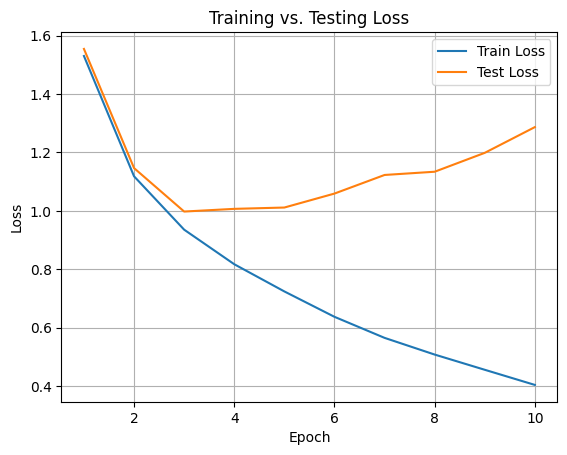

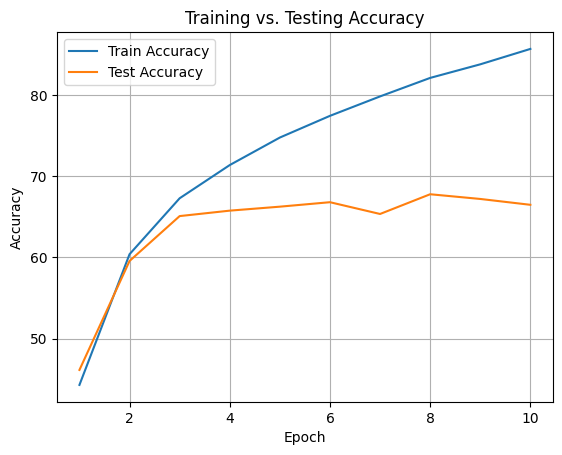

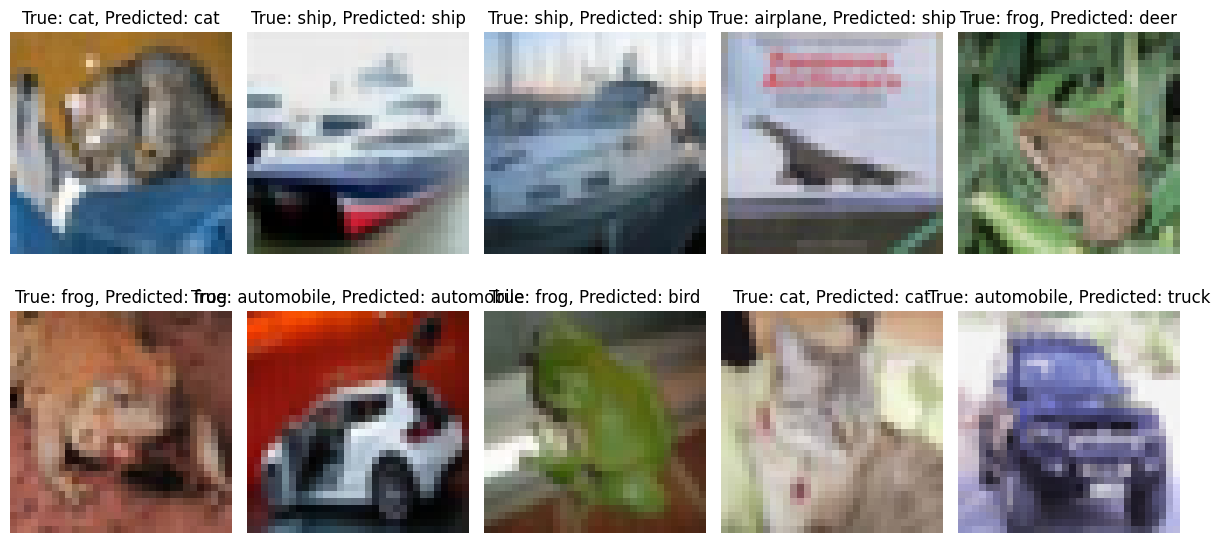

In [ ]:
from __future__ import print_function
%load_ext autoreload
%autoreload 2
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from ConvNet import ConvNet
import argparse
import numpy as np

def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''

    # Set model to train mode before each epoch
    model.train()

    # Empty list to store losses
    losses = []
    correct = 0

    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample

        # Push data/label to correct device
        data, target = data.to(device), target.to(device)
        # print(data.shape)
        # print(target.shape)
        # exit()

        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()

        # Do forward pass for current set of data
        output = model(data)

        # ======================================================================
        # Compute loss based on criterion
        #loss = NotImplementedError()
        loss = criterion(output, target)

        # Computes gradient based on final loss
        loss.backward()

        # Store loss
        losses.append(loss.item())

        # Optimize model parameters based on learning rate and gradient
        optimizer.step()

        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # ======================================================================
        # Count correct predictions overall
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc



def test(model, device, test_loader):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''

    # Set model to eval mode to notify all layers.
    model.eval()

    losses = []
    correct = 0

    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)


            # Predict for data by doing forward pass
            output = model(data)

            # ======================================================================
            # Compute loss based on same criterion as training
            loss = F.cross_entropy(output, target, reduction='mean')

            # Append loss to overall test loss
            losses.append(loss.item())

            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # ======================================================================
            # Count correct predictions overall
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy


def run_main(FLAGS):
    # Check if cuda is available
    use_cuda = torch.cuda.is_available()

    # Set proper device based on cuda availability
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Torch device selected: ", device)

    # Initialize the model and send to device
    model = ConvNet(FLAGS.mode).to(device)
    # print(model)
    # exit()

    # Initialize the criterion for loss computation
    criterion = nn.CrossEntropyLoss(reduction='mean')

    # Initialize optimizer type
    optimizer = optim.SGD(model.parameters(), lr=FLAGS.learning_rate, weight_decay=1e-7)

    # Create transformations to apply to each data sample
    # Can specify variations such as image flip, color flip, random crop, ...
    #transform=transforms.Compose([
    #    transforms.ToTensor(),
    #    transforms.Normalize((0.1307,), (0.3081,))
    #    ])

    transform = transforms.Compose(
                    [transforms.ToTensor(),
                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # Load datasets for training and testing
    # Inbuilt datasets available in torchvision (check documentation online)
    dataset1 = datasets.CIFAR10('./data/', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.CIFAR10('./data/', train=False,
                       transform=transform)
    train_loader = DataLoader(dataset1, batch_size = FLAGS.batch_size,
                                shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset2, batch_size = FLAGS.batch_size,
                                shuffle=False, num_workers=4)

    best_accuracy = 0.0

    train_losses, test_losses = [], []
    train_accs,   test_accs   = [], []
    # Run training for n_epochs specified in config
    for epoch in range(1, FLAGS.num_epochs + 1):
        print("\nEpoch: ", epoch)
        train_loss, train_accuracy = train(model, device, train_loader,
                                            optimizer, criterion, epoch, FLAGS.batch_size)
        test_loss, test_accuracy = test(model, device, test_loader)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

        train_losses.append(train_loss)
        train_accs.append(100*train_accuracy)
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)

    print("accuracy is {:2.2f}".format(best_accuracy))

    print("Training and evaluation finished")
#plot loss
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, FLAGS.num_epochs+1), test_losses,  label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs. Testing Loss')
    plt.legend()
    plt.grid()
    plt.show()

    #plot accuracies
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, FLAGS.num_epochs+1), test_accs,  label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Testing Accuracy')
    plt.legend()
    plt.grid()
    plt.show()


    #visualize some test samples
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    classes = dataset1.classes
    with torch.no_grad():
      outputs = model(images)
      predicted = outputs.argmax(dim=1)

    plt.figure(figsize=(12, 6))
    for i in range(10):
      img = images[i].cpu().permute(1, 2, 0) *0.5 + 0.5
      plt.subplot(2, 5, i+1)
      plt.imshow(img)
      plt.title(f'True: {classes[labels[i]]}, Predicted: {classes[predicted[i]]}')
      plt.axis('off')
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    # Set parameters for Sparse Autoencoder
    parser = argparse.ArgumentParser('CNN Exercise.')
    parser.add_argument('--mode',
                        type=int, default=2,
                        help='Select mode between 0-3.')
    parser.add_argument('--learning_rate',
                        type=float, default=0.1,
                        help='Initial learning rate.')
    parser.add_argument('--num_epochs',
                        type=int,
                        default=10,
                        help='Number of epochs to run trainer.')
    parser.add_argument('--batch_size',
                        type=int, default=32,
                        help='Batch size. Must divide evenly into the dataset sizes.')
    parser.add_argument('--log_dir',
                        type=str,
                        default='logs',
                        help='Directory to put logging.')

    FLAGS = None
    FLAGS, unparsed = parser.parse_known_args()

    print("Mode: ", FLAGS.mode)
    print("LR: ", FLAGS.learning_rate)
    print("Batch size: ", FLAGS.batch_size)

    run_main(FLAGS)







Training loss steadily deceases from 1.53 to 0.4 so has good stable convergence. Testing loss does imply some overfitting as it rises after epoch 6, starting to degrade. trainign and test accuracy have a similar trwnd, training getting to 86% by epoch 10, while test peaks at epoch 8 at 68% and then plateaus. We will run more epochs to test but as of now the most optimal would be to stop around epoch 8. It did take about 12 minutes to run but did also improve on the simpler networks.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mode:  2
LR:  0.1
Batch size:  32
Torch device selected:  cpu

Epoch:  1
Train set: Average loss: 1.5362, Accuracy: 22143/50016 (44%)
Test set: Average loss: 1.3306, Accuracy: 5349/10000 (53%)

Epoch:  2
Train set: Average loss: 1.1119, Accuracy: 30399/50016 (61%)
Test set: Average loss: 1.1409, Accuracy: 5927/10000 (59%)

Epoch:  3
Train set: Average loss: 0.9381, Accuracy: 33602/50016 (67%)
Test set: Average loss: 1.0874, Accuracy: 6305/10000 (63%)

Epoch:  4
Train set: Average loss: 0.8169, Accuracy: 35668/50016 (71%)
Test set: Average loss: 0.9149, Accuracy: 6812/10000 (68%)

Epoch:  5
Train set: Average loss: 0.7181, Accuracy: 37409/50016 (75%)
Test set: Average loss: 1.1053, Accuracy: 6364/10000 (64%)

Epoch:  6
Train set: Average loss: 0.6348, Accuracy: 38905/50016 (78%)
Test set: Average loss: 1.0420, Accuracy: 6704/10000 (67%)

Epoch:  7
Train set: Average loss: 0.5608, Accuracy: 40172/5001

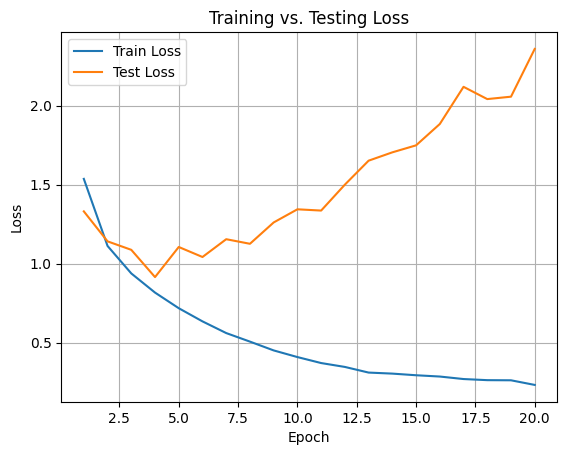

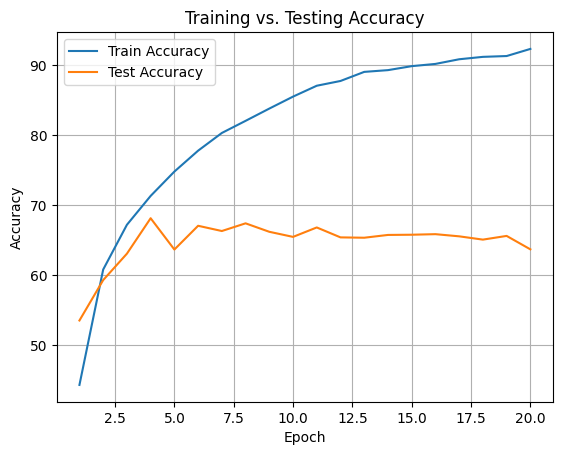

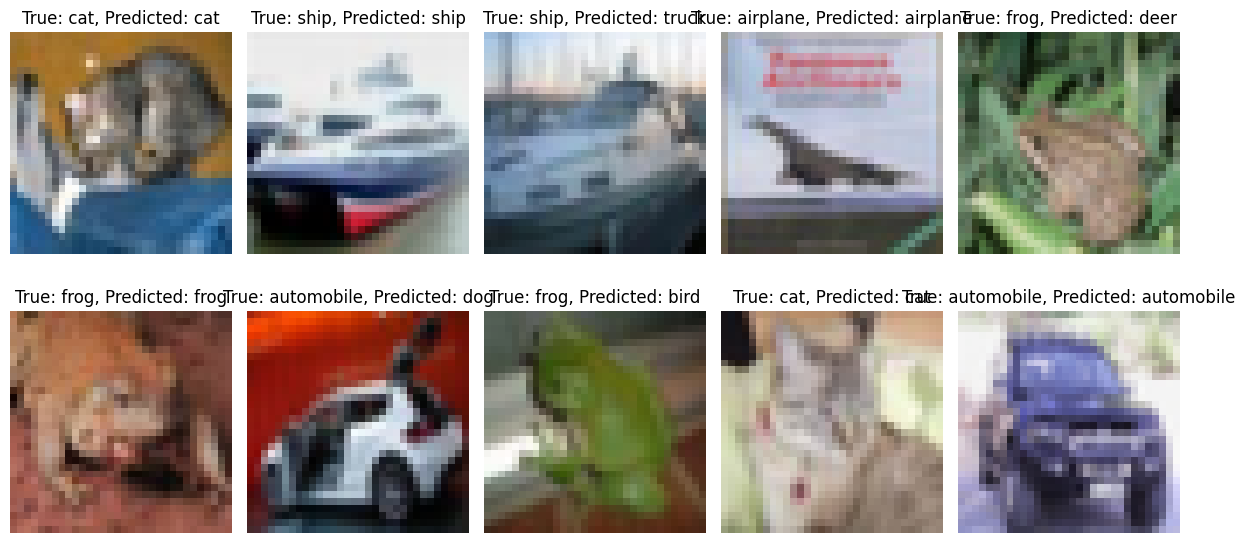

In [ ]:
from __future__ import print_function
%load_ext autoreload
%autoreload 2
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from ConvNet import ConvNet
import argparse
import numpy as np

def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''

    # Set model to train mode before each epoch
    model.train()

    # Empty list to store losses
    losses = []
    correct = 0

    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample

        # Push data/label to correct device
        data, target = data.to(device), target.to(device)
        # print(data.shape)
        # print(target.shape)
        # exit()

        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()

        # Do forward pass for current set of data
        output = model(data)

        # ======================================================================
        # Compute loss based on criterion
        #loss = NotImplementedError()
        loss = criterion(output, target)

        # Computes gradient based on final loss
        loss.backward()

        # Store loss
        losses.append(loss.item())

        # Optimize model parameters based on learning rate and gradient
        optimizer.step()

        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # ======================================================================
        # Count correct predictions overall
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc



def test(model, device, test_loader):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''

    # Set model to eval mode to notify all layers.
    model.eval()

    losses = []
    correct = 0

    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)


            # Predict for data by doing forward pass
            output = model(data)

            # ======================================================================
            # Compute loss based on same criterion as training
            loss = F.cross_entropy(output, target, reduction='mean')

            # Append loss to overall test loss
            losses.append(loss.item())

            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # ======================================================================
            # Count correct predictions overall
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy


def run_main(FLAGS):
    # Check if cuda is available
    use_cuda = torch.cuda.is_available()

    # Set proper device based on cuda availability
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Torch device selected: ", device)

    # Initialize the model and send to device
    model = ConvNet(FLAGS.mode).to(device)
    # print(model)
    # exit()

    # Initialize the criterion for loss computation
    criterion = nn.CrossEntropyLoss(reduction='mean')

    # Initialize optimizer type
    optimizer = optim.SGD(model.parameters(), lr=FLAGS.learning_rate, weight_decay=1e-7)

    # Create transformations to apply to each data sample
    # Can specify variations such as image flip, color flip, random crop, ...
    #transform=transforms.Compose([
    #    transforms.ToTensor(),
    #    transforms.Normalize((0.1307,), (0.3081,))
    #    ])

    transform = transforms.Compose(
                    [transforms.ToTensor(),
                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # Load datasets for training and testing
    # Inbuilt datasets available in torchvision (check documentation online)
    dataset1 = datasets.CIFAR10('./data/', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.CIFAR10('./data/', train=False,
                       transform=transform)
    train_loader = DataLoader(dataset1, batch_size = FLAGS.batch_size,
                                shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset2, batch_size = FLAGS.batch_size,
                                shuffle=False, num_workers=4)

    best_accuracy = 0.0

    train_losses, test_losses = [], []
    train_accs,   test_accs   = [], []
    # Run training for n_epochs specified in config
    for epoch in range(1, FLAGS.num_epochs + 1):
        print("\nEpoch: ", epoch)
        train_loss, train_accuracy = train(model, device, train_loader,
                                            optimizer, criterion, epoch, FLAGS.batch_size)
        test_loss, test_accuracy = test(model, device, test_loader)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

        train_losses.append(train_loss)
        train_accs.append(100*train_accuracy)
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)

    print("accuracy is {:2.2f}".format(best_accuracy))

    print("Training and evaluation finished")
#plot loss
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, FLAGS.num_epochs+1), test_losses,  label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs. Testing Loss')
    plt.legend()
    plt.grid()
    plt.show()

    #plot accuracies
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, FLAGS.num_epochs+1), test_accs,  label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Testing Accuracy')
    plt.legend()
    plt.grid()
    plt.show()


    #visualize some test samples
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    classes = dataset1.classes
    with torch.no_grad():
      outputs = model(images)
      predicted = outputs.argmax(dim=1)

    plt.figure(figsize=(12, 6))
    for i in range(10):
      img = images[i].cpu().permute(1, 2, 0) *0.5 + 0.5
      plt.subplot(2, 5, i+1)
      plt.imshow(img)
      plt.title(f'True: {classes[labels[i]]}, Predicted: {classes[predicted[i]]}')
      plt.axis('off')
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    # Set parameters for Sparse Autoencoder
    parser = argparse.ArgumentParser('CNN Exercise.')
    parser.add_argument('--mode',
                        type=int, default=2,
                        help='Select mode between 0-3.')
    parser.add_argument('--learning_rate',
                        type=float, default=0.1,
                        help='Initial learning rate.')
    parser.add_argument('--num_epochs',
                        type=int,
                        default=20,
                        help='Number of epochs to run trainer.')
    parser.add_argument('--batch_size',
                        type=int, default=32,
                        help='Batch size. Must divide evenly into the dataset sizes.')
    parser.add_argument('--log_dir',
                        type=str,
                        default='logs',
                        help='Directory to put logging.')

    FLAGS = None
    FLAGS, unparsed = parser.parse_known_args()

    print("Mode: ", FLAGS.mode)
    print("LR: ", FLAGS.learning_rate)
    print("Batch size: ", FLAGS.batch_size)

    run_main(FLAGS)







It is the same as before more epochs didnt improve the model. test loss gets worse while training error keeps dropping suggesting overfitting. The model is more just memorizing the training data and not generalizing. Again training accuracy rises and gets to 92% while test accuracy omly gets to about 68% and that was reached as early as epoch 4. Again suggesting overfitting. Took about 20 minutes to run and would be more optimized just running epoch through 5-10 and could take a third of the time.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mode:  2
LR:  0.1
Batch size:  32
Torch device selected:  cpu

Epoch:  1
Train set: Average loss: 1.5359, Accuracy: 22410/50016 (45%)
Test set: Average loss: 1.1652, Accuracy: 5863/10000 (59%)

Epoch:  2
Train set: Average loss: 1.1061, Accuracy: 30558/50016 (61%)
Test set: Average loss: 1.1765, Accuracy: 5961/10000 (60%)

Epoch:  3
Train set: Average loss: 0.9488, Accuracy: 33324/50016 (67%)
Test set: Average loss: 1.0412, Accuracy: 6406/10000 (64%)

Epoch:  4
Train set: Average loss: 0.8294, Accuracy: 35546/50016 (71%)
Test set: Average loss: 1.1144, Accuracy: 6181/10000 (62%)

Epoch:  5
Train set: Average loss: 0.7317, Accuracy: 37207/50016 (74%)
Test set: Average loss: 1.0628, Accuracy: 6540/10000 (65%)

Epoch:  6
Train set: Average loss: 0.6482, Accuracy: 38549/50016 (77%)
Test set: Average loss: 0.9736, Accuracy: 6816/10000 (68%)

Epoch:  7
Train set: Average loss: 0.5736, Accuracy: 39817/5001

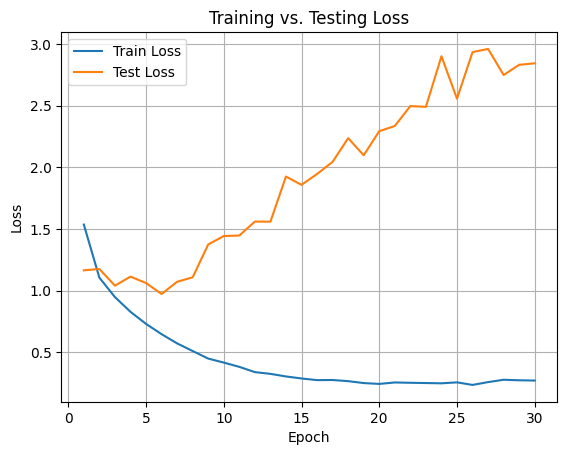

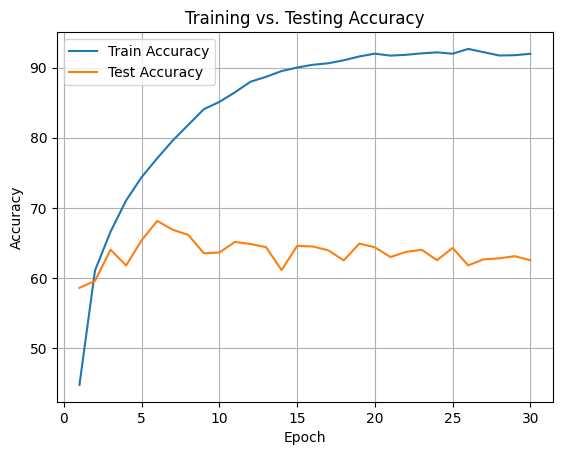

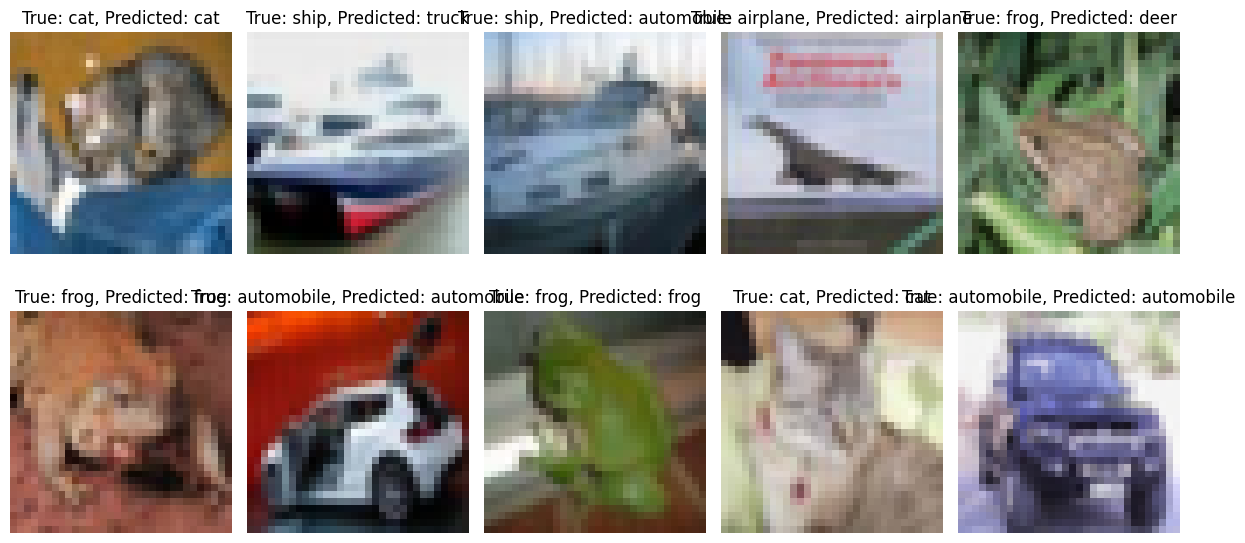

In [ ]:
from __future__ import print_function
%load_ext autoreload
%autoreload 2
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from ConvNet import ConvNet
import argparse
import numpy as np

def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''

    # Set model to train mode before each epoch
    model.train()

    # Empty list to store losses
    losses = []
    correct = 0

    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample

        # Push data/label to correct device
        data, target = data.to(device), target.to(device)
        # print(data.shape)
        # print(target.shape)
        # exit()

        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()

        # Do forward pass for current set of data
        output = model(data)

        # ======================================================================
        # Compute loss based on criterion
        #loss = NotImplementedError()
        loss = criterion(output, target)

        # Computes gradient based on final loss
        loss.backward()

        # Store loss
        losses.append(loss.item())

        # Optimize model parameters based on learning rate and gradient
        optimizer.step()

        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # ======================================================================
        # Count correct predictions overall
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc



def test(model, device, test_loader):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''

    # Set model to eval mode to notify all layers.
    model.eval()

    losses = []
    correct = 0

    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)


            # Predict for data by doing forward pass
            output = model(data)

            # ======================================================================
            # Compute loss based on same criterion as training
            loss = F.cross_entropy(output, target, reduction='mean')

            # Append loss to overall test loss
            losses.append(loss.item())

            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # ======================================================================
            # Count correct predictions overall
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy


def run_main(FLAGS):
    # Check if cuda is available
    use_cuda = torch.cuda.is_available()

    # Set proper device based on cuda availability
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Torch device selected: ", device)

    # Initialize the model and send to device
    model = ConvNet(FLAGS.mode).to(device)
    # print(model)
    # exit()

    # Initialize the criterion for loss computation
    criterion = nn.CrossEntropyLoss(reduction='mean')

    # Initialize optimizer type
    optimizer = optim.SGD(model.parameters(), lr=FLAGS.learning_rate, weight_decay=1e-7)

    # Create transformations to apply to each data sample
    # Can specify variations such as image flip, color flip, random crop, ...
    #transform=transforms.Compose([
    #    transforms.ToTensor(),
    #    transforms.Normalize((0.1307,), (0.3081,))
    #    ])

    transform = transforms.Compose(
                    [transforms.ToTensor(),
                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # Load datasets for training and testing
    # Inbuilt datasets available in torchvision (check documentation online)
    dataset1 = datasets.CIFAR10('./data/', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.CIFAR10('./data/', train=False,
                       transform=transform)
    train_loader = DataLoader(dataset1, batch_size = FLAGS.batch_size,
                                shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset2, batch_size = FLAGS.batch_size,
                                shuffle=False, num_workers=4)

    best_accuracy = 0.0

    train_losses, test_losses = [], []
    train_accs,   test_accs   = [], []
    # Run training for n_epochs specified in config
    for epoch in range(1, FLAGS.num_epochs + 1):
        print("\nEpoch: ", epoch)
        train_loss, train_accuracy = train(model, device, train_loader,
                                            optimizer, criterion, epoch, FLAGS.batch_size)
        test_loss, test_accuracy = test(model, device, test_loader)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

        train_losses.append(train_loss)
        train_accs.append(100*train_accuracy)
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)

    print("accuracy is {:2.2f}".format(best_accuracy))

    print("Training and evaluation finished")
#plot loss
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, FLAGS.num_epochs+1), test_losses,  label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs. Testing Loss')
    plt.legend()
    plt.grid()
    plt.show()

    #plot accuracies
    plt.figure()
    plt.plot(range(1, FLAGS.num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, FLAGS.num_epochs+1), test_accs,  label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Testing Accuracy')
    plt.legend()
    plt.grid()
    plt.show()


    #visualize some test samples
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    classes = dataset1.classes
    with torch.no_grad():
      outputs = model(images)
      predicted = outputs.argmax(dim=1)

    plt.figure(figsize=(12, 6))
    for i in range(10):
      img = images[i].cpu().permute(1, 2, 0) *0.5 + 0.5
      plt.subplot(2, 5, i+1)
      plt.imshow(img)
      plt.title(f'True: {classes[labels[i]]}, Predicted: {classes[predicted[i]]}')
      plt.axis('off')
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    # Set parameters for Sparse Autoencoder
    parser = argparse.ArgumentParser('CNN Exercise.')
    parser.add_argument('--mode',
                        type=int, default=2,
                        help='Select mode between 0-3.')
    parser.add_argument('--learning_rate',
                        type=float, default=0.1,
                        help='Initial learning rate.')
    parser.add_argument('--num_epochs',
                        type=int,
                        default=30,
                        help='Number of epochs to run trainer.')
    parser.add_argument('--batch_size',
                        type=int, default=32,
                        help='Batch size. Must divide evenly into the dataset sizes.')
    parser.add_argument('--log_dir',
                        type=str,
                        default='logs',
                        help='Directory to put logging.')

    FLAGS = None
    FLAGS, unparsed = parser.parse_known_args()

    print("Mode: ", FLAGS.mode)
    print("LR: ", FLAGS.learning_rate)
    print("Batch size: ", FLAGS.batch_size)

    run_main(FLAGS)







Again heavy overfitting as would be expected.Training loss goes even lower and test loss plateaus and worsens even getting past 2.8, so heavy overfitting. Training accuracy gets to 93% but test doesnt get any better than the previous runs. All pretty much peak around epoch 6-10. loss diverges after epoch 10 for pretty much all runs. It took about 30 minutes to run and is unnecessary, as 10 epochs resulted in the highest stability and best generalization. So to conclude for this more complex network, the filters do improve the network, but it does overfit quickly. For this model I wouldn't do more than 10 epochs.

Not sure if part of project, but implementing data augmentation to try and improve model.

In [ ]:
%%writefile ConvNet.py
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self, mode):
        super(ConvNet, self).__init__()

        # Define various layers here, such as in the tutorial example
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        #self.conv2 = Make conv layer like above
        self.conv2 = nn.Conv2d(10, 10, kernel_size=3)
        #self.conv3 = Make conv layer like above

        self.conv1_m2 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=3)
        self.conv2_m2 = nn.Conv2d(in_channels=20, out_channels=40, kernel_size=3)
        self.conv3_m3 = nn.Conv2d(40, 40, kernel_size=3)

        self.fc1_model1 = nn.Linear(360, 100)  # This is first fully connected layer for step 1.
        self.fc1_model2 = nn.Linear(1440, 100) # This is first fully connected layer for step 2.
        self.fc1_model3 = nn.Linear(4840, 100)  # This is first fully connected layer for step 3

        self.fc2 = nn.Linear(100, 10)       # This is 2nd fully connected layer for all models.

        #self.fc_model0 = nn.Linear(2250, 100)   # This is for example model.
        self.fc_model0 = nn.Linear(360, 100)


        # This will select the forward pass function based on mode for the ConvNet.
        # Based on the question, you have 3 modes available for step 1 to 3.
        # During creation of each ConvNet model, you will assign one of the valid mode.
        # This will fix the forward function (and the network graph) for the entire training/testing
        if mode == 1:
            self.forward = self.model_1
        elif mode == 2:
            self.forward = self.model_2
        elif mode == 3:
            self.forward = self.model_3
        elif mode == 0:
            self.forward = self.model_0
        else:
            print("Invalid mode ", mode, "selected. Select between 1-3")
            exit(0)


    # Example model. Modify this for step 1-3
    def model_0(self, X):
        # ======================================================================
        #2 conv2d layers with ReLU, followed by maxpool2d
        X = F.relu(self.conv1(X)) #conv layer 1
        #print(X.shape)
        X = F.max_pool2d(X, kernel_size=2) #pool 1
        #print(X.shape)

        #self.conv2 = nn.Conv2d(10, 10, kernel_size=3) #layer 2 is in init
        X = F.relu(self.conv2(X))
        #print(X.shape)
        X = F.max_pool2d(X, kernel_size=2) # pool 2
        #print(X.shape

        X = torch.flatten(X, start_dim=1) #flatten
        #print(X.shape)

        X = F.relu(self.fc_model0(X)) #fully connected layers
        X = self.fc2(X)

        return X


    # Simple CNN. step 1
    def model_1(self, X):
        # ======================================================================

        # Complete this part as model_0, add one more conv2d layer
        # with relu activation followed by maxpool layer.

        X = torch.flatten(X, start_dim=1)

        X = F.relu(self.fc1_model1(X))
        X = self.fc2(X)

        return X


    # Increase filters. step 2
    def model_2(self, X):
        # ======================================================================

        # Complete this part as model_1. Modify in/out channels for conv2d layers.
        X = F.relu(self.conv1_m2(X))
        X = F.max_pool2d(X, kernel_size=2)
        X = F.relu(self.conv2_m2(X))
        X = F.max_pool2d(X, kernel_size=2)
        X = torch.flatten(X, start_dim=1)

        X = F.relu(self.fc1_model2(X))
        X = self.fc2(X)

        return X


    # Large CNN. step 3
    def model_3(self, X):
        # ======================================================================

        # Complete this part as model_2, add one more conv2d layer
        # with relu activation. Do not add maxpool after this new conv2d layer.
        X = F.relu(self.conv1_m2(X))          # [B, 20, 30, 30]
        X = F.max_pool2d(X, kernel_size=2)    # [B, 20, 15, 15]
        X = F.relu(self.conv2_m2(X))          # [B, 40, 13, 13]
        X = F.relu(self.conv3_m3(X))
        X = torch.flatten(X, start_dim=1)
        X = F.relu(self.fc1_model3(X))
        X = self.fc2(X)

        return X






Overwriting ConvNet.py


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mode:  3
LR:  0.1
Batch size:  32
Torch device selected:  cpu

Epoch:  1
Train set: Average loss: 1.6015, Accuracy: 20892/50016 (42%)
Test set: Average loss: 1.5209, Accuracy: 4742/10000 (47%)

Epoch:  2
Train set: Average loss: 1.1955, Accuracy: 28749/50016 (57%)
Test set: Average loss: 1.1464, Accuracy: 5976/10000 (60%)

Epoch:  3
Train set: Average loss: 0.9971, Accuracy: 32377/50016 (65%)
Test set: Average loss: 1.1133, Accuracy: 6091/10000 (61%)

Epoch:  4
Train set: Average loss: 0.8579, Accuracy: 34825/50016 (70%)
Test set: Average loss: 1.0275, Accuracy: 6493/10000 (65%)

Epoch:  5
Train set: Average loss: 0.7325, Accuracy: 37168/50016 (74%)
Test set: Average loss: 1.1676, Accuracy: 6308/10000 (63%)

Epoch:  6
Train set: Average loss: 0.6186, Accuracy: 39008/50016 (78%)
Test set: Average loss: 1.0301, Accuracy: 6625/10000 (66%)

Epoch:  7
Train set: Average loss: 0.5227, Accuracy: 40751/5001

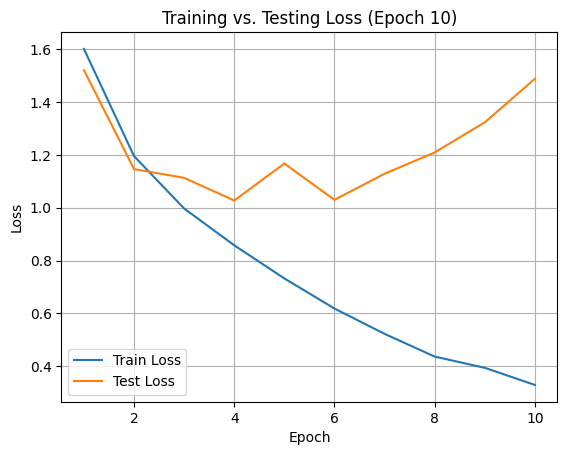

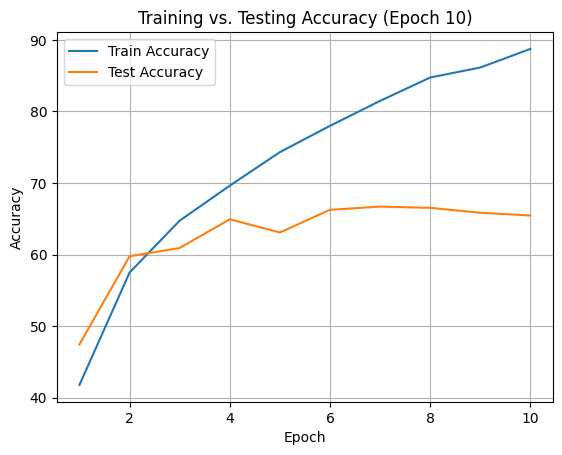

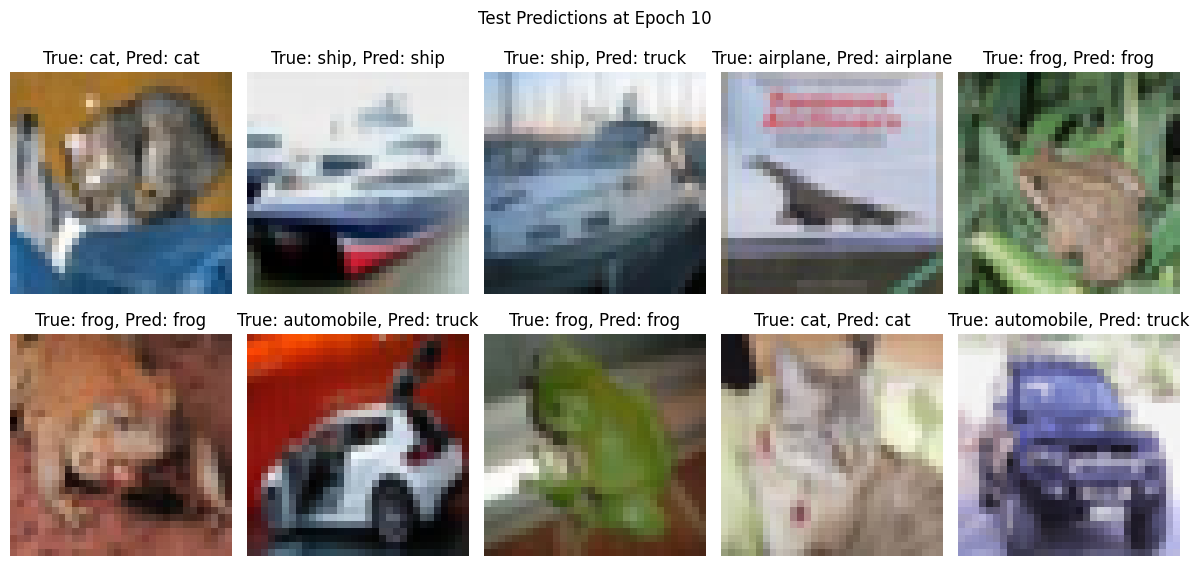


Epoch:  11
Train set: Average loss: 0.3176, Accuracy: 44624/50016 (89%)
Test set: Average loss: 1.6057, Accuracy: 6549/10000 (65%)

Epoch:  12
Train set: Average loss: 0.2950, Accuracy: 45087/50016 (90%)
Test set: Average loss: 1.7771, Accuracy: 6539/10000 (65%)

Epoch:  13
Train set: Average loss: 0.2493, Accuracy: 45804/50016 (92%)
Test set: Average loss: 1.8459, Accuracy: 6385/10000 (64%)

Epoch:  14
Train set: Average loss: 0.2752, Accuracy: 45530/50016 (91%)
Test set: Average loss: 1.9676, Accuracy: 6424/10000 (64%)

Epoch:  15
Train set: Average loss: 0.2612, Accuracy: 45822/50016 (92%)
Test set: Average loss: 2.2162, Accuracy: 6056/10000 (61%)

Epoch:  16
Train set: Average loss: 0.2453, Accuracy: 46062/50016 (92%)
Test set: Average loss: 2.1438, Accuracy: 6427/10000 (64%)

Epoch:  17
Train set: Average loss: 0.2564, Accuracy: 46046/50016 (92%)
Test set: Average loss: 2.0866, Accuracy: 6502/10000 (65%)

Epoch:  18
Train set: Average loss: 0.2588, Accuracy: 45933/50016 (92%)
Tes

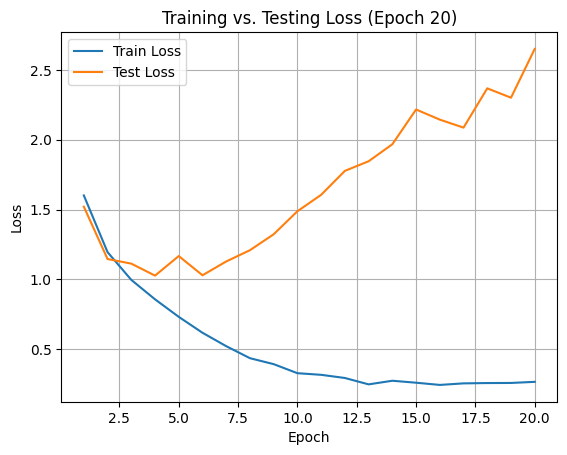

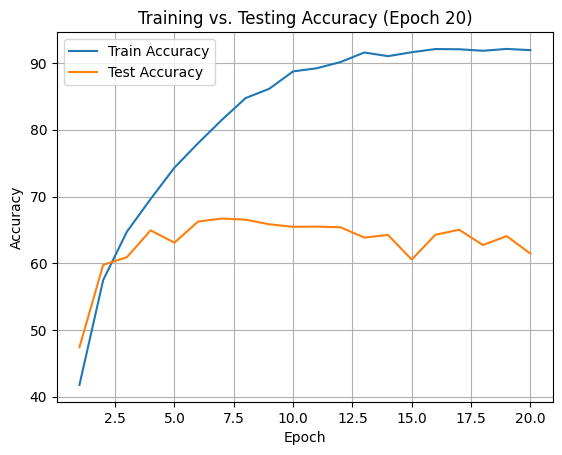

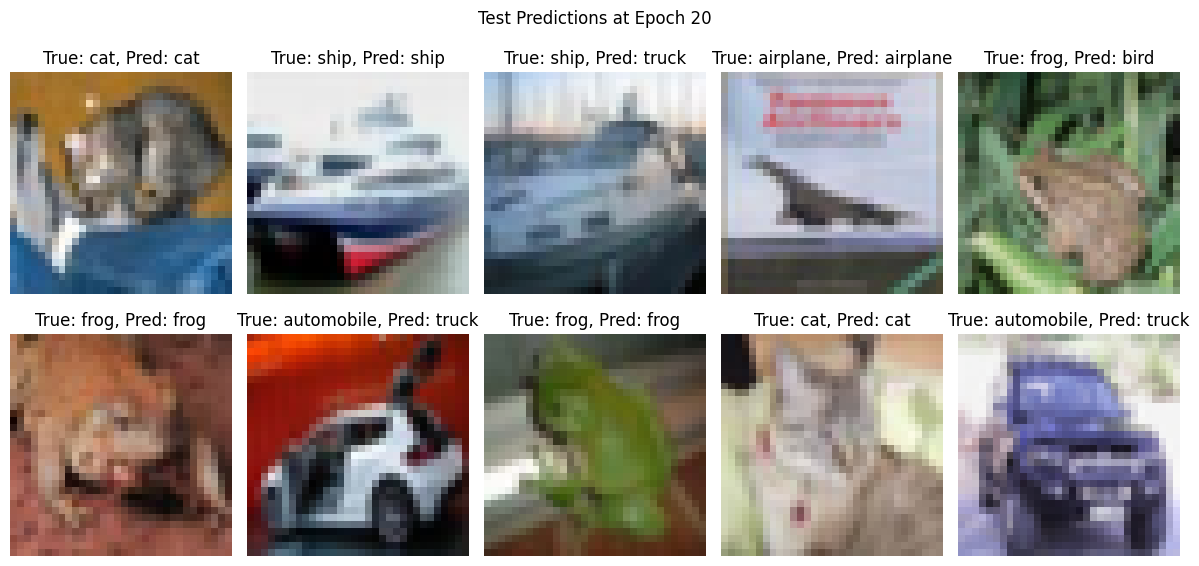


Epoch:  21
Train set: Average loss: 0.2784, Accuracy: 45920/50016 (92%)
Test set: Average loss: 2.5625, Accuracy: 6142/10000 (61%)

Epoch:  22
Train set: Average loss: 0.2302, Accuracy: 46621/50016 (93%)
Test set: Average loss: 2.5811, Accuracy: 6316/10000 (63%)

Epoch:  23
Train set: Average loss: 0.2663, Accuracy: 46192/50016 (92%)
Test set: Average loss: 3.1302, Accuracy: 5957/10000 (60%)

Epoch:  24
Train set: Average loss: 0.2665, Accuracy: 46229/50016 (92%)
Test set: Average loss: 2.8699, Accuracy: 6226/10000 (62%)

Epoch:  25
Train set: Average loss: 0.2656, Accuracy: 46277/50016 (93%)
Test set: Average loss: 2.7658, Accuracy: 6125/10000 (61%)

Epoch:  26
Train set: Average loss: 0.2668, Accuracy: 46298/50016 (93%)
Test set: Average loss: 2.7857, Accuracy: 6213/10000 (62%)

Epoch:  27
Train set: Average loss: 0.3025, Accuracy: 45901/50016 (92%)
Test set: Average loss: 2.6374, Accuracy: 6175/10000 (62%)

Epoch:  28
Train set: Average loss: 0.3011, Accuracy: 45884/50016 (92%)
Tes

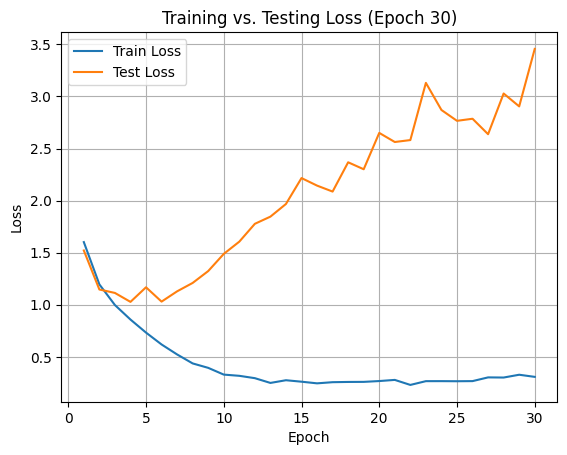

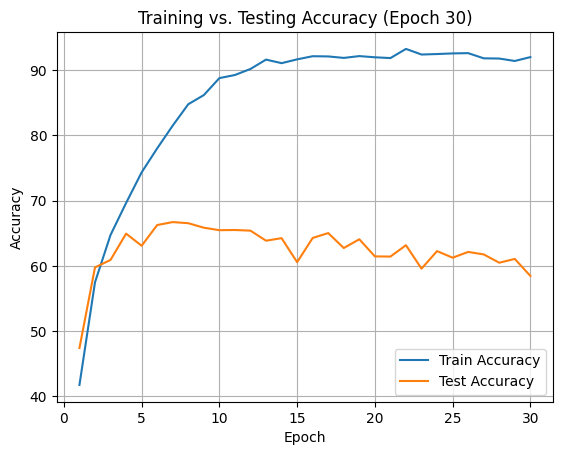

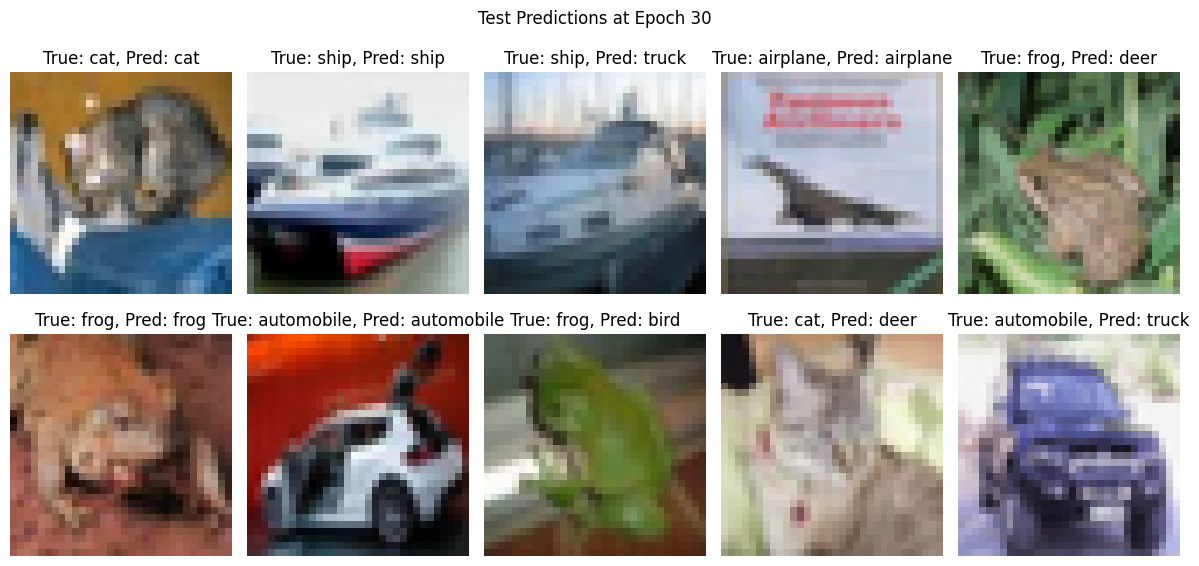

accuracy is 66.70
Training and evaluation finished


In [ ]:
from __future__ import print_function
%load_ext autoreload
%autoreload 2
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from ConvNet import ConvNet
import argparse
import numpy as np

def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''

    # Set model to train mode before each epoch
    model.train()

    # Empty list to store losses
    losses = []
    correct = 0

    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample

        # Push data/label to correct device
        data, target = data.to(device), target.to(device)
        # print(data.shape)
        # print(target.shape)
        # exit()

        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()

        # Do forward pass for current set of data
        output = model(data)

        # ======================================================================
        # Compute loss based on criterion
        #loss = NotImplementedError()
        loss = criterion(output, target)

        # Computes gradient based on final loss
        loss.backward()

        # Store loss
        losses.append(loss.item())

        # Optimize model parameters based on learning rate and gradient
        optimizer.step()

        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # ======================================================================
        # Count correct predictions overall
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc



def test(model, device, test_loader):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''

    # Set model to eval mode to notify all layers.
    model.eval()

    losses = []
    correct = 0

    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)


            # Predict for data by doing forward pass
            output = model(data)

            # ======================================================================
            # Compute loss based on same criterion as training
            loss = F.cross_entropy(output, target, reduction='mean')

            # Append loss to overall test loss
            losses.append(loss.item())

            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # ======================================================================
            # Count correct predictions overall
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy

def plot_metrics(train_losses, test_losses, train_accs, test_accs, epoch):
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(range(1, epoch+1), train_losses, label='Train Loss')
    plt.plot(range(1, epoch+1), test_losses,  label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training vs. Testing Loss (Epoch {epoch})')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(range(1, epoch+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, epoch+1), test_accs,  label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training vs. Testing Accuracy (Epoch {epoch})')
    plt.legend()
    plt.grid()
    plt.show()

def run_main(FLAGS):
    # Check if cuda is available
    use_cuda = torch.cuda.is_available()

    # Set proper device based on cuda availability
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Torch device selected: ", device)

    # Initialize the model and send to device
    model = ConvNet(FLAGS.mode).to(device)
    # print(model)
    # exit()

    # Initialize the criterion for loss computation
    criterion = nn.CrossEntropyLoss(reduction='mean')

    # Initialize optimizer type
    optimizer = optim.SGD(model.parameters(), lr=FLAGS.learning_rate, weight_decay=1e-7)

    # Create transformations to apply to each data sample
    # Can specify variations such as image flip, color flip, random crop, ...
    #transform=transforms.Compose([
    #    transforms.ToTensor(),
    #    transforms.Normalize((0.1307,), (0.3081,))
    #    ])

    transform = transforms.Compose(
                    [transforms.ToTensor(),
                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # Load datasets for training and testing
    # Inbuilt datasets available in torchvision (check documentation online)
    dataset1 = datasets.CIFAR10('./data/', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.CIFAR10('./data/', train=False,
                       transform=transform)
    train_loader = DataLoader(dataset1, batch_size = FLAGS.batch_size,
                                shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset2, batch_size = FLAGS.batch_size,
                                shuffle=False, num_workers=4)

    best_accuracy = 0.0

    train_losses, test_losses = [], []
    train_accs,   test_accs   = [], []
    # Run training for n_epochs specified in config
    for epoch in range(1, FLAGS.num_epochs + 1):
        print("\nEpoch: ", epoch)
        train_loss, train_accuracy = train(model, device, train_loader,
                                            optimizer, criterion, epoch, FLAGS.batch_size)
        test_loss, test_accuracy = test(model, device, test_loader)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

        train_losses.append(train_loss)
        train_accs.append(100*train_accuracy)
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)

        if epoch in [10, 20, 30]:
          plot_metrics(train_losses, test_losses, train_accs, test_accs, epoch)

          # Visualize predictions
          model.eval()
          images, labels = next(iter(test_loader))
          images, labels = images.to(device), labels.to(device)
          classes = dataset1.classes
          with torch.no_grad():
              outputs = model(images)
              predicted = outputs.argmax(dim=1)

          plt.figure(figsize=(12, 6))
          for i in range(10):
              img = images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5
              plt.subplot(2, 5, i + 1)
              plt.imshow(img)
              plt.title(f'True: {classes[labels[i]]}, Pred: {classes[predicted[i]]}')
              plt.axis('off')
          plt.suptitle(f'Test Predictions at Epoch {epoch}')
          plt.tight_layout()
          plt.show()

    print("accuracy is {:2.2f}".format(best_accuracy))

    print("Training and evaluation finished")
#plot loss



if __name__ == '__main__':
    # Set parameters for Sparse Autoencoder
    parser = argparse.ArgumentParser('CNN Exercise.')
    parser.add_argument('--mode',
                        type=int, default=3,
                        help='Select mode between 0-3.')
    parser.add_argument('--learning_rate',
                        type=float, default=0.1,
                        help='Initial learning rate.')
    parser.add_argument('--num_epochs',
                        type=int,
                        default=30,
                        help='Number of epochs to run trainer.')
    parser.add_argument('--batch_size',
                        type=int, default=32,
                        help='Batch size. Must divide evenly into the dataset sizes.')
    parser.add_argument('--log_dir',
                        type=str,
                        default='logs',
                        help='Directory to put logging.')

    FLAGS = None
    FLAGS, unparsed = parser.parse_known_args()

    print("Mode: ", FLAGS.mode)
    print("LR: ", FLAGS.learning_rate)
    print("Batch size: ", FLAGS.batch_size)

    run_main(FLAGS)







First 10 epochs. Model is learning from training data well as seen from training loss, but test loss decreases till epoch 6 then starts to plateau and increase even. This is signs of overfitting. The complexity of this model is helping it memorize well but not generalize well to test data. My guess is we will continue to see this pattern for all 30 epochs, and will be overfitting even more. I will try the data augmentation to improve the model.

After letting it run more it is clear overfitting for the further epochs. It took 40+ minutes and did not improve on test set but contnued to rise for train. Clear overfitting. For this no reason to go past even epoch 8 and save about 30 minutes and lots of computation. Lets try our data augmentation and see if it improves.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mode:  3
LR:  0.1
Batch size:  32
Torch device selected:  cpu

Epoch:  1


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train set: Average loss: 1.7691, Accuracy: 17405/50016 (35%)
Test set: Average loss: 1.4656, Accuracy: 4535/10000 (45%)

Epoch:  2
Train set: Average loss: 1.4232, Accuracy: 24336/50016 (49%)
Test set: Average loss: 1.2358, Accuracy: 5540/10000 (55%)

Epoch:  3
Train set: Average loss: 1.2692, Accuracy: 27363/50016 (55%)
Test set: Average loss: 1.1125, Accuracy: 6062/10000 (61%)

Epoch:  4
Train set: Average loss: 1.1580, Accuracy: 29367/50016 (59%)
Test set: Average loss: 1.0967, Accuracy: 6053/10000 (61%)

Epoch:  5
Train set: Average loss: 1.0706, Accuracy: 31026/50016 (62%)
Test set: Average loss: 1.5788, Accuracy: 5211/10000 (52%)

Epoch:  6
Train set: Average loss: 1.0091, Accuracy: 32279/50016 (65%)
Test set: Average loss: 0.9187, Accuracy: 6729/10000 (67%)

Epoch:  7
Train set: Average loss: 0.9624, Accuracy: 33155/50016 (66%)
Test set: Average loss: 1.0171, Accuracy: 6544/10000 (65%)

Epoch:  8
Train set: Average loss: 0.9219, Accuracy: 33914/50016 (68%)
Test set: Average loss

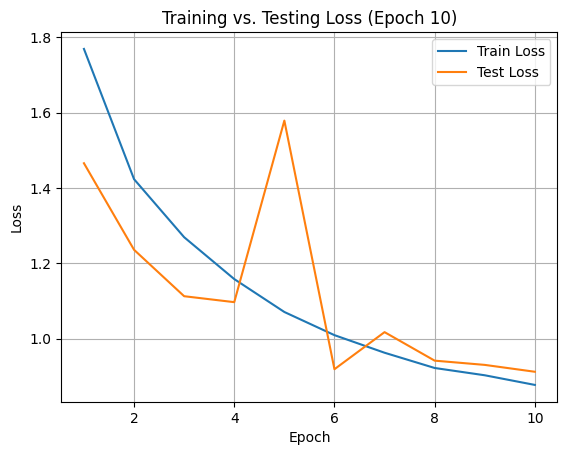

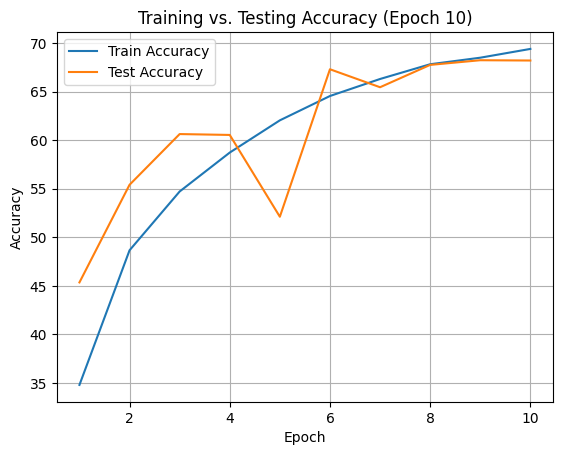

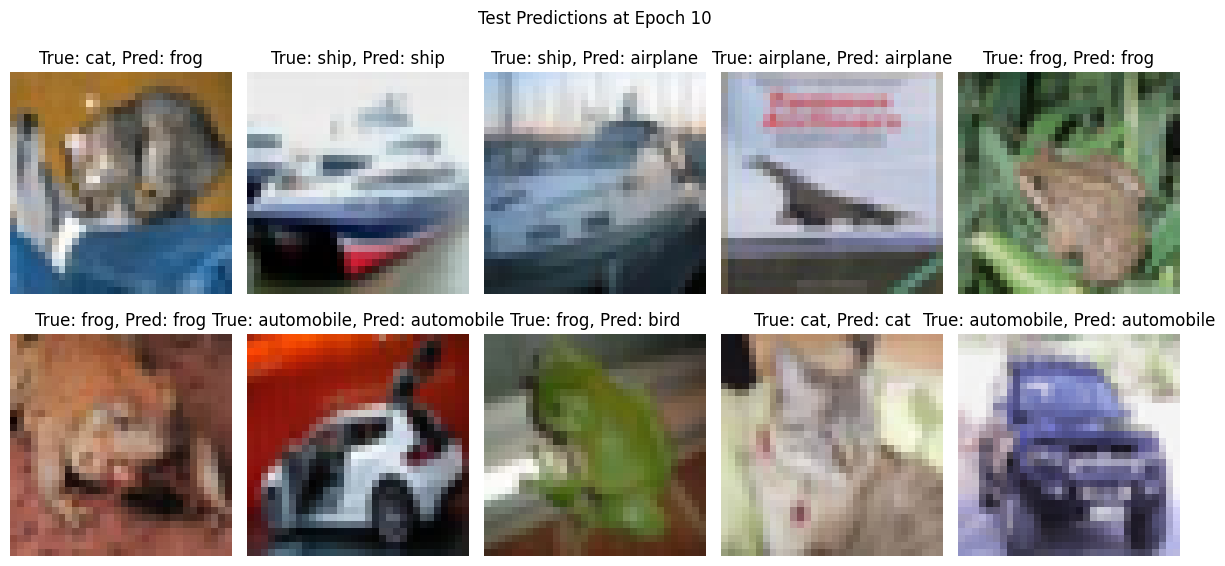


Epoch:  11
Train set: Average loss: 0.8615, Accuracy: 34919/50016 (70%)
Test set: Average loss: 0.8715, Accuracy: 7120/10000 (71%)

Epoch:  12
Train set: Average loss: 0.8516, Accuracy: 35115/50016 (70%)
Test set: Average loss: 0.7908, Accuracy: 7290/10000 (73%)

Epoch:  13
Train set: Average loss: 0.8307, Accuracy: 35555/50016 (71%)
Test set: Average loss: 0.7490, Accuracy: 7441/10000 (74%)

Epoch:  14
Train set: Average loss: 0.8188, Accuracy: 35767/50016 (72%)
Test set: Average loss: 0.8723, Accuracy: 7019/10000 (70%)

Epoch:  15
Train set: Average loss: 0.8081, Accuracy: 35850/50016 (72%)
Test set: Average loss: 0.7979, Accuracy: 7287/10000 (73%)

Epoch:  16
Train set: Average loss: 0.8006, Accuracy: 36205/50016 (72%)
Test set: Average loss: 0.8227, Accuracy: 7278/10000 (73%)

Epoch:  17
Train set: Average loss: 0.7906, Accuracy: 36340/50016 (73%)
Test set: Average loss: 0.8530, Accuracy: 7200/10000 (72%)

Epoch:  18
Train set: Average loss: 0.7897, Accuracy: 36396/50016 (73%)
Tes

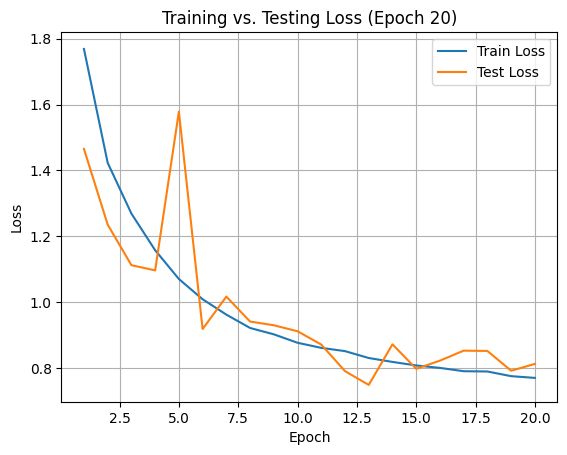

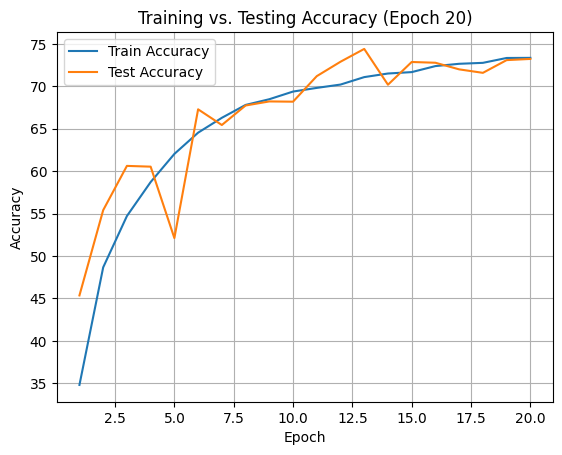

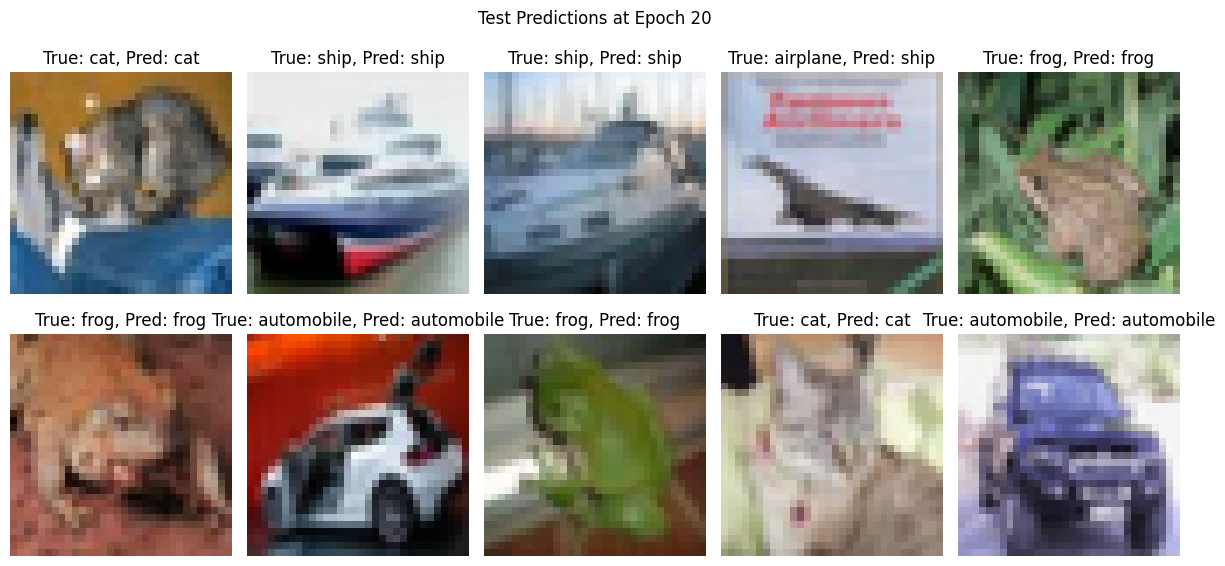


Epoch:  21
Train set: Average loss: 0.7779, Accuracy: 36592/50016 (73%)
Test set: Average loss: 0.7778, Accuracy: 7401/10000 (74%)

Epoch:  22
Train set: Average loss: 0.7638, Accuracy: 36830/50016 (74%)
Test set: Average loss: 0.7676, Accuracy: 7438/10000 (74%)

Epoch:  23
Train set: Average loss: 0.7558, Accuracy: 37089/50016 (74%)
Test set: Average loss: 0.7611, Accuracy: 7435/10000 (74%)

Epoch:  24
Train set: Average loss: 0.7496, Accuracy: 37121/50016 (74%)
Test set: Average loss: 0.7736, Accuracy: 7337/10000 (73%)

Epoch:  25
Train set: Average loss: 0.7545, Accuracy: 37063/50016 (74%)
Test set: Average loss: 0.7671, Accuracy: 7437/10000 (74%)

Epoch:  26
Train set: Average loss: 0.7469, Accuracy: 37128/50016 (74%)
Test set: Average loss: 0.7502, Accuracy: 7492/10000 (75%)

Epoch:  27
Train set: Average loss: 0.7471, Accuracy: 37250/50016 (74%)
Test set: Average loss: 0.7274, Accuracy: 7527/10000 (75%)

Epoch:  28
Train set: Average loss: 0.7364, Accuracy: 37401/50016 (75%)
Tes

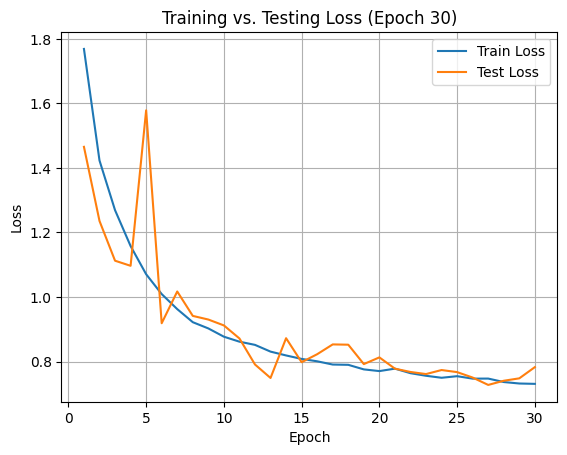

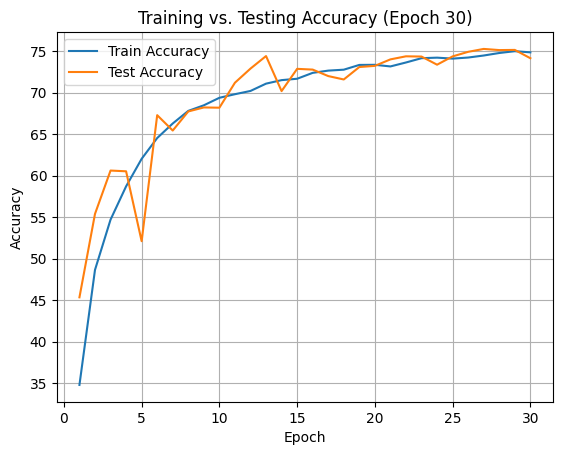

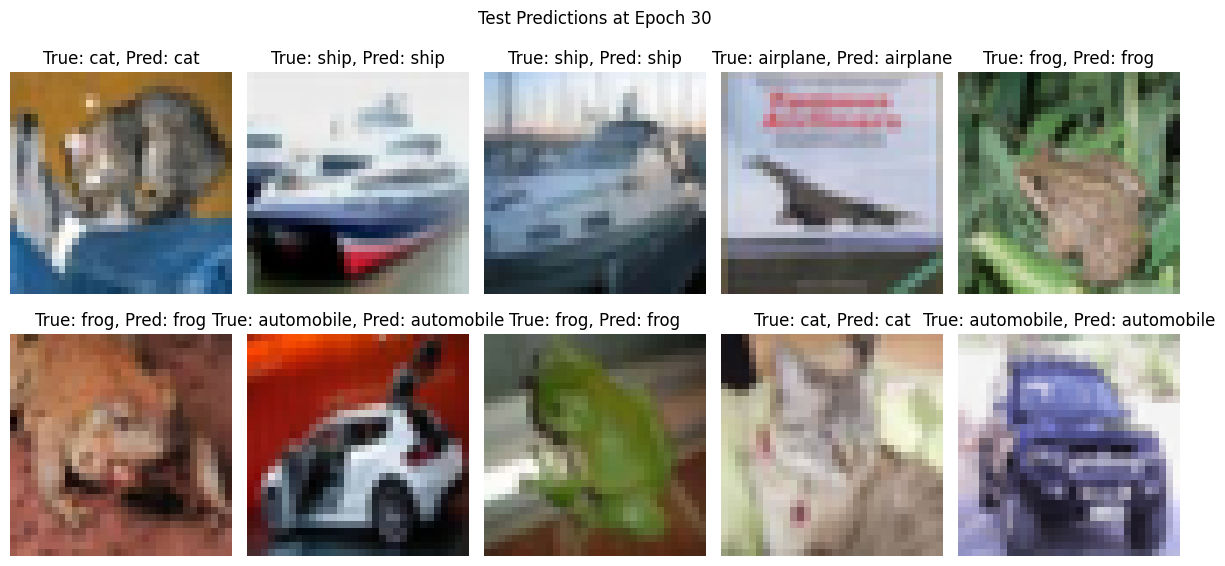

accuracy is 75.27
Training and evaluation finished


In [ ]:
from __future__ import print_function
%load_ext autoreload
%autoreload 2
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from ConvNet import ConvNet
import argparse
import numpy as np

def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''

    # Set model to train mode before each epoch
    model.train()

    # Empty list to store losses
    losses = []
    correct = 0

    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample

        # Push data/label to correct device
        data, target = data.to(device), target.to(device)
        # print(data.shape)
        # print(target.shape)
        # exit()

        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()

        # Do forward pass for current set of data
        output = model(data)

        # ======================================================================
        # Compute loss based on criterion
        #loss = NotImplementedError()
        loss = criterion(output, target)

        # Computes gradient based on final loss
        loss.backward()

        # Store loss
        losses.append(loss.item())

        # Optimize model parameters based on learning rate and gradient
        optimizer.step()

        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # ======================================================================
        # Count correct predictions overall
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc



def test(model, device, test_loader):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''

    # Set model to eval mode to notify all layers.
    model.eval()

    losses = []
    correct = 0

    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)


            # Predict for data by doing forward pass
            output = model(data)

            # ======================================================================
            # Compute loss based on same criterion as training
            loss = F.cross_entropy(output, target, reduction='mean')

            # Append loss to overall test loss
            losses.append(loss.item())

            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # ======================================================================
            # Count correct predictions overall
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy

def plot_metrics(train_losses, test_losses, train_accs, test_accs, epoch):
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(range(1, epoch+1), train_losses, label='Train Loss')
    plt.plot(range(1, epoch+1), test_losses,  label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training vs. Testing Loss (Epoch {epoch})')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(range(1, epoch+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, epoch+1), test_accs,  label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training vs. Testing Accuracy (Epoch {epoch})')
    plt.legend()
    plt.grid()
    plt.show()

def run_main(FLAGS):
    # Check if cuda is available
    use_cuda = torch.cuda.is_available()

    # Set proper device based on cuda availability
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Torch device selected: ", device)

    # Initialize the model and send to device
    model = ConvNet(FLAGS.mode).to(device)
    # print(model)
    # exit()

    # Initialize the criterion for loss computation
    criterion = nn.CrossEntropyLoss(reduction='mean')

    # Initialize optimizer type
    optimizer = optim.SGD(model.parameters(), lr=FLAGS.learning_rate, weight_decay=1e-7)

    # Create transformations to apply to each data sample
    # Can specify variations such as image flip, color flip, random crop, ...
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),          # Random crop with padding
        transforms.RandomHorizontalFlip(),             # Flip images horizontally
        transforms.ToTensor(),                         # Convert PIL image to Tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
    ])

    # No augmentation for test set — only normalization
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load datasets for training and testing
    # Inbuilt datasets available in torchvision (check documentation online)
    dataset1 = datasets.CIFAR10('./data/', train=True, download=True,
                       transform=transform_train)
    dataset2 = datasets.CIFAR10('./data/', train=False,
                       transform=transform_test)
    train_loader = DataLoader(dataset1, batch_size = FLAGS.batch_size,
                                shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset2, batch_size = FLAGS.batch_size,
                                shuffle=False, num_workers=4)

    best_accuracy = 0.0

    train_losses, test_losses = [], []
    train_accs,   test_accs   = [], []
    # Run training for n_epochs specified in config
    for epoch in range(1, FLAGS.num_epochs + 1):
        print("\nEpoch: ", epoch)
        train_loss, train_accuracy = train(model, device, train_loader,
                                            optimizer, criterion, epoch, FLAGS.batch_size)
        test_loss, test_accuracy = test(model, device, test_loader)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

        train_losses.append(train_loss)
        train_accs.append(100*train_accuracy)
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)

        if epoch in [10, 20, 30]:
          plot_metrics(train_losses, test_losses, train_accs, test_accs, epoch)

          # Visualize predictions
          model.eval()
          images, labels = next(iter(test_loader))
          images, labels = images.to(device), labels.to(device)
          classes = dataset1.classes
          with torch.no_grad():
              outputs = model(images)
              predicted = outputs.argmax(dim=1)

          plt.figure(figsize=(12, 6))
          for i in range(10):
              img = images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5
              plt.subplot(2, 5, i + 1)
              plt.imshow(img)
              plt.title(f'True: {classes[labels[i]]}, Pred: {classes[predicted[i]]}')
              plt.axis('off')
          plt.suptitle(f'Test Predictions at Epoch {epoch}')
          plt.tight_layout()
          plt.show()

    print("accuracy is {:2.2f}".format(best_accuracy))

    print("Training and evaluation finished")
#plot loss



if __name__ == '__main__':
    # Set parameters for Sparse Autoencoder
    parser = argparse.ArgumentParser('CNN Exercise.')
    parser.add_argument('--mode',
                        type=int, default=3,
                        help='Select mode between 0-3.')
    parser.add_argument('--learning_rate',
                        type=float, default=0.1,
                        help='Initial learning rate.')
    parser.add_argument('--num_epochs',
                        type=int,
                        default=30,
                        help='Number of epochs to run trainer.')
    parser.add_argument('--batch_size',
                        type=int, default=32,
                        help='Batch size. Must divide evenly into the dataset sizes.')
    parser.add_argument('--log_dir',
                        type=str,
                        default='logs',
                        help='Directory to put logging.')

    FLAGS = None
    FLAGS, unparsed = parser.parse_known_args()

    print("Mode: ", FLAGS.mode)
    print("LR: ", FLAGS.learning_rate)
    print("Batch size: ", FLAGS.batch_size)

    run_main(FLAGS)







10 epochs in: training loss steadily decreasing, testing loss spikes a little but restabilizes so a slight sign of overfitting, but overall very good so far. better than what we have achieved yet.training and test accuracy seem to be converging well, a sign of not overfitting. The data augmentation seems to helping a lot and generalizing the data a lot better. Lets see if it continues to improve

20 epochs in:Is still learning and improving but slowly, but did have a very good jump at epoch 12-13 in test loss then does start to vary some. But the generilization is looking good. Is plateauing at 73% and there are now some signs of overfitting, but overall is looking good.

30 in: Data augmentation seems to have worked very well. Not really any overfitting. Does seem to have plateaued but a few more epochs may have gotten slightly better results. But 30 seems optimal, not over or underfitting, is consistent

Project is done, but I just want to get better accuracy now if your feeling nice and would like to give me some extra credit for it that would be amazing (joking kinda). Heres my next step, add learning rate scheduler so it updates over time and can generalize quicker but learn more, will half every 10 epochs. Add batch norm for better stability and generilization, dropout to prevent overfitting, and random rotation for data augmentation. With my new learning rate im also going to do 70 epochs because it should continue to learn and fine tune for a while

In [ ]:
%%writefile ConvNet.py
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self, mode):
        super(ConvNet, self).__init__()

        # Define various layers here, such as in the tutorial example
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(20)

        #self.conv2 = Make conv layer like above
        self.conv2 = nn.Conv2d(20, 40, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(40)

        self.conv3_m3 = nn.Conv2d(40, 40, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(40)

        self.dropout = nn.Dropout(0.3)




        self.fc1_model1 = nn.Linear(360, 100)  # This is first fully connected layer for step 1.
        self.fc1_model2 = nn.Linear(1440, 100) # This is first fully connected layer for step 2.
        self.fc1_model3 = nn.Linear(4840, 100)  # This is first fully connected layer for step 3

        self.fc2 = nn.Linear(100, 10)       # This is 2nd fully connected layer for all models.

        #self.fc_model0 = nn.Linear(2250, 100)   # This is for example model.
        self.fc_model0 = nn.Linear(360, 100)


        # This will select the forward pass function based on mode for the ConvNet.
        # Based on the question, you have 3 modes available for step 1 to 3.
        # During creation of each ConvNet model, you will assign one of the valid mode.
        # This will fix the forward function (and the network graph) for the entire training/testing
        if mode == 1:
            self.forward = self.model_1
        elif mode == 2:
            self.forward = self.model_2
        elif mode == 3:
            self.forward = self.model_3
        elif mode == 0:
            self.forward = self.model_0
        else:
            print("Invalid mode ", mode, "selected. Select between 1-3")
            exit(0)


    # Example model. Modify this for step 1-3
    def model_0(self, X):
        # ======================================================================
        #2 conv2d layers with ReLU, followed by maxpool2d
        X = F.relu(self.conv1(X)) #conv layer 1
        #print(X.shape)
        X = F.max_pool2d(X, kernel_size=2) #pool 1
        #print(X.shape)

        #self.conv2 = nn.Conv2d(10, 10, kernel_size=3) #layer 2 is in init
        X = F.relu(self.conv2(X))
        #print(X.shape)
        X = F.max_pool2d(X, kernel_size=2) # pool 2
        #print(X.shape

        X = torch.flatten(X, start_dim=1) #flatten
        #print(X.shape)

        X = F.relu(self.fc_model0(X)) #fully connected layers
        X = self.fc2(X)

        return X


    # Simple CNN. step 1
    def model_1(self, X):
        # ======================================================================

        # Complete this part as model_0, add one more conv2d layer
        # with relu activation followed by maxpool layer.

        X = torch.flatten(X, start_dim=1)

        X = F.relu(self.fc1_model1(X))
        X = self.fc2(X)

        return X


    # Increase filters. step 2
    def model_2(self, X):
        # ======================================================================

        # Complete this part as model_1. Modify in/out channels for conv2d layers.
        X = F.relu(self.conv1_m2(X))
        X = F.max_pool2d(X, kernel_size=2)
        X = F.relu(self.conv2_m2(X))
        X = F.max_pool2d(X, kernel_size=2)
        X = torch.flatten(X, start_dim=1)

        X = F.relu(self.fc1_model2(X))
        X = self.fc2(X)

        return X


    # Large CNN. step 3
    def model_3(self, X):
        X = F.relu(self.bn1(self.conv1(X)))
        X = F.max_pool2d(X, 2)

        X = F.relu(self.bn2(self.conv2(X)))
        X = F.relu(self.bn3(self.conv3_m3(X)))
        X = torch.flatten(X, start_dim=1)
        X = self.dropout(X)
        X = F.relu(self.fc1_model3(X))
        X = self.fc2(X)
        return X






Overwriting ConvNet.py


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mode:  3
LR:  0.1
Batch size:  32
Torch device selected:  cpu

Epoch:  1
Train set: Average loss: 1.6045, Accuracy: 20417/50016 (41%)
Test set: Average loss: 1.2636, Accuracy: 5333/10000 (53%)

Epoch:  2
Train set: Average loss: 1.3078, Accuracy: 26618/50016 (53%)
Test set: Average loss: 1.0955, Accuracy: 6098/10000 (61%)

Epoch:  3
Train set: Average loss: 1.1961, Accuracy: 28740/50016 (57%)
Test set: Average loss: 1.0612, Accuracy: 6303/10000 (63%)

Epoch:  4
Train set: Average loss: 1.1325, Accuracy: 29986/50016 (60%)
Test set: Average loss: 0.9741, Accuracy: 6568/10000 (66%)

Epoch:  5
Train set: Average loss: 1.0885, Accuracy: 30718/50016 (61%)
Test set: Average loss: 0.9324, Accuracy: 6773/10000 (68%)

Epoch:  6
Train set: Average loss: 1.0511, Accuracy: 31579/50016 (63%)
Test set: Average loss: 0.8742, Accuracy: 6966/10000 (70%)

Epoch:  7
Train set: Average loss: 1.0171, Accuracy: 32094/5001

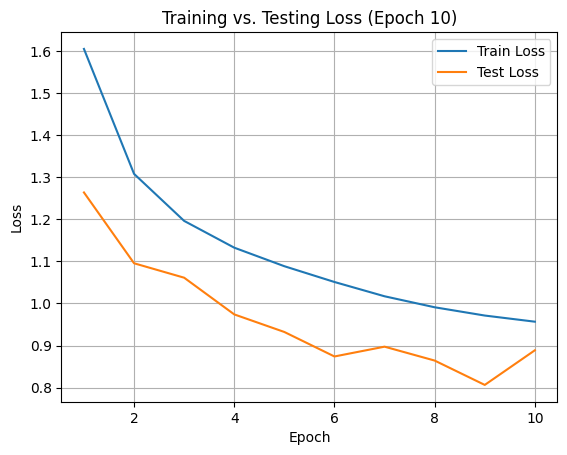

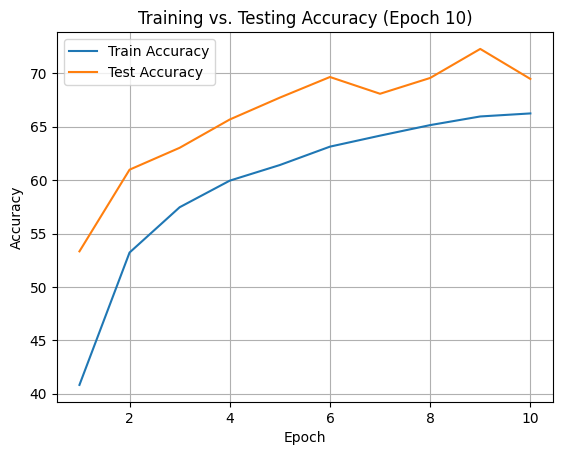

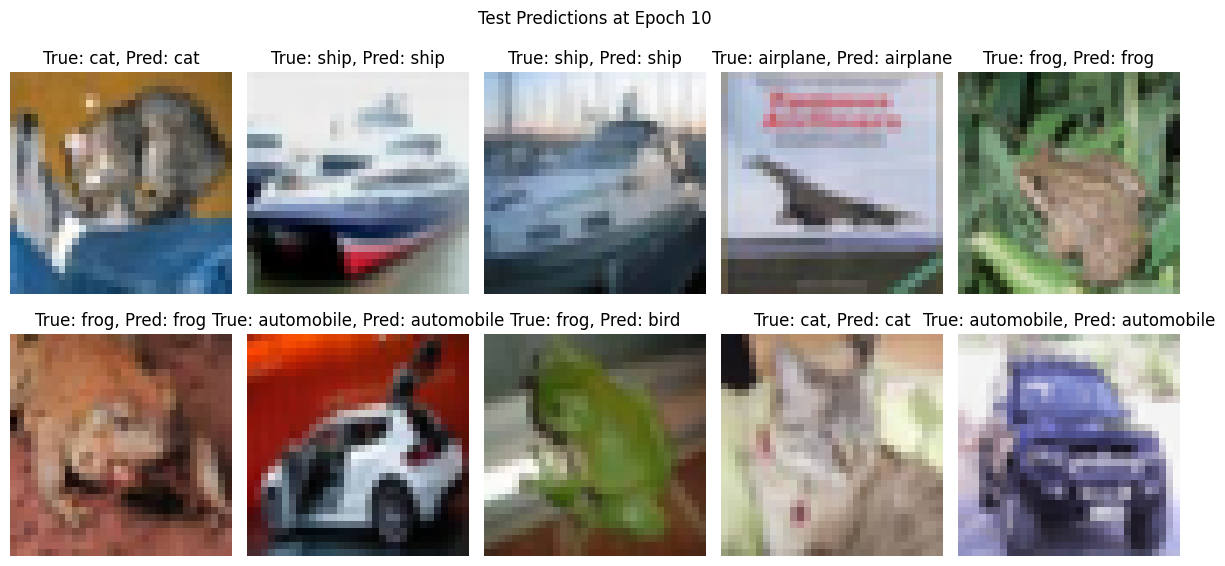


Epoch:  11
Train set: Average loss: 0.8815, Accuracy: 34652/50016 (69%)
Test set: Average loss: 0.7269, Accuracy: 7441/10000 (74%)

Epoch:  12
Train set: Average loss: 0.8623, Accuracy: 34884/50016 (70%)
Test set: Average loss: 0.7030, Accuracy: 7547/10000 (75%)

Epoch:  13
Train set: Average loss: 0.8497, Accuracy: 35110/50016 (70%)
Test set: Average loss: 0.7121, Accuracy: 7496/10000 (75%)

Epoch:  14
Train set: Average loss: 0.8405, Accuracy: 35390/50016 (71%)
Test set: Average loss: 0.6814, Accuracy: 7599/10000 (76%)

Epoch:  15
Train set: Average loss: 0.8339, Accuracy: 35407/50016 (71%)
Test set: Average loss: 0.7401, Accuracy: 7414/10000 (74%)

Epoch:  16
Train set: Average loss: 0.8301, Accuracy: 35485/50016 (71%)
Test set: Average loss: 0.6747, Accuracy: 7627/10000 (76%)

Epoch:  17
Train set: Average loss: 0.8168, Accuracy: 35739/50016 (71%)
Test set: Average loss: 0.6641, Accuracy: 7705/10000 (77%)

Epoch:  18
Train set: Average loss: 0.8156, Accuracy: 35648/50016 (71%)
Tes

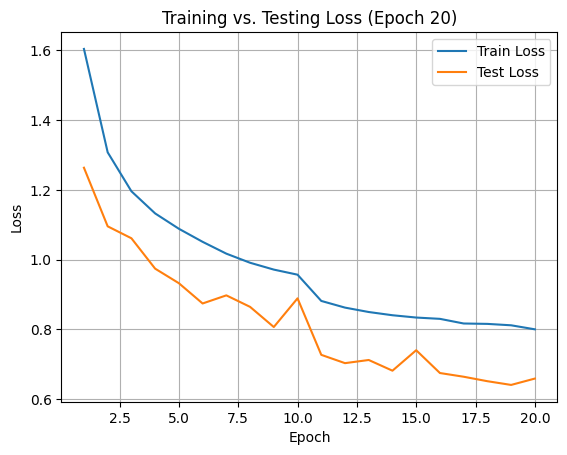

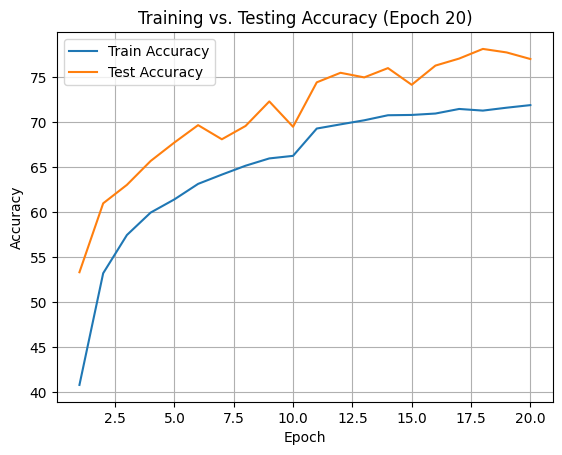

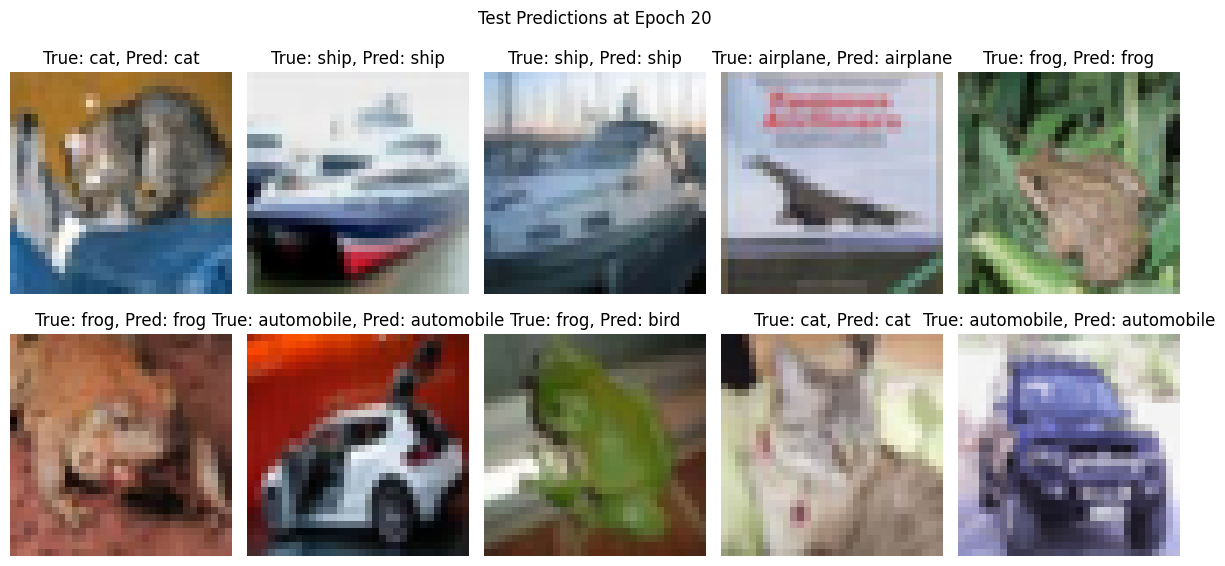


Epoch:  21
Train set: Average loss: 0.7666, Accuracy: 36643/50016 (73%)
Test set: Average loss: 0.6271, Accuracy: 7842/10000 (78%)

Epoch:  22
Train set: Average loss: 0.7552, Accuracy: 36718/50016 (73%)
Test set: Average loss: 0.6225, Accuracy: 7816/10000 (78%)

Epoch:  23
Train set: Average loss: 0.7546, Accuracy: 36726/50016 (73%)
Test set: Average loss: 0.6226, Accuracy: 7820/10000 (78%)

Epoch:  24
Train set: Average loss: 0.7443, Accuracy: 36888/50016 (74%)
Test set: Average loss: 0.6056, Accuracy: 7911/10000 (79%)

Epoch:  25
Train set: Average loss: 0.7477, Accuracy: 36946/50016 (74%)
Test set: Average loss: 0.6083, Accuracy: 7883/10000 (79%)

Epoch:  26
Train set: Average loss: 0.7414, Accuracy: 36982/50016 (74%)
Test set: Average loss: 0.6004, Accuracy: 7880/10000 (79%)

Epoch:  27
Train set: Average loss: 0.7358, Accuracy: 37153/50016 (74%)
Test set: Average loss: 0.6018, Accuracy: 7890/10000 (79%)

Epoch:  28
Train set: Average loss: 0.7329, Accuracy: 37046/50016 (74%)
Tes

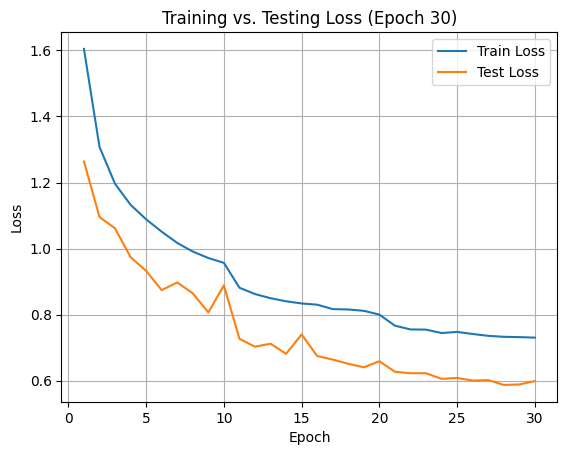

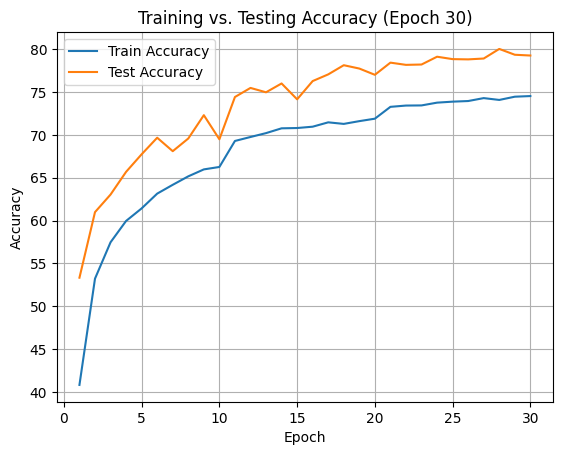

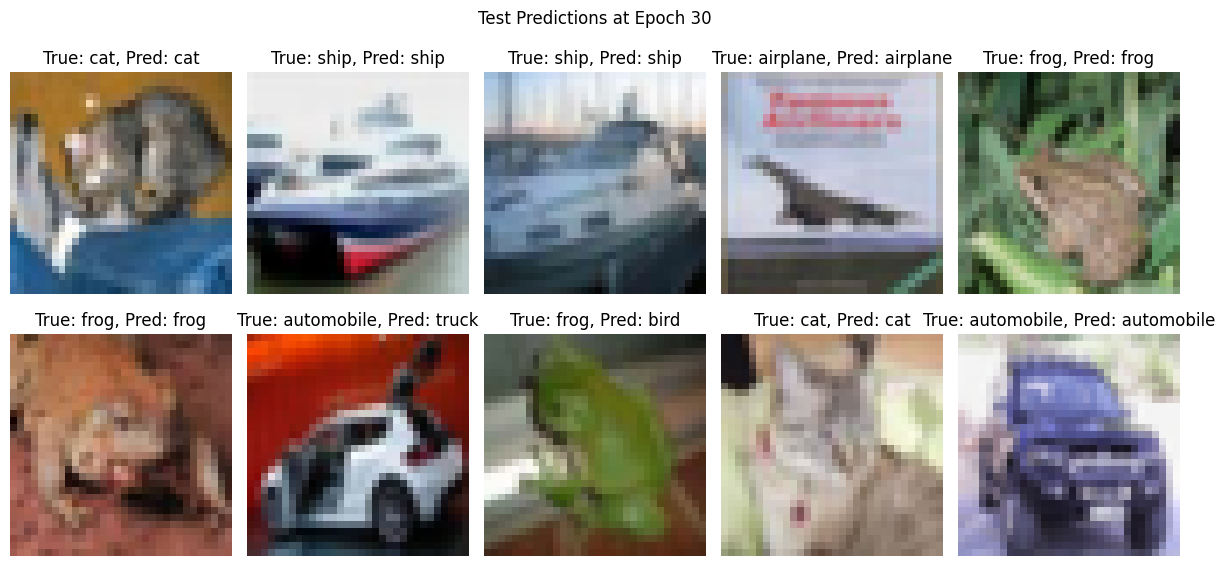


Epoch:  31
Train set: Average loss: 0.7116, Accuracy: 37577/50016 (75%)
Test set: Average loss: 0.5815, Accuracy: 7990/10000 (80%)

Epoch:  32
Train set: Average loss: 0.7102, Accuracy: 37550/50016 (75%)
Test set: Average loss: 0.5759, Accuracy: 8027/10000 (80%)

Epoch:  33
Train set: Average loss: 0.7057, Accuracy: 37679/50016 (75%)
Test set: Average loss: 0.5831, Accuracy: 7987/10000 (80%)

Epoch:  34
Train set: Average loss: 0.7040, Accuracy: 37652/50016 (75%)
Test set: Average loss: 0.5698, Accuracy: 8027/10000 (80%)

Epoch:  35
Train set: Average loss: 0.6992, Accuracy: 37678/50016 (75%)
Test set: Average loss: 0.5709, Accuracy: 8023/10000 (80%)

Epoch:  36
Train set: Average loss: 0.7009, Accuracy: 37747/50016 (75%)
Test set: Average loss: 0.5704, Accuracy: 8016/10000 (80%)

Epoch:  37
Train set: Average loss: 0.6995, Accuracy: 37738/50016 (75%)
Test set: Average loss: 0.5696, Accuracy: 8029/10000 (80%)

Epoch:  38
Train set: Average loss: 0.6974, Accuracy: 37722/50016 (75%)
Tes

In [ ]:
from __future__ import print_function
%load_ext autoreload
%autoreload 2
import argparse
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from ConvNet import ConvNet
import argparse
import numpy as np

def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''

    # Set model to train mode before each epoch
    model.train()

    # Empty list to store losses
    losses = []
    correct = 0

    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample

        # Push data/label to correct device
        data, target = data.to(device), target.to(device)
        # print(data.shape)
        # print(target.shape)
        # exit()

        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()

        # Do forward pass for current set of data
        output = model(data)

        # ======================================================================
        # Compute loss based on criterion
        #loss = NotImplementedError()
        loss = criterion(output, target)

        # Computes gradient based on final loss
        loss.backward()

        # Store loss
        losses.append(loss.item())

        # Optimize model parameters based on learning rate and gradient
        optimizer.step()

        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # ======================================================================
        # Count correct predictions overall
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc



def test(model, device, test_loader):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''

    # Set model to eval mode to notify all layers.
    model.eval()

    losses = []
    correct = 0

    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)


            # Predict for data by doing forward pass
            output = model(data)

            # ======================================================================
            # Compute loss based on same criterion as training
            loss = F.cross_entropy(output, target, reduction='mean')

            # Append loss to overall test loss
            losses.append(loss.item())

            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # ======================================================================
            # Count correct predictions overall
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy

def plot_metrics(train_losses, test_losses, train_accs, test_accs, epoch):
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(range(1, epoch+1), train_losses, label='Train Loss')
    plt.plot(range(1, epoch+1), test_losses,  label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training vs. Testing Loss (Epoch {epoch})')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(range(1, epoch+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, epoch+1), test_accs,  label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training vs. Testing Accuracy (Epoch {epoch})')
    plt.legend()
    plt.grid()
    plt.show()

def run_main(FLAGS):
    # Check if cuda is available
    use_cuda = torch.cuda.is_available()

    # Set proper device based on cuda availability
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Torch device selected: ", device)

    # Initialize the model and send to device
    model = ConvNet(FLAGS.mode).to(device)
    # print(model)
    # exit()

    # Initialize the criterion for loss computation
    criterion = nn.CrossEntropyLoss(reduction='mean')

    # Initialize optimizer type
    optimizer = optim.SGD(model.parameters(), lr=FLAGS.learning_rate, weight_decay=1e-7)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    # Create transformations to apply to each data sample
    # Can specify variations such as image flip, color flip, random crop, ...
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),          # Random crop with padding
        transforms.RandomHorizontalFlip(),             # Flip images horizontally
        transforms.RandomRotation(15),  # ← added this

        transforms.ToTensor(),                         # Convert PIL image to Tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
    ])

    # No augmentation for test set — only normalization
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load datasets for training and testing
    # Inbuilt datasets available in torchvision (check documentation online)
    dataset1 = datasets.CIFAR10('./data/', train=True, download=True,
                       transform=transform_train)
    dataset2 = datasets.CIFAR10('./data/', train=False,
                       transform=transform_test)
    train_loader = DataLoader(dataset1, batch_size = FLAGS.batch_size,
                                shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset2, batch_size = FLAGS.batch_size,
                                shuffle=False, num_workers=4)

    best_accuracy = 0.0

    train_losses, test_losses = [], []
    train_accs,   test_accs   = [], []
    # Run training for n_epochs specified in config
    for epoch in range(1, FLAGS.num_epochs + 1):
        print("\nEpoch: ", epoch)
        train_loss, train_accuracy = train(model, device, train_loader,
                                            optimizer, criterion, epoch, FLAGS.batch_size)
        test_loss, test_accuracy = test(model, device, test_loader)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

        train_losses.append(train_loss)
        train_accs.append(100*train_accuracy)
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)
        scheduler.step()

        if epoch in [10, 20, 30]:
          plot_metrics(train_losses, test_losses, train_accs, test_accs, epoch)

          # Visualize predictions
          model.eval()
          images, labels = next(iter(test_loader))
          images, labels = images.to(device), labels.to(device)
          classes = dataset1.classes
          with torch.no_grad():
              outputs = model(images)
              predicted = outputs.argmax(dim=1)

          plt.figure(figsize=(12, 6))
          for i in range(10):
              img = images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5
              plt.subplot(2, 5, i + 1)
              plt.imshow(img)
              plt.title(f'True: {classes[labels[i]]}, Pred: {classes[predicted[i]]}')
              plt.axis('off')
          plt.suptitle(f'Test Predictions at Epoch {epoch}')
          plt.tight_layout()
          plt.show()

    print("accuracy is {:2.2f}".format(best_accuracy))

    print("Training and evaluation finished")
#plot loss



if __name__ == '__main__':
    # Set parameters for Sparse Autoencoder
    parser = argparse.ArgumentParser('CNN Exercise.')
    parser.add_argument('--mode',
                        type=int, default=3,
                        help='Select mode between 0-3.')
    parser.add_argument('--learning_rate',
                        type=float, default=0.1,
                        help='Initial learning rate.')
    parser.add_argument('--num_epochs',
                        type=int,
                        default=70,
                        help='Number of epochs to run trainer.')
    parser.add_argument('--batch_size',
                        type=int, default=32,
                        help='Batch size. Must divide evenly into the dataset sizes.')
    parser.add_argument('--log_dir',
                        type=str,
                        default='logs',
                        help='Directory to put logging.')

    FLAGS = None
    FLAGS, unparsed = parser.parse_known_args()

    print("Mode: ", FLAGS.mode)
    print("LR: ", FLAGS.learning_rate)
    print("Batch size: ", FLAGS.batch_size)

    run_main(FLAGS)





